In [1]:
# Essential Jupyter Notebook Magic
%matplotlib inline

# General Purpose and Data Handling Libraries
import os
import re
import glob
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from natsort import natsorted
import pickle
from operator import add
import random

# MatPlotlib for Plotting and Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.tri as tri
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import cm, ticker
from matplotlib.colors import LogNorm, LightSource, ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import LogFormatter, LogFormatterSciNotation
from matplotlib.ticker import LogLocator, MultipleLocator, NullFormatter
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
from streamtracer import StreamTracer, VectorGrid
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from cmap import Colormap
from matplotlib.ticker import MaxNLocator


# Scipy for Scientific Computing and Analysis
from scipy import stats, interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, griddata
from scipy.ndimage import label, gaussian_filter
from scipy.spatial import ConvexHull
from scipy.interpolate import RegularGridInterpolator
from skimage import measure
from shapely.geometry import Polygon

# Image Handling and Processing
from PIL import Image

# Tecplot for Scientific Data Visualization
import tecplot as tp
from tecplot.exception import *
from tecplot.constant import *

# For 3d plotting
from skimage import measure

In [2]:
# Define Constants
amu = 1.67e-27
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440e3 #m
m_p = 1.67e-27 # kg
e = 1.60218e-19 # C

# Define utility functions
def read_dataset(mypath):
    # Reads in file "mypath" and returns a dataset object. May take a while for larger files.

    print("reading:",mypath)
    # First connect to TecPlot
    tp.session.connect(port=7601)

    # Configure layout
    tp.new_layout()
    dataset = tp.data.load_tecplot(mypath)
    frame = tp.active_frame()
    frame.plot_type = PlotType.Cartesian3D

    # Return dataset
    return dataset

def Bz_dip(x_array,y_array,z_array):
    # Input: arrays of x,y,z (in planet centered coords).
    # Output: Bz at each point
    
    return - 200.9 * (3*(z_array-0.2)**2 - (x_array**2+y_array**2+(z_array-0.2)**2))/((x_array**2+y_array**2+(z_array-0.2)**2)**(5/2))

def get_files(dir, key=".*cut_particle_region0_0.*", read_time = False, reduce = True):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    
    all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()
    
    # Now give them the appropriate name for their time
    # If we haven't already named these files with their time, do that now
    named_files = {}
    if read_time == False:
        for i in range(len(files)):
            time = round(i*dt+start_time,3)
            named_files[time] = files[i]
    # Otherwise, read the time right from the (last 6 elements) filename
    else:
        for i in range(len(files)):
            time = str("%.2f"%float(files[i][-6:]))
            named_files[time] = files[i]
    
    # Now cut the list down to files inside t_bound
    if reduce:
        reduced_files = {}
        for file_time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
            reduced_files[file_time] = str(named_files[file_time])
        return reduced_files

    else:
        return named_files

def dat_to_plt(dir,files):
    # Hand it a directory with the dict of files in it, and it will convert them to .plt and save in dir
    
    for file in files:
        dataset=read_dataset(str(dir+files[file]))
        print("saving file:",str(dir+files[file][:-3]+"plt"))
        tp.data.save_tecplot_plt(str(dir+files[file][:-3]+"plt"))
        os.remove(str(dir+files[file]))
        print(f"Deleted original .dat file: {files[file]}")

def plt_to_numpy(dataset,var_ls=["Bz"],save_cs = True):
    # Input: the path to a .plt file, and a list of variables to convert into a numpy meshgrid
    # Output: a dictionary of arrays, each labelled according to its name in var_ls
    # Var_ls should be *extensive*, so that this long process does not need to be rerun

    # Extract the coordinate axes
    x_axis = np.unique(dataset.variable("X").values(0).as_numpy_array())
    y_axis = np.unique(dataset.variable("Y").values(0).as_numpy_array())[1:-1]
    z_axis = np.unique(dataset.variable("Z").values(0).as_numpy_array())

    # Create an ordered zone`
    rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis-2),len(z_axis)])

    # Create 3D coordinate meshgrids
    xxx,yyy,zzz = np.meshgrid(x_axis,y_axis,z_axis)

    # Assign coordinate values to the rect_zone using the meshgrids
    rect_zone.values('X')[:] = xxx.ravel()
    rect_zone.values('Y')[:] = yyy.ravel()
    rect_zone.values('Z')[:] = zzz.ravel()

    # Compute derivatives in tecplot, which does it efficiently
    # Compute current density, in A/m^2
    if ("Jx" in var_ls) or ("Jy" in var_ls) or ("Jz" in var_ls):
        print("Computing J = ∇xB")
        tp.data.operate.execute_equation(equation='{Jx} = (ddy({Bz}) - ddz({By}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jy} = (ddz({Bx}) - ddx({Bz}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jz} = (ddx({By}) - ddy({Bx}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)

    # Compute plasma pressure gradient, in nPa / m
    if ("dp_dx" in var_ls) or ("dp_dy" in var_ls) or ("dp_dz" in var_ls):
        print("Computing ∇$p$")
        tp.data.operate.execute_equation(equation='{dp_dx} = (ddx({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
        ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dy} = (ddy({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dz} = (ddz({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        
    # Compute magnetic field gradient , in nT / m
    if ("dB_dx" in var_ls) or ("dB_dy" in var_ls) or ("dB_dz" in var_ls): 
        print("Computing ∇B")
        tp.data.operate.execute_equation(equation='{dB_dx} = (ddx(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dy} = (ddy(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dz} = (ddz(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)

    # Compute advective derivative (u . del) u
    if ("duix_dx" in var_ls):
        print("Computing jacobian for $(u_i\cdot∇)u_i$")
        tp.data.operate.execute_equation(equation='{duix_dx} = (ddx({uxS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiy_dx} = (ddx({uyS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiz_dx} = (ddx({uzS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duix_dy} = (ddy({uxS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiy_dy} = (ddy({uyS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiz_dy} = (ddy({uzS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duix_dz} = (ddz({uxS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiy_dz} = (ddz({uyS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiz_dz} = (ddz({uzS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)

    print("Beginning interpolation...")
    # Interpolate onto rect_zone
    tp.data.operate.interpolate_linear(source_zones=[0],
        destination_zone=1,
        fill_value=0)

    # Define dictionary to save results
    data3d = {"X":xxx,"Y":yyy,"Z":zzz}

    # All all variables to data
    for var in var_ls:
        data3d[var] = rect_zone.values(var).as_numpy_array().reshape(xxx.shape)

    # Save in place
    print("Extraction complete! Saving 3D data ...")
    save_file = open(str(dir+file[:-4]+"_numpy_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
    pickle.dump(data3d, save_file) 
    print("Done!")

    if save_cs:
        #Calculate the plasma beta meshgrid
        beta_meshgrid = (2*mu_0*(rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+rect_zone.values("pzzS0").as_numpy_array()+rect_zone.values("pxxS1").as_numpy_array()+
                                rect_zone.values("pyyS1").as_numpy_array()+rect_zone.values("pzzS1").as_numpy_array())*1e9/3/(rect_zone.values("Bx").as_numpy_array()**2+rect_zone.values("By").as_numpy_array()**2+rect_zone.values("Bz").as_numpy_array()**2)).reshape(xxx.shape)
        beta_meshgrid[np.isnan(beta_meshgrid)] = -1
        
         # New code: extract all of the Z coords, smooth them, and then find the values interpolated to those points!
        data = {"X":xxx[:,:,0],"Y":yyy[:,:,0]} #, "Z":np.zeros_like(xxx[:,:,0])}
        print("Saving cs data...")
        # Define empty array to save the unsmoothed Z values to
        Z_rough = np.zeros_like(xxx[:,:,0])+0.2
        # At each x/y, find the z coord of max beta and save that
        for idy in range(len(yyy[:,0,0])):
            for idx in range(len(xxx[0,:,0])):
                # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                # In this case, set the data value to 0 to let me know where the boundary is!
                if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                    Z_rough[idy,idx] = 0.2
                else:
                    idz = np.argmax(beta_meshgrid[idy,idx,:])
                    Z_rough[idy,idx] = zzz[idy,idx,idz]
    
        # Smoothing parameter
        smoothing_param = 5
        # Smooth the Z meshgrid
        data['Z'] = smooth_meshgrid(xxx[:,:,0], yyy[:,:,0], Z_rough, smoothing_param)
    
        # Use this as a template to extract all the other data with
        for name in var_ls:
            data[name] = np.zeros_like(xxx[:,:,0])
    
            # Extract each variable from tecplot as an array
            var = rect_zone.values(name).as_numpy_array().reshape(xxx.shape)
    
            # At each x/y, find the z coord of max beta and save that
            for idy in range(len(yyy[:,0,0])):
                for idx in range(len(xxx[0,:,0])):
                    # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                    # In this case, set the data value to 0 to let me know where the boundary is!
                    if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                        data[name][idy,idx] = 0
                    else:
                        # Find the indices of the two nearest points
                        lower_idz = np.searchsorted(zzz[idy,idx,:], data['Z'][idy,idx]) - 1
                        upper_idz = lower_idz + 1
    
                        # Get the coordinates of the nearest points
                        Z_lower = zzz[idy,idx,lower_idz]
                        Z_upper = zzz[idy,idx,upper_idz]
                        var_lower = var[idy,idx,lower_idz]
                        var_upper = var[idy,idx,upper_idz]
                        
                        # Perform linear interpolation
                        data[name][idy,idx] = var_lower + (var_upper - var_lower) * (data['Z'][idy,idx] - Z_lower) / (Z_upper - Z_lower)
    
        print("Done!")
        save_file = open(str(dir+file[:-4]+"_csdata_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
        pickle.dump(data, save_file) 


def smooth_meshgrid(X, Y, Z, smoothing_param):
    """
    Smooth the Z values of a meshgrid defined by X, Y coordinates using a Gaussian filter.
    
    Parameters:
    X (2D numpy array): The X coordinates of the meshgrid.
    Y (2D numpy array): The Y coordinates of the meshgrid.
    Z (2D numpy array): The Z coordinates of the meshgrid.
    smoothing_param (float): The standard deviation for the Gaussian kernel, controlling the smoothing.
    
    Returns:
    Z_smoothed (2D numpy array): The smoothed Z values of the meshgrid.
    """
    # Check if X, Y, Z are of the same shape
    if X.shape != Y.shape or X.shape != Z.shape:
        raise ValueError("X, Y, and Z meshgrids must have the same shape")
    
    # Apply Gaussian filter to the Z meshgrid
    Z_smoothed = gaussian_filter(Z, sigma=smoothing_param)
    
    return Z_smoothed

def plot_sphere(ax, radius=1, center=(0, 0, 0), color='b', alpha=0.5, zorder = 1,quarter=False, xlims = [-10,10], ylims = [-10,10], zlims = [-10,10]):
    """
    Plots a sphere of given radius centered at center on the provided 3D axis.
    
    Parameters:
    - ax: The 3D axis to plot the sphere on.
    - radius: The radius of the sphere (default: 1).
    - center: The (x, y, z) coordinates of the sphere's center (default: (0, 0, 0)).
    - color: The color of the sphere (default: blue).
    - alpha: The transparency of the sphere (default: 0.5).
    """
    u = np.linspace(np.pi/2, 3/2 * np.pi, 100)
    if quarter:
        v = np.linspace(0, np.pi/2, 100)
    else:
        v = np.linspace(0, np.pi, 100)
    x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
    y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]

    # Mask out any values outside the axes lims
    mask = (x < xlims[0]) | (x > xlims[1]) | (y < ylims[0]) | (y > ylims[1]) | (z < zlims[0]) | (z > zlims[1]) 
    x[mask] = np.nan
    y[mask] = np.nan
    z[mask] = np.nan

    ax.plot_surface(x, y, z, color=color, alpha=alpha, zorder=zorder)

def average_value(var_ls,t0,t_start,t_stop,type='csdata'):
    # Input: Variables to average, the current time (t0), and the times relative to present to average over (t0+t_start to t0+t_stop)
    # Ouput: dictionary of arrays of time-averaged values

    averages = {}
    count = 0

    temp_files = get_files(dir,key="3d\_fluid.*"+type+"\_t\_...\...",read_time = True, reduce = False)

    for t in list(temp_files.keys()): 
        # Check to see if this file is in the time range we want
        if (float(t) >= (t0+t_start)) and (float(t) <= t0+t_stop):
            temp_file = str(temp_files[t])
    
            # Read in this data
            with open(dir+temp_file, 'rb') as f:
                temp_data = pickle.load(f) 
            
            # Add the data to our running average for each variable
            for var in var_ls:
                if var not in averages.keys():
                    averages[var] = temp_data[var]
                else:
                    averages[var] += temp_data[var]

            count += 1
        
    # Divide by total time steps
    for var in var_ls:
        averages[var] = averages[var]/count

    return averages

def find_indices(X, Y, XX, YY):
    # Function used to get ix and iy for some coordinates X and Y
    X = np.array(X)
    Y = np.array(Y)
    XX = np.array(XX)
    YY = np.array(YY)

    ix = []
    iy = []
    
    for (x, y) in zip(X, Y):
        # Find the closest index in the meshgrid for the x coordinate
        ix_index = np.abs(XX[0] - x).argmin()
        # Find the closest index in the meshgrid for the y coordinate
        iy_index = np.abs(YY[:, 0] - y).argmin()
        
        ix.append(ix_index)
        iy.append(iy_index)
        
    return iy, ix

def remove_duplicate_rows(arr):
    # Used in df_tracker... does something to remove repeated rows in the matching matrix
    seen = set()
    filtered_rows = []
    for row in arr:
        if row[0] not in seen:
            filtered_rows.append(row)
            seen.add(row[0])
    return np.array(filtered_rows)

def find_boundary_points(X, Y):
    # Combine the coordinate lists into a single array of points
    points = np.column_stack((X, Y))

    # Compute the convex hull of the points
    hull = ConvexHull(points)

    # Extract the boundary points
    boundary_points = hull.vertices

    # Boundary points in original coordinate lists
    boundary_X = points[boundary_points, 0]
    boundary_Y = points[boundary_points, 1]

    return boundary_X.tolist(), boundary_Y.tolist()

def create_above_surface_mask(X, Y, Z, XX, YY, ZZ):
    # Works out all the 3D points above a 2D surface ie all the points above the current sheet.
    # Used for 3D plotting to determine what is above what.
    # Check that XX, YY, ZZ have the same shape
    assert XX.shape == YY.shape == ZZ.shape, "Arrays XX, YY, and ZZ must have the same shape"
    
    # Check that X, Y, Z have the same shape
    assert X.shape == Y.shape == Z.shape, "Arrays X, Y, and Z must have the same shape"

    # Determine the shape of the input arrays
    nx, ny, nz = XX.shape

    # Initialize a mask with the same shape as ZZ
    mask = np.zeros_like(ZZ, dtype=bool)

    # Iterate over the entire 3D meshgrid
    for i in range(nx):
        for j in range(ny):
            # Find the index in the 2D arrays corresponding to the x and y coordinates
            xi = np.argmin(np.abs(X[0] - XX[i, j, 0]))
            yi = np.argmin(np.abs(Y[:, 0] - YY[i, j, 0]))

            # Compare ZZ with Z to determine the mask
            mask[i, j, :] = ZZ[i, j, :] > Z[yi, xi]

    return mask


def compute_dt(var_ls,time,type='csdata'):
    # Input: variables to compute the time derivative for, and the current time
    # Output: dictionary of time derivatives for each variable, calculated as dvar_dt = var(time+dt)-var(time-dt)/(2*dt)
    # If earlier or later times are not available, we do either var(time+dt)-var(time)/dt or var(time)-var(time-dt)/dt

    # Declare output dictionary
    deriv_dict = {}
    #print("Computing time derivatives at time",time)
    key_minus = '{:.2f}'.format((float(time)-dt), 'wb')
    key_plus = '{:.2f}'.format((float(time)+dt), 'wb')
    #print(files.keys())
    #print(key_minus)
    #print(key_plus)

    if type=='csdata':
        temp_files = filescs
        data = datacs
    elif type=='numpy':
        temp_files = files3D
        data = data3d

    # Read in the data depending on whether its available
    if (key_minus in temp_files.keys()) and (key_plus in temp_files.keys()):
        # Case one: earlier and later timestep available, so use both
        #print("Earlier and later timesteps available!")
        with open(dir+temp_files[key_minus], 'rb') as f:
            data_tminus = pickle.load(f) 
        with open(dir+temp_files[key_plus], 'rb') as f:
            data_tplus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data_tplus[var]-data_tminus[var])/(2*dt)
    
    elif (key_minus in temp_files.keys()):
        # Case two: only earlier time available
        #print("Only earlier timestep available!")
        with open(dir+temp_files[key_minus], 'rb') as f:
            data_tminus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data[var]-data_tminus[var])/(dt)

    elif (key_plus in temp_files.keys()):
        # Case three: only later time available
        #print("Only later timestep available!")
        print(dir+temp_files[key_plus])
        with open(dir+temp_files[key_plus], 'rb') as f:
            data_tplus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data_tplus[var]-data[var])/(dt)

    else:
        print("ERROR: NO OTHER TIMESTEPS FOUND FOR DERIVATIVE AT TIME =",time)
            
    return deriv_dict

def plane_intersection(x, y, z, plane_z=0.2):
    # Used in 3D_df_tracker2 to check whether a given field line intersects the current sheet multiple times or not
    intersections = 0  # Counter for intersections with the plane

    # Iterate over the list of points
    for i in range(1, len(z)):
        if (z[i-1] - plane_z) * (z[i] - plane_z) < 0:
            # There is an intersection between z[i-1] and z[i] since their signs are different
            intersections += 1
        elif z[i-1] == plane_z and z[i] != plane_z:
            # Edge case: the point is exactly on the plane
            intersections += 1

    return intersections

def symlog(x):
    """ Returns the symmetric log10 value """
    return np.sign(x) * np.log10(np.abs(x))

def symroot(x):
    """ Returns the symmetric sqrt value """
    return np.sign(x) * np.sqrt(np.abs(x))

# Functions for adding arrows; use "setattr(Axes3D, 'arrow3D', _arrow3D)" after defining your axes
class Arrow3D(FancyArrowPatch):
            def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
                super().__init__((0, 0), (0, 0), *args, **kwargs)
                self._xyz = (x, y, z)
                self._dxdydz = (dx, dy, dz)
        
            def draw(self, renderer):
                x1, y1, z1 = self._xyz
                dx, dy, dz = self._dxdydz
                x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)
        
                xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
                self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
                super().draw(renderer)
                
            def do_3d_projection(self, renderer=None):
                x1, y1, z1 = self._xyz
                dx, dy, dz = self._dxdydz
                x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)
        
                xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
                self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
                
                return np.min(zs) 
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)

In [36]:
# STEP ONE: process data
dir = "/Volumes/My Book Duo/runs/nightside_v5_run1/ta-2/" #   # Directory with data 
start_time = 30 
t_bound = [30,50]                                               # Start and stop times of this data to be plot
dt = 0.05                                                     # What is the timestZep between files?
convert_first = True # Set to true to make sure files are converted from .dat to .plt. Set to false if there are .dat files in the directory which do not need to be converted

var_ls = ["Bx","By","Bz","Ex","Ey","Ez","rhoS0","uxS0","uyS0","uzS0","pxxS0","pyyS0","pzzS0","pxyS0","pxzS0","pyzS0",
          "rhoS1","uxS1","uyS1","uzS1","pxxS1","pyyS1","pzzS1","pxyS1","pxzS1","pyzS1","Jx","Jy","Jz","dp_dx","dp_dy","dp_dz",
          "dB_dx","dB_dy","dB_dz","duix_dx","duiy_dx","duiz_dx","duix_dy","duiy_dy","duiz_dy","duix_dz","duiy_dz","duiz_dz"]


# RUN
if convert_first:
    files = get_files(dir,key="3d\_fluid.*\.dat")
    dat_to_plt(dir,files)

files = get_files(dir,key="3d\_fluid.*\.plt")

for time in list(files.keys()): 
    print("Extracting data for t =",time)
    file = str(files[time])

    # Read in dataset
    dataset = read_dataset(dir+file)
    # Save .plt as numpy data
    data = plt_to_numpy(dataset,var_ls=var_ls)


reading: /Volumes/My Book Duo/runs/nightside_v5_run1/ta-2/3d_fluid_region0_0_t00000030_n00000000_amrex.dat
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7601
Connection established.
saving file: /Volumes/My Book Duo/runs/nightside_v5_run1/ta-2/3d_fluid_region0_0_t00000030_n00000000_amrex.plt
Deleted original .dat file: 3d_fluid_region0_0_t00000030_n00000000_amrex.dat
reading: /Volumes/My Book Duo/runs/nightside_v5_run1/ta-2/3d_fluid_region0_0_t00000030_n00000031_amrex.dat
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7601
Connection established.
saving file: /Volumes/My Book Duo/runs/nightside_v5_run1/ta-2/3d_fluid_region0_0_t00000030_n00000031_amrex.plt
Deleted original .dat file: 3d_fluid_region0_0_t00000030_n00000031_amrex.dat
reading: /Volumes/My Book Duo/runs/nightside_v5_run1/ta-2/3d_fluid_region0_0_t00000030_n00000072_amrex.dat
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7601
Connection established.
saving file: /Volumes

ZMQError: Operation cannot be accomplished in current state

In [6]:
# STEP TWO: read and plot
#dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e/"     # Directory with data 
dir = "/Volumes/My Book Duo/runs/nightside_v5_run2/ta-2/"
start_time = 30 
t_bound = [40,70]                                               # Start and stop times of this data to be plot
dt = 0.05
cell_size = R_M/64         # Edge length of Pic cell, in m

# Plotmode settings
plot_preset = '3D_df_tracker3'

# Supress error message
np.seterr(divide='ignore', invalid='ignore')

'''
"3D_Bz": Bz in PIC domain.

"3D_Bz1": Bz1 in PIC domain.

"3D_delta_Bz": delta Bz in PIC domain.

"3D_df_tracker": show DFs and track their trajectories, saving a dictionary of their data

"3D_field_lines": view of field line geometry in FLEKS domain

"3D_flux_tube_content":

"3D_FACs": scatterplot 3D shading of parallel and anti-parallel FACS

"3D_FAC_fieldlines": field lines showing connectivity of FACs to DFs

"3D_current_sheet": Shows 3 xz plane slices of the plasma beta and current density, to demonstrate cs fit

"3D_gridscale_df_tracker": Similar to df_tracker, but does not compute DF-averaged quantities, instead finding full electric field and current terms

"3D_df_tracker2": Minor redesign of df tracker algorithm, post-AGU2024. Not finished, but is nice and tidy for testing out different search criteria. Field line categorization is implemented.

"3D_df_tracker2_visualizer": 3D visualization of DF tracking, with field lines and classification.

"3D_df_tracker3": Rework of df_tracker2, requiring that DFs are formed in a DF-forming reason, or are children of them.

"3D_df_tracker3_visualizer": 

'''

# Zoom controls, for 3D_df_tracker and 3D_gridscale_df_tracker:
do_zoom = True # whether panels should zoom
zoom_time_start = 49.00 # when to start zooming
zoom_time_end = 50.00 # when to end
zoom_x_range = [-3.99,-0.25] # what x region to zoom to
zoom_y_range = [-1,1] # what y region to zoom to
zoom_z_range = [0,0.8]
azim_start = -140
azim_end = -135
elev_start = 55
elev_end = 45

# For 3D_gridscale_df_tracker:
gridscale_physics = "forces" # "currents" to show J_inrt and J_gradp or "forces" to show JxB and -grad(p)

# Are we resuming a plotting run? (e.g. if the kernel died during a tracker plotting run)
resume_tracking = False

#RUN
files3D = get_files(dir,key="3d\_fluid.*numpy\_t\_...\...",read_time = True)
filescs = get_files(dir,key="3d\_fluid.*csdata\_t\_...\...",read_time = True)

iter = 0
for time in list(files3D.keys()): 
    print("Plotting t =",time)

    # Read in the 3D data
    file3D = str(files3D[time])
    with open(dir+file3D, 'rb') as f:
        data3d = pickle.load(f) 
    
    # Read in current sheet data
    filecs = str(filescs[time])
    with open(dir+filecs, 'rb') as f:
        datacs = pickle.load(f) 

    # PLOT PRESET 'Bz'
    if plot_preset=='3D_Bz':
        fig = plt.figure(figsize=(13,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        # Unpack variables
        X = datacs["X"]
        Y = datacs["Y"]
        Z = datacs["Z"]
        Bz = datacs["Bz"]

        # Mask out values
        radius = 1.10
        mask = (X**2 + Y**2) < radius**2
        Z[mask] = np.nan

        mid = 71 # Row index corresponding to midnight 
        # Define colormap and lighting
        norm = plt.Normalize(-50,50)
        dawn_colors = cm.bwr(norm(Bz[:mid,:]),alpha=0.5)
        dusk_colors = cm.bwr(norm(Bz[mid:,:]),alpha=0.5)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        ax.view_init(elev=20, azim=-110)

        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(X[mid:,:], Y[mid:,:], Z[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1.5)
        plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=-1)
        plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=-0.75)
        
        # Add stream traces
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)
        ny,nx,nz = data3d["Bx"].shape
        
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(data3d["Bx"],axes=[1,0,2])
        field[:,:,:,1] = np.transpose(data3d["By"],axes=[1,0,2])
        field[:,:,:,2] = np.transpose(data3d["Bz"],axes=[1,0,2])
        
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [data3d["X"].min(),data3d["Y"].min(),data3d["Z"].min()])
        
        seeds = np.array([[-1.5,0,0.2], [-1.75,0,0.2],[-2,0,0.2],[-2.25,0,0.2]])
        tracer.trace(seeds, grid)

        for seed in range(len(seeds)):
            start = np.where(tracer.xs[seed][:,2]>=seeds[seed][2])[0][0]
            ax.plot(tracer.xs[seed][start:,0],tracer.xs[seed][start:,1],tracer.xs[seed][start:,2],color='black',linewidth=0.5,zorder=2)

        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.bwr, norm=norm)
        m.set_array(Bz)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(0.5,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$B_z$ [nT]',fontsize=12)

        # Set axes
        z_lower = -0.6
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = X.max() - X.min()
        y_range = Y.max() - Y.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        
        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$B_z$ at t="+time+"s"),fontsize=12,y=1.0, pad=-14)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)

    # PLOT PRESET '3D_Bz1'
    if plot_preset=='3D_Bz1':
        fig = plt.figure(figsize=(13,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        # Unpack variables
        Xcs = datacs["X"]
        Ycs = datacs["Y"]
        Zcs = datacs["Z"]
        Bzcs = datacs["Bz"]
        Bz1cs = Bzcs - Bz_dip(Xcs,Ycs,Zcs)
        
        X3d = data3d["X"]
        Y3d = data3d["Y"]
        Z3d = data3d["Z"]
        Bz3d = data3d["Bz"]
        Bz13d = Bz3d - Bz_dip(X3d,Y3d,Z3d)

        # Mask out values
        radius = 1.10
        mask = (Xcs**2 + Ycs**2) < radius**2
        Zcs[mask] = np.nan

        mid = 71 # Row index corresponding to midnight 
        # Define colormap and lighting
        vmin=-100
        vmax=0
        norm = plt.Normalize(-100,10)
        dawn_colors = cm.plasma(norm(Bz1cs[:mid,:]),alpha=0.5)
        dusk_colors = cm.plasma(norm(Bz1cs[mid:,:]),alpha=0.5)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        ax.view_init(elev=5, azim=-90)

        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(X[mid:,:], Y[mid:,:], Z[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1)
        plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1)
        plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25)
        
        # Add isosurfaces
        b1min = 0
        iso = ax.scatter(X3d[Bz13d>b1min],Y3d[Bz13d>b1min],Z3d[Bz13d>b1min],c=Bz13d[Bz13d>b1min],
                         vmin=vmin,vmax=vmax,cmap='plasma',s=1,alpha=0.5)

        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.plasma, norm=norm)
        m.set_array(Bz1cs)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(0.5,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$B_{z1}$ [nT]',fontsize=12,pad=10)

        # Set axes
        z_lower = -0.6
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = X.max() - X.min()
        y_range = Y.max() - Y.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        
        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$B_{z1}$ at t="+time+"s"),fontsize=12,y=1.0, pad=-14)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)


    # PLOT PRESET '3D_delta_Bz'
    if plot_preset=='3D_delta_Bz':
        fig = plt.figure(figsize=(13,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)
        x_cutoff = 0 # How many indices in X to cutoff
        z_cutoff = 0 # How many indices in Z to cutoff

        # Unpack variables
        Xcs = datacs["X"][:,x_cutoff:]
        Ycs = datacs["Y"][:,x_cutoff:]
        Zcs = datacs["Z"][:,x_cutoff:]
        Bzcs = datacs["Bz"][:,x_cutoff:]
        deltaBzcs = Bzcs - average_value(["Bz"],float(time),-5,-2,type='csdata')["Bz"][:,x_cutoff:]
        
        X3d = data3d["X"][:,x_cutoff:,z_cutoff:]
        Y3d = data3d["Y"][:,x_cutoff:,z_cutoff:]
        Z3d = data3d["Z"][:,x_cutoff:,z_cutoff:]
        Bz3d = data3d["Bz"][:,x_cutoff:,z_cutoff:]
        deltaBz3d = Bz3d - average_value(["Bz"],float(time),-5,2,type='numpy')["Bz"][:,x_cutoff:,z_cutoff:]


        # Mask out values
        radius = 1.01
        mask = (Xcs**2 + Ycs**2) < radius**2
        Zcs[mask] = np.nan

        mid = 71 # Row index corresponding to midnight 
        # Define colormap and lighting
        vmin=-25
        vmax=25
        norm = plt.Normalize(vmin,vmax)
        dawn_colors = cm.bwr(norm(deltaBzcs[:mid,:]),alpha=0.9)
        dusk_colors = cm.bwr(norm(deltaBzcs[mid:,:]),alpha=0.9)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Zcs[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Zcs[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        ax.view_init(elev=30, azim=-160)

        # Create the surface plot
        surf1 = ax.plot_surface(Xcs[:mid,:], Ycs[:mid,:], Zcs[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(Xcs[mid:,:], Ycs[mid:,:], Zcs[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1.5)
        plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1)
        plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25)
        
        # Add isosurfaces
        Bmin = 10
        above_mask = (deltaBz3d>Bmin) & create_above_surface_mask(Xcs, Ycs, Zcs, X3d, Y3d, Z3d) 
        #iso1 = ax.scatter(X3d[above_mask],Y3d[above_mask],Z3d[above_mask],c=deltaBz3d[above_mask],cmap='bwr',vmin=vmin,vmax=vmax,
        #                 s=0.8,zorder=3,alpha = np.clip(((deltaBz3d[above_mask]-Bmin)/(vmax-Bmin))**0.2,0,1))
        iso1 = ax.scatter(X3d[above_mask],Y3d[above_mask],Z3d[above_mask],c=(-Z3d[above_mask]),cmap='Greens',vmin=-0.6,vmax=0.1,
                         s=0.8,zorder=3,alpha = 0.8)#,alpha = np.clip(((deltaBz3d[above_mask]-Bmin)/(vmax-Bmin))**0.2,0,1))
        below_mask = (deltaBz3d>Bmin) & ~(create_above_surface_mask(Xcs, Ycs, Zcs, X3d, Y3d, Z3d)) 
        iso2 = ax.scatter(X3d[below_mask],Y3d[below_mask],Z3d[below_mask],c=(-Z3d[below_mask]),cmap='Greens',vmin=-0.5,vmax=0.5,
                         s=0.8,zorder=0.75,alpha = 0.8)#,alpha = np.clip(((deltaBz3d[below_mask]-Bmin)/(vmax-Bmin))**0.2,0,1))

        # Add Bz=0 line
        #contour_mask = np.isclose(Bzcs, 0, atol=0.5) & (Xcs<-1.3)
        #ax.scatter(Xcs[contour_mask], Ycs[contour_mask], Zcs[contour_mask],c='black',s=0.03,zorder=2.1)
        
        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.bwr, norm=norm)
        m.set_array(deltaBzcs)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(-0.5,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$\delta B_{z}$ [nT]',fontsize=12,pad=10)

        # Add big x axis
        ax.plot([np.min(Xcs[:mid,:]),-1],[0,0],[0.2,0.2],color='black',lw=2)
        ax.scatter([-4,-3,-2,-1],[0,0,0,0],[0.2,0.2,0.2,0.2],s=5,color='black')

        # Set axes
        z_lower = -0.1
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = Xcs.max() - Xcs.min()
        y_range = Ycs.max() - Ycs.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        
        # Add labels
        ax.set_xlabel("\nX [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$\delta B_{z}$ at t="+time+"s"),fontsize=12,y=1.0, pad=-14)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)

    if plot_preset=='3D_field_lines':

        # Set up plot environment
        fig = plt.figure(figsize=(18,6))
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)
        
        # Unpack data
        Xcs = datacs["X"]
        Ycs = datacs["Y"]
        Zcs = datacs["Z"]
        X3d = data3d["X"]
        Y3d = data3d["Y"]
        Z3d = data3d["Z"]
        Bx3d = data3d["Bx"]
        By3d = data3d["By"]
        Bz3d = data3d["Bz"]
        ncs = datacs["rhoS1"]
        n3d = data3d["rhoS1"] * 1e6 # convert to SI
        pe3d = ((data3d["pxxS0"]+data3d["pyyS0"]+data3d["pzzS0"])/3*1e-9) # convert to SI
        pi3d = ((data3d["pxxS1"]+data3d["pyyS1"]+data3d["pzzS1"])/3*1e-9) # convert to SI

        # Set axes
        z_lower = -1
        z_upper = 1
        ax.set_zlim(z_lower,z_upper)
        x_range = X3d.max() - X3d.min()
        y_range = Y3d.max() - Y3d.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits

        # Set up grid for field line tracing
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)

        # Add stream trace seed at each CS x,y
        trace_skip=16
        seeds = np.zeros((len(Xcs[::trace_skip,::trace_skip].ravel()),3))
        seeds[:,0] = Xcs[::trace_skip,::trace_skip].ravel()
        seeds[:,1] = Ycs[::trace_skip,::trace_skip].ravel()
        seeds[:,2] = Zcs[::trace_skip,::trace_skip].ravel()

        # Trace the field lines
        tracer.trace(seeds, grid)

        # Integrate quantities along field line
        #for i,seed in enumerate(seeds):
        #    print(tracer.xs[i][0,:])

        # Plot field lines

        # Define colormap to use for field lines
        cmap = plt.colormaps["Reds"] #plt.get_cmap('Greys')  # You can choose any colormap you like
        norm = plt.Normalize(-1.2, 0.8)
        
        for i,seed in enumerate(seeds):
            above = np.where(tracer.xs[i][:,2]>=seeds[i][2])[0]
            below = np.where(tracer.xs[i][:,2]<seeds[i][2])[0]
            # Plot the streamlines as a series of lines, without connecting between places where the indexing jumps
            start = 0 
            for j in range(1,len(above)):
                if (above[j]-above[j-1]>1) or (j==(len(above)-1)):
                    x = tracer.xs[i][above[start:j-1],0]
                    y = tracer.xs[i][above[start:j-1],1]
                    z = tracer.xs[i][above[start:j-1],2]
                    points = np.array([x,y,z]).T.reshape(-1, 1, 3)
                    segments = np.concatenate([points[:-1], points[1:]], axis=1)
                    lc = Line3DCollection(segments, cmap=cmap, norm=norm, linewidth=0.5)
                    lc.set_array(-z)
                    ax.add_collection3d(lc)
                    #ax.plot(tracer.xs[i][above[start:j-1],0],tracer.xs[i][above[start:j-1],1],tracer.xs[i][above[start:j-1],2],
                    #       color="black",lw=0.3,alpha=1,zorder=3.6) 
                    start = j
                
            start = 0
            for j in range(1,len(below)):
                if (below[j]-below[j-1]>1) or (j==(len(below)-1)):
                    x = tracer.xs[i][below[start:j-1],0]
                    y = tracer.xs[i][below[start:j-1],1]
                    z = tracer.xs[i][below[start:j-1],2]
                    points = np.array([x,y,z]).T.reshape(-1, 1, 3)
                    segments = np.concatenate([points[:-1], points[1:]], axis=1)
                    lc = Line3DCollection(segments, cmap=cmap, norm=norm, linewidth=0.5)
                    lc.set_array(-z)
                    ax.add_collection3d(lc)
                    #ax.plot(tracer.xs[i][below[start:j-1],0],tracer.xs[i][below[start:j-1],1],tracer.xs[i][below[start:j-1],2],
                    #       color="black",lw=0.3,alpha=1,zorder=1.5) 
                    start = j

        # Mask out values
        radius = 1.01
        mask = (Xcs**2 + Ycs**2) < radius**2
        Zcs[mask] = np.nan

        mid = 71 # Row index corresponding to midnight 
        # Define colormap and lighting
        vmin=0.1
        vmax=10
        norm = LogNorm(vmin,vmax) #plt.Normalize(vmin,vmax)
        dawn_colors = cm.plasma(norm(ncs[:mid,:]),alpha=0.01)
        dusk_colors = cm.plasma(norm(ncs[mid:,:]),alpha=0.01)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Zcs[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Zcs[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        ax.view_init(elev=35, azim=-145)

        # Create the surface plot
        #surf1 = ax.plot_surface(Xcs[:mid,:], Ycs[:mid,:], Zcs[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        #surf2 = ax.plot_surface(Xcs[mid:,:], Ycs[mid:,:], Zcs[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1.5)
        plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1)
        plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25)

        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.plasma, norm=norm)
        m.set_array(ncs)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(-0.5,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$n$ [cm$^{-3}$]',fontsize=12,pad=10)

        # Add big x axis
        ax.plot([np.min(Xcs[:mid,:]),-1],[0,0],[0.2,0.2],color='black',lw=0.8,zorder=3)
        ax.scatter([-4,-3,-2,-1],[0,0,0,0],[0.2,0.2,0.2,0.2],s=5,color='black',zorder=3)
        
        # Add labels
        ax.set_xlabel("\nX [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("Density at t="+time+"s"),fontsize=12,y=1.0, pad=-14)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)

    
    if plot_preset=='3D_df_tracker':

        # On the first iteration, define an empty dictionary to save our DF data to
        if iter == 0:
            df_data = {} # This stores all the DFs we have seen
            df_dict = None # This stores all the cells of DFs from the previous step
            df_seeds = {} # This stores all the field line seed locations for the DFs

        # Define X cutoff, if required
        x_cutoff=0

        # Unpack data
        X = datacs["X"][:,x_cutoff:]
        Y = datacs["Y"][:,x_cutoff:]
        Z = datacs["Z"][:,x_cutoff:]
        X3d = data3d["X"][:,x_cutoff:,:]
        Y3d = data3d["Y"][:,x_cutoff:,:]
        Z3d = data3d["Z"][:,x_cutoff:,:]
        Bx3d = data3d["Bx"][:,x_cutoff:,:]
        By3d = data3d["By"][:,x_cutoff:,:]
        Bz3d = data3d["Bz"][:,x_cutoff:,:]
        Jx = datacs["Jx"][:,x_cutoff:]
        Jy = datacs["Jy"][:,x_cutoff:]
        Jz = datacs["Jz"][:,x_cutoff:]
        Bx = datacs["Bx"][:,x_cutoff:] 
        By = datacs["By"][:,x_cutoff:] 
        Bz = datacs["Bz"][:,x_cutoff:] 
        n = datacs["rhoS1"][:,x_cutoff:] * 1e6 # convert to SI
        pe = ((datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"])/3*1e-9)[:,x_cutoff:] # convert to SI
        Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
        uix = datacs["uxS1"][:,x_cutoff:]
        uiy = datacs["uyS1"][:,x_cutoff:]
        uiz = datacs["uyS1"][:,x_cutoff:]
        uex = datacs["uxS0"][:,x_cutoff:]
        uey = datacs["uyS0"][:,x_cutoff:]
        uez = datacs["uyS0"][:,x_cutoff:]
        beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+datacs["pzzS1"])*1e9/3/(datacs["Bx"]**2+datacs["By"]**2+datacs["Bz"]**2))[:,x_cutoff:]
        E_convx = (-(uey*Bz-uez*By)*1000*1e-9) # Convert to V/m ie SI
        E_convy = (-(uez*Bx-uex*Bz)*1000*1e-9)
        E_convz = (-(uex*By-uey*Bx)*1000*1e-9)
        dp_dx = datacs['dp_dx'][:,x_cutoff:]
        dp_dy = datacs['dp_dy'][:,x_cutoff:]
        dp_dz = datacs['dp_dz'][:,x_cutoff:]

        # Compute average values of Bz in the 5seconds preceeding the current time
        Bz_avg = average_value(["Bz"],float(time),-5,-2)["Bz"][:,x_cutoff:]
        #delta_Bz3d = Bz3d - average_value(["Bz"],float(time),-10,-5,type='numpy')["Bz"][:,x_cutoff:,:]

        # Compute DF metric
        metric = (Bz-Bz_avg)

        # Set bounds on metric
        min_value = 10 #nT 
        min_size = 10
        dx = 1/64

        # Set z bounds
        z_lower = -1
        z_upper = 1

        # Compute zoom rates, if activated
        if do_zoom:
            zoom_dxdt_min = (zoom_x_range[0]-np.min(X))/(zoom_time_end-zoom_time_start)
            zoom_dxdt_max = (np.max(X)-zoom_x_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dydt_min = (zoom_y_range[0]-np.min(Y))/(zoom_time_end-zoom_time_start)
            zoom_dydt_max = (np.max(Y)-zoom_y_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dzdt_min = (zoom_z_range[0]-z_lower)/(zoom_time_end-zoom_time_start)
            zoom_dzdt_max = (z_upper-zoom_y_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dazimdt = (azim_end - azim_start)/(zoom_time_end-zoom_time_start)
            zoom_delevdt = (elev_end - elev_start)/(zoom_time_end-zoom_time_start)
        
        # Find DF regions
        # Create boolean mask where Z exceeds z_0
        mask = metric > min_value
        
        # Label connected regions
        structure = np.zeros((3, 3), dtype=bool)  # Structuring element
        structure[1,:] = True
        structure[:,1] = True # Use a + shaped mask
        labeled, num_features = label(mask, structure=structure)
        
        # Find all the DF regions in this time slice
        new_df_dict = {}
        count=1
        for feature_num in range(1, num_features + 1):
            region = (labeled == feature_num)
            DF_beta = np.mean(beta[region])
            # Remove regions that are too small or have an average beta<1
            if (len(X[region])>min_size) and (DF_beta>1):
                new_df_dict[count] = (X[region], Y[region])
                count+=1
    
        print("Found",len(new_df_dict.keys()),"DFs at this time")

        ################# Plot #################
        fig = plt.figure(figsize=(18,6))
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        mid = 110 # Row index corresponding to midnight 

        # Mask out values
        if do_zoom and (float(time)>zoom_time_start):
            if (float(time)>=zoom_time_end):
                zoom_time = zoom_time_end-zoom_time_start # Effectively applies a stopping condition, to "stay" zoomed
            else:
                zoom_time = float(time)-zoom_time_start
            zoom_xmin = np.min(X)+zoom_time*zoom_dxdt_min
            zoom_xmax = np.max(X)-zoom_time*zoom_dxdt_max
            zoom_ymin = np.min(Y)+zoom_time*zoom_dydt_min
            zoom_ymax = np.max(Y)-zoom_time*zoom_dydt_max
            zoom_zmin = z_lower+zoom_time*zoom_dzdt_min
            zoom_zmax = z_upper-zoom_time*zoom_dzdt_max
            zoom_mask = (X > zoom_xmax) | (X < zoom_xmin) | (Y > zoom_ymax) | (Y < zoom_ymin) 
            Z[zoom_mask] = np.nan
        radius = 1.01
        mask = (X**2 + Y**2) < radius**2
        Z[mask] = np.nan

        mid = 90 # Row index corresponding to midnight 
        # Define colormap and lighting
        vmin=-25
        vmax=25
        norm = plt.Normalize(vmin,vmax)
        dawn_colors = cm.bwr(norm(metric[:mid,:]),alpha=0.9)
        dusk_colors = cm.bwr(norm(metric[mid:,:]),alpha=0.9)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        if do_zoom and (float(time)>zoom_time_start):
            ax.view_init(elev=elev_start + zoom_delevdt*zoom_time, azim=azim_start + zoom_dazimdt*(zoom_time))
        else:
            ax.view_init(elev=25, azim=azim_start)
            
        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(X[mid:,:], Y[mid:,:], Z[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=0.75)
        
        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.bwr, norm=norm)
        m.set_array(metric)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(0.0,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$\delta B_{z}$ [nT]',fontsize=12,pad=10)

        # Add big x axis
        if do_zoom and (float(time)>zoom_time_start):
            ax.plot([zoom_xmin,-1],[0,0],[0.2,0.2],color='black',lw=1)
            ax.scatter(np.arange(int(zoom_xmin),0),np.arange(int(zoom_xmin),0)*0,np.arange(int(zoom_xmin),0)*0+0.2,s=4,color='black')
            # Show Mercury
            plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1,quarter=False,
                    xlims=[zoom_xmin,zoom_xmax],ylims=[zoom_ymin,zoom_ymax],zlims=[zoom_zmin,zoom_zmax])
            plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25,quarter=False,
                    xlims=[zoom_xmin,zoom_xmax],ylims=[zoom_ymin,zoom_ymax],zlims=[zoom_zmin,zoom_zmax])
        else:
            ax.plot([np.min(X[:mid,:]),-1],[0,0],[0.2,0.2],color='black',lw=1)
            ax.scatter([-4,-3,-2,-1],[0,0,0,0],[0.2,0.2,0.2,0.2],s=4,color='black')
            # Show Mercury
            plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1,quarter=False)
            plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25,quarter=False)

        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$\delta B_{z}$ at t="+time+"s"),fontsize=12,y=1.0, pad=-5)

        ################# END PLOT #################
        
        # Compare to previous df_dict, if any, and relabel DFs for continuity
    
        if df_dict is not None and len(new_df_dict.keys())>0: # Only proceed with attempting to match DFs if we have data from last timestep and there is at least 1 DF in this timestep
            # The name of the game is just to relabel all the keys appropriately.
            # Set up a new dictionary where we will make all these changes.
            next_df_dict = {}
    
            # Iterate through new_key_dict, which has all the dfs identified in this step (with keys which will generally be totally wrong)
            new_keys = list(new_df_dict.keys()).copy()
            overlap_masks = [] # Here, we will store key pairs: [new_key, old_key, agreement_lvl]
            for new_key in new_keys:
                for old_key in df_dict.keys():
                    # Compare all the currently identified DFs to those from the previous step, and save an entry to overlap_masks if any overlap
                    xmask = np.isin(new_df_dict[new_key][0],df_dict[old_key][0])
                    ymask = np.isin(new_df_dict[new_key][1],df_dict[old_key][1])
                    mask=xmask&ymask
                    if mask.any():
                        print("New DF#"+str(new_key)+" overlaps with old DF#"+str(old_key))
                        overlap_masks.append([new_key,old_key,sum(mask)]) # sum(mask) gives the number of "True" in the list
            # Sometimes a weird error happens where we have new DFs but none overlap and we have an empty matrix.. this is a hotfix for that case:
            #if len(overlap_masks)==0:
            #    df_dict = new_df_dict   
            #else:
            # Matrix stores the relationship between the DFs labelled at this time and the previous time.
            unfiltered_matrix = np.array(overlap_masks, ndmin=2)
            # If a new DF has appeared, we have not accounted for it yet (since it will have no overlap with the previous step).
            for key in new_keys:
                if len(overlap_masks)==0:
                    unfiltered_matrix = np.array([key,-1,0], ndmin=2) # In some cases, we have only new DFs and no overlap, so unfiltered matrix cannot be indexed in the next elif and the code crashes. This hotfix solves that.
                elif key not in unfiltered_matrix[:,0]:
                    unfiltered_matrix = np.vstack([unfiltered_matrix, [key,-1,0]]) # Add newly formed DFs to the register, and associate it with the previous DF -1 (i.e. assocaited with none)
            unfiltered_matrix = unfiltered_matrix[unfiltered_matrix[:,2].argsort()[::-1]] # Sort to start with largest overlap ones
            
            # We now need to remove repeated rows with repeated values of new_key (column zero) to stop an infinite cascade of new DFs
            # Now that we've sorted the data, the dfs with the most overlap will be selected for
            # Only need to filter out rows if there are more rows in matrix than the number of dfs at this time
            if len(unfiltered_matrix[:,0])>len(new_df_dict.keys()):
                matrix = remove_duplicate_rows(unfiltered_matrix)
            else:
                matrix = unfiltered_matrix
            
            print("NEW DF KEY   OLD DF KEY   MATCH")
            print(matrix)
    
            temp_key=-1
    
            for i in range(len(matrix[:,0])):
                if matrix[i,1]==-1: # this means its a newly formed DF in this step.
                    print("DF#"+str(matrix[i,0]),"is a new one and is temporarily assigned #"+str(temp_key))
                    r = np.mean(np.sqrt(new_df_dict[matrix[i,0]][0]**2+new_df_dict[matrix[i,0]][1]**2))
                    if r>1.25:
                        next_df_dict[temp_key] = new_df_dict[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1
                    else:
                        print("This DF formed too close to the planet, throwing it out...")
                        #print("position:",r,"    beta:",beta_DR)
                elif (matrix[i,1] not in next_df_dict.keys()): # Check to see if this DF has already been named for the updated dict. If its not there, add it
                    print("DF#"+str(matrix[i,1])+" has been tracked from the previous step")
                    next_df_dict[matrix[i,1]] = new_df_dict[matrix[i,0]] # The name of the DF is taken from df_dict, and is populated with data from the new dict. The matrix is used as a reference to connect the two.
                else: # This means this DF has already been identified with a previous DF that has more overlap with it i.e. it is a child
                    print("DF#"+str(matrix[i,1])+" has split and formed a new DF, which is temporarily assigned #"+str(temp_key))
                    next_df_dict[temp_key] = new_df_dict[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                    temp_key-=1
            # All DFs identified in this step have been assigned names in next_df_dict. Now, we need to rename the negative ones to the next largest names
            if len(df_data.keys())==0:
                new_df_key = 1    
            else:
                new_df_key = np.max(list(df_data.keys()))+1 # Start naming at one larger than the maximum df number already used
            for key in list(next_df_dict.keys()).copy():
                if key<0:
                    print("Reassigning the temporary DF#"+str(key),"to DF#"+str(new_df_key))
                    next_df_dict[new_df_key] = next_df_dict.pop(key)
                    new_df_key+=1
            print("Feature tracking complete!")
            df_dict = next_df_dict   
        else:
            df_dict = new_df_dict   

        ####### PLOT 2 SETUP ######
        color_ls = ["tab:blue","tab:green","tab:blue","tab:orange","tab:purple","tab:brown","tab:pink","tab:olive","tab:cyan"]
        # Set up grid for field line tracing
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)
        ##### END PLOT 2 SETUP #########

            
        # For each DF, either create a new item to store info about it or add to an existing item
        for key in df_dict.keys():
            if key not in df_data.keys(): # Create new dataframe if this df has not been registered already
                df_data[key] = pd.DataFrame(columns=['time','X','Y','Z','Bx','By','Bz','Te','n','uix',"uiy","uiz",'uex',"uey","uez",
                                                     "E_convx","E_convy","E_convz","dp_dx","dp_dy","dp_dz",
                                                     "J_inrt,x","J_inrt,y","J_inrt,z","J_gradp,x","J_gradp,y","J_gradp,z",
                                                     "Jx","Jy","Jz","Bz_max",'area'])
            new_row = np.zeros(32)
            # Now we iterate over each coordinate associated with this DF
            Bz_max_ls = []
            for i in range(len(df_dict[key][0])):
                coord = [df_dict[key][0][i],df_dict[key][1][i]] # Remember, each item in df_dict is a tuple of the X coords and Y coords
                # Find which indices of "data" these coordinates correspond to
                ix = np.where(X[0,:]==coord[0])[0]
                iy = np.where(Y[:,1]==coord[1])[0]
                new_row[1] = new_row[1] + X[iy,ix].item()
                new_row[2] = new_row[2] + Y[iy,ix].item()
                new_row[3] = new_row[3] + Z[iy,ix].item()
                new_row[4] = new_row[4] + Bx[iy,ix].item()
                new_row[5] = new_row[5] + By[iy,ix].item()
                new_row[6] = new_row[6] + Bz[iy,ix].item()
                new_row[7] = new_row[7] + Te[iy,ix].item()
                new_row[8] = new_row[8] + n[iy,ix].item()
                new_row[9] = new_row[9] + uix[iy,ix].item()
                new_row[10] = new_row[10] + uiy[iy,ix].item()
                new_row[11] = new_row[11] + uiz[iy,ix].item()
                new_row[12] = new_row[12] + uex[iy,ix].item()
                new_row[13] = new_row[13] + uey[iy,ix].item()
                new_row[14] = new_row[14] + uez[iy,ix].item()
                new_row[15] = new_row[15] + E_convx[iy,ix].item()
                new_row[16] = new_row[16] + E_convy[iy,ix].item()
                new_row[17] = new_row[17] + E_convz[iy,ix].item()
                new_row[18] = new_row[18] + dp_dx[iy,ix].item()
                new_row[19] = new_row[19] + dp_dy[iy,ix].item()
                new_row[20] = new_row[20] + dp_dz[iy,ix].item()
                if len(df_data[key])>0: # Compute inertial current using the acceleration between last time step and this one
                    # Problem: The velocity from the last time step is the average... will that be an issue?
                    new_row[21] = new_row[21] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (By[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt - Bz[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[22] = new_row[22] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bz[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt - Bx[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[23] = new_row[23] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bx[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt - By[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt)*1e3 #A/m^2
                else:
                    new_row[21] = 0
                    new_row[22] = 0
                    new_row[23] = 0
                new_row[24] = new_row[24] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (By[iy,ix].item()*dp_dz[iy,ix].item()+Bz[iy,ix].item()*dp_dy[iy,ix].item()) #A/m^2
                new_row[25] = new_row[25] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bz[iy,ix].item()*dp_dx[iy,ix].item()+Bx[iy,ix].item()*dp_dz[iy,ix].item()) #A/m^2
                new_row[26] = new_row[26] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bx[iy,ix].item()*dp_dy[iy,ix].item()+By[iy,ix].item()*dp_dx[iy,ix].item()) #A/m^2
                new_row[27] = new_row[27] + Jx[iy,ix].item()
                new_row[28] = new_row[28] + Jy[iy,ix].item()
                new_row[29] = new_row[29] + Jz[iy,ix].item()

                Bz_max_ls.append(Bz[iy,ix]) # Save all the Bz values to find the max in the DF
                
            # Divide by the total number of cells for this DF to get the average quantity
            new_row = new_row/(i+1) 
            new_row[0] = time # Set the first column to the time
            new_row[30] = np.max(Bz_max_ls) # Set the 9th column to the max Bz
            new_row[31] = (1/64)**2*(i+1) # Set the last row to the area
            
            temp = df_data[key]
            temp.loc[len(temp)] = new_row
            df_data[key] = temp # Add this new row to the correct dataframe

            # Show a trace of each current DF's path
            #ax.plot(temp["X"],temp["Y"],temp["Z"], color = color_ls[key%10])

            ######################## PLOT2 START ################################

            # Plot outline and traces of each DF
        
            # Pull out X,Y,Z coords of each cell of this DF in the current sheet
            X_region, Y_region = df_dict[key]
            Z_region = Z[find_indices(X_region, Y_region, X, Y)].tolist()
            # Get boundary points to outline this df
            #X_bound,Y_bound = find_boundary_points(X_region, Y_region)
            #Z_bound = Z[find_indices(X_bound, Y_bound, X, Y)].tolist()
            # Make the plot wrap around as a loop
            #X_bound.append(X_bound[0])
            #Y_bound.append(Y_bound[0])
            #Z_bound.append(Z_bound[0])
            #ax.scatter(X_bound, Y_bound, Z_bound, alpha=0.05, color = color_ls[key%10],zorder=5)#, label=str('DF '+str(key)),zorder=5)
            #ax.plot(X_bound, Y_bound, Z_bound, alpha=0.9, color = color_ls[key%9],zorder=2.5, linewidth=1)#, label=str('DF '+str(key)),zorder=5)
            ax.scatter(X_region, Y_region, Z_region, s = 0.15, color = color_ls[key%9],zorder=6)#, label=str('DF '+str(key)),zorder=5)

            # Find seed points for field lines
            if key in df_seeds.keys():   
                # Update DF seeds through bulk electron velocity
                df_seeds[key][:,0] = df_seeds[key][:,0] + dt*df_data[key]['uex'].iloc[-1]*1e3/R_M
                df_seeds[key][:,1] = df_seeds[key][:,1] + dt*df_data[key]['uey'].iloc[-1]*1e3/R_M
                # Field lines tend to advect outside of the DF, so iterate through each to check
                for iseed in range(len(df_seeds[key])):
                    if (df_seeds[key][iseed,0] > np.max(X_region)) or (df_seeds[key][iseed,0] < np.min(X_region)) or (df_seeds[key][iseed,1] > np.max(Y_region)) or (df_seeds[key][iseed,1] < np.min(Y_region)):
                        new_loc = random.randint(0,len(X_region)-1)
                        print("Field line seed left the DF! Moved seed at",df_seeds[key][iseed,:],"to",X_region[new_loc],Y_region[new_loc],0.2)
                        df_seeds[key][iseed,0] = X_region[new_loc]
                        df_seeds[key][iseed,1] = Y_region[new_loc]
                        df_seeds[key][iseed,2] = 0.2
                    
            # For first time this DF is generated, make all new seed points
            else:
                # Add stream traces
                trace_skip=10
                df_seeds[key] = np.zeros((len(X_region)//trace_skip+1,3))
                df_seeds[key][:,0] = X_region[::max(len(X_region),trace_skip)]
                df_seeds[key][:,1] = Y_region[::max(len(X_region),trace_skip)]
                df_seeds[key][:,2] = Z_region[::max(len(X_region),trace_skip)]

            # Trace the field lines
            tracer.trace(df_seeds[key], grid)

            # Plot them
            for iseed in range(len(df_seeds[key])):
                if do_zoom and (float(time)>zoom_time_start):
                    above = np.where((tracer.xs[iseed][:,2]>=df_seeds[key][iseed][2]) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                    below = np.where((tracer.xs[iseed][:,2]<df_seeds[key][iseed][2]) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                else:
                    above = np.where(tracer.xs[iseed][:,2]>=df_seeds[key][iseed][2])[0]
                    below = np.where(tracer.xs[iseed][:,2]<df_seeds[key][iseed][2])[0]
                # Plot the streamlines as a series of lines, without connecting between places where the indexing jumps
                start = 0 
                for j in range(1,len(above)):
                    if (above[j]-above[j-1]>1) or (j==(len(above)-1)):
                        ax.plot(tracer.xs[iseed][above[start:j-1],0],tracer.xs[iseed][above[start:j-1],1],tracer.xs[iseed][above[start:j-1],2],
                               color=color_ls[key%9],lw=0.3,alpha=1,zorder=3.6) 
                        start = j
                    
                start = 0
                for j in range(1,len(below)):
                    if (below[j]-below[j-1]>1) or (j==(len(below)-1)):
                        ax.plot(tracer.xs[iseed][below[start:j-1],0],tracer.xs[iseed][below[start:j-1],1],tracer.xs[iseed][below[start:j-1],2],
                               color=color_ls[key%9],lw=0.3,alpha=1,zorder=0.5) 
                        start = j
                #ax.scatter(tracer.xs[iseed][above,0],tracer.xs[iseed][above,1],tracer.xs[iseed][above,2],color=color_ls[key%9],s=0.0005,alpha=0.8,zorder=3.6)
                #ax.scatter(tracer.xs[iseed][below,0],tracer.xs[iseed][below,1],tracer.xs[iseed][below,2],color=color_ls[key%9],s=0.0005,alpha=0.8,zorder=0.5)

        # Set axes
        if do_zoom and (float(time)>zoom_time_start):
            ax.set_xlim(zoom_xmin,zoom_xmax)
            ax.set_ylim(zoom_ymin,zoom_ymax)
            ax.set_zlim(zoom_zmin,zoom_zmax)
            x_range = zoom_xmax - zoom_xmin
            y_range = zoom_ymax - zoom_ymin
            z_range = zoom_zmax - zoom_zmin
            ax.set_box_aspect([x_range, y_range, z_range])
        else:
            ax.set_xlim(X.min(),X.max())
            ax.set_ylim(Y.min(),Y.max())
            ax.set_zlim(z_lower,z_upper)
            x_range = X.max() - X.min()
            y_range = Y.max() - Y.min()
            z_range = z_upper - z_lower
            ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits

        ######################## PLOT2 END ################################

    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi = 300)
        plt.close(fig)

    # PLOT PRESET '3D_current_sheet'
    if plot_preset=='3D_current_sheet':
        fig,axs = plt.subplots(nrows = 3, ncols = 2, figsize=(18,10))#, constrained_layout=True)

        # Define y values for xz planes
        y0=-0.5
        y1=0
        y2=0.5

        # Unpack cs variables
        Xcs = datacs["X"]
        Ycs = datacs["Y"]
        Zcs = datacs["Z"]

        # Unpack 3d variables
        X3d = data3d["X"]
        Y3d = data3d["Y"]
        Z3d = data3d["Z"]
        Bx3d = data3d["Bx"]
        By3d = data3d["By"]
        Bz3d = data3d["Bz"]
        J3d = np.sqrt(data3d["Jx"]**2+data3d["Jy"]**2+data3d["Jz"]**2)
        beta3d = (2*mu_0*(data3d["pxxS0"]+data3d["pyyS0"]+data3d["pzzS0"]+data3d["pxxS1"]+data3d["pyyS1"]+data3d["pzzS1"])*1e9/3/(Bx3d**2+By3d**2+Bz3d**2))

        # Find indices for each xz plane
        y0i = np.where(Y3d[:,0,0]<y0)[0][-1]
        y1i = np.where(Y3d[:,0,0]<y1)[0][-1]
        y2i = np.where(Y3d[:,0,0]<y2)[0][-1]

        # Plot current density
        y_ls = [y0,y1,y2]
        yi_ls = [y0i,y1i,y2i]
        levels = np.logspace(0,3,21)
        for i in range(len(y_ls)):
            jplot = axs[i,0].contourf(X3d[yi_ls[i],:,:],Z3d[yi_ls[i],:,:],J3d[yi_ls[i],:,:]*1e9,norm=LogNorm(),levels=levels,cmap='plasma',extend='both')
            # Add field lines
            xx,zz = np.meshgrid(np.linspace(X3d[yi_ls[i],0,0],X3d[yi_ls[i],-1,0],len(X3d[yi_ls[i],:,0])),
                                np.linspace(Z3d[yi_ls[i],0,0],Z3d[yi_ls[i],0,-1],len(Z3d[yi_ls[i],0,:])))
            axs[i,0].streamplot(xx,zz,Bx3d[yi_ls[i],:,:].T,Bz3d[yi_ls[i],:,:].T,color='white',linewidth=0.5,broken_streamlines=False,arrowsize=0.5)
            # Add current sheet fit
            xmax = np.where(datacs['rhoS1'][yi_ls[i],:]==0.0)[0][0]
            axs[i,0].plot(Xcs[yi_ls[i],:xmax],Zcs[yi_ls[i],:xmax],color='green',lw=2)
            # Other config
            axs[i,0].add_patch(plt.Circle((0, 0), np.sqrt(1-y_ls[i]**2), color='grey'))
            axs[i,0].add_patch(plt.Circle((0, 0), np.sqrt(0.8**2-y_ls[i]**2), color='black'))
            axs[i,0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
            axs[i,0].set_xlim(-4,-0.5)
            axs[i,0].set_ylim(-0.7,0.8)
            axs[i,0].tick_params(axis='both',labelsize=15)
            axs[i,0].set_title(str("Current density at Y = "+str(y_ls[i])+"\n  t="+time+"s"),fontsize=15)
            axs[i,0].set_ylabel("Z [$R_M$]",fontsize=15)
        axs[i,0].set_xlabel("X [$R_M$]",fontsize=15)
        clb1 = fig.colorbar(jplot, ax=axs[:,0], norm=LogNorm()) 
        clb1.ax.tick_params(labelsize=15)
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('J [nA/m$^2$]',fontsize=15)

        # Plot plasma beta
        levels = np.logspace(-3,3,21)
        for i in range(len(y_ls)):
            betaplot = axs[i,1].contourf(X3d[yi_ls[i],:,:],Z3d[yi_ls[i],:,:],beta3d[yi_ls[i],:,:],norm=LogNorm(),levels=levels,cmap='bwr',extend='both')
            # Add field lines
            xx,zz = np.meshgrid(np.linspace(X3d[yi_ls[i],0,0],X3d[yi_ls[i],-1,0],len(X3d[yi_ls[i],:,0])),
                                np.linspace(Z3d[yi_ls[i],0,0],Z3d[yi_ls[i],0,-1],len(Z3d[yi_ls[i],0,:])))
            axs[i,1].streamplot(xx,zz,Bx3d[yi_ls[i],:,:].T,Bz3d[yi_ls[i],:,:].T,color='black',linewidth=0.5,broken_streamlines=False,arrowsize=0.5)
            # Add current sheet fit
            xmax = np.where(datacs['rhoS1'][yi_ls[i],:]==0.0)[0][0]
            axs[i,1].plot(Xcs[yi_ls[i],:xmax],Zcs[yi_ls[i],:xmax],color='green',lw=2)
            axs[i,1].add_patch(plt.Circle((0, 0), np.sqrt(1-y_ls[i]**2), color='grey'))
            axs[i,1].add_patch(plt.Circle((0, 0), np.sqrt(0.8**2-y_ls[i]**2), color='black'))
            axs[i,1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
            axs[i,1].set_xlim(-4,-0.5)
            axs[i,1].set_ylim(-0.7,0.8)
            axs[i,1].tick_params(axis='both',labelsize=15)
            axs[i,1].set_title(str("Plasma beta at Y = "+str(y_ls[i])+"\n "),fontsize=15)
            axs[i,1].set_ylabel("Z [$R_M$]",fontsize=15)
        axs[i,1].set_xlabel("X [$R_M$]",fontsize=15)
        clb2 = fig.colorbar(betaplot, ax=axs[:,1], norm=LogNorm()) 
        clb2.ax.tick_params(labelsize=15)
        clb2.locator = LogLocator()
        clb2.formatter = LogFormatterSciNotation()  
        clb2.ax.set_title('beta',fontsize=15)

        '''
        
        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$B_z$ at t="+time+"s"),fontsize=12,y=1.0, pad=-14)

        '''

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)

    if plot_preset=='3D_flux_tube_content':

        # Set up plot environment
        fig = plt.figure(figsize=(18,6))
        ax = fig.add_subplot(111)

        # Trim data
        x_trim = 80

        xlims = [-4,0]
        ylims = [-1.2,1.2]
        
        # Unpack data
        Xcs = datacs["X"][:,x_trim:]
        Ycs = datacs["Y"][:,x_trim:]
        Zcs = datacs["Z"][:,x_trim:]
        Jx = datacs["Jx"][:,x_trim:]
        Jy = datacs["Jy"][:,x_trim:]
        X3d = data3d["X"][:,x_trim:,:]
        Y3d = data3d["Y"][:,x_trim:,:]
        Z3d = data3d["Z"][:,x_trim:,:]
        Bx3d = data3d["Bx"][:,x_trim:,:]
        By3d = data3d["By"][:,x_trim:,:]
        Bz3d = data3d["Bz"][:,x_trim:,:]
        ncs = datacs["rhoS1"][:,x_trim:]
        n3d = data3d["rhoS1"][:,x_trim:,:] * 1e6 # convert to SI
        pe3d = ((data3d["pxxS0"]+data3d["pyyS0"]+data3d["pzzS0"])[:,x_trim:,:]/3*1e-9) # convert to SI
        pi3d = ((data3d["pxxS1"]+data3d["pyyS1"]+data3d["pzzS1"])[:,x_trim:,:]/3*1e-9) # convert to SI

        # Ratio of specific heats
        gamma = 5/3

        # Compute delta Bz to visualize DF fit
        Bz_avg = average_value(["Bz"],float(time),-1,0)["Bz"][:,x_trim:]
        delta_Bz = datacs["Bz"][:,x_trim:] - Bz_avg

        # Set up grid for field line tracing
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 2000
        step_size = 0.01
        tracer = StreamTracer(nsteps, step_size)
        trace_skip = 4

        # Compute entropy integrand and define interpolator
        entropy = (pe3d+pi3d)**(gamma)/np.sqrt(Bx3d**2+By3d**2+Bz3d**2)*1e9 # SI
        interpolator = RegularGridInterpolator((X3d[0, :, 0], Y3d[:, 0, 0], Z3d[0, 0, :]), np.swapaxes(entropy,0,1), bounds_error=False, fill_value=None)
        
        # Define array to save field line entropy
        entropy_content = np.zeros_like(Xcs[::trace_skip,::trace_skip])
        for ix in range(len(entropy_content[0,:])):
            #print("computing entropy for traces along x =", Xcs[0,ix*trace_skip])
            for iy in range(len(entropy_content[:,0])):
                seed = np.array((Xcs[iy*trace_skip,ix*trace_skip],Ycs[iy*trace_skip,ix*trace_skip],Zcs[iy*trace_skip,ix*trace_skip]))
                tracer.trace(seed, grid)
                entropy_content[iy,ix] = np.sum(np.nan_to_num(interpolator(tracer.xs[0])*step_size*R_M))
                #print("seed:",seed,"z min:",np.min(tracer.xs[0][:,2]),"z max:",np.max(tracer.xs[0][:,2]))
                #if seed[0]>-1.5:
                #    print(seed)
                #    print(tracer.xs[0])
                 #   print(entropy_content[iy,ix])
        '''
        # Add stream trace seed at each CS x,y
        #trace_skip=10
        seeds = np.zeros((len(Xcs[::trace_skip,::trace_skip].ravel()),3))
        seeds[:,0] = Xcs[::trace_skip,::trace_skip].ravel()
        seeds[:,1] = Ycs[::trace_skip,::trace_skip].ravel()
        seeds[:,2] = Zcs[::trace_skip,::trace_skip].ravel()

        # Trace the field lines
        tracer.trace(seeds, grid)

        # Set up linear interpolator to get values at each field line point
        entropy = (pe3d+pi3d)**(gamma)/np.sqrt(Bx3d**2+By3d**2+Bz3d**2)*1e9 # SI
        interpolator = RegularGridInterpolator((X3d[0, :, 0], Y3d[:, 0, 0], Z3d[0, 0, :]), np.swapaxes(entropy,0,1), bounds_error=False, fill_value=None)
        
        # Integrate quantities along field line
        entropy_content = np.zeros(len(seeds))
        for i,seed in enumerate(seeds):
            entropy_content[i] = np.sum(interpolator(tracer.xs[i])*step_size*R_M)
        '''
        # plot
        levels = np.logspace(-3, 2, 31)
        plot = ax.contourf(Xcs[::trace_skip,::trace_skip],Ycs[::trace_skip,::trace_skip],entropy_content,cmap="rainbow",
                           norm=LogNorm(),levels=levels,extend='both')
        df_plot = ax.contour(Xcs,Ycs,delta_Bz,[10],colors='white',linewidths=0.9)
        Jy_quiver = ax.quiver(Xcs[Jy<0],Ycs[Jy<0],symroot(Jx[Jy<0]),symroot(Jy[Jy<0]),scale=0.02)

        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Zcs)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Zcs)**2), color='grey')

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        clb1 = fig.colorbar(plot, ax=ax, norm=LogNorm()) 
        clb1.ax.tick_params(labelsize=15)
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('$H$ ',fontsize=15)
        
        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(np.min(Xcs),np.max(Xcs))
        #ax.set_ylim(ylims)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("Density at t="+time+"s"),fontsize=12)
        ax.set_aspect(1)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)

    if plot_preset=='3D_FACs':
        fig = plt.figure(figsize=(13,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)
        x_cutoff = 100 # How many indices in X to cutoff
        z_cutoff = 0 # How many indices in Z to cutoff

        # Unpack variables
        Xcs = datacs["X"][:,x_cutoff:]
        Ycs = datacs["Y"][:,x_cutoff:]
        Zcs = datacs["Z"][:,x_cutoff:]
        Bzcs = datacs["Bz"][:,x_cutoff:]
        deltaBzcs = Bzcs - average_value(["Bz"],float(time),-2,-1,type='csdata')["Bz"][:,x_cutoff:]
        
        X3d = data3d["X"][:,x_cutoff:,z_cutoff:]
        Y3d = data3d["Y"][:,x_cutoff:,z_cutoff:]
        Z3d = data3d["Z"][:,x_cutoff:,z_cutoff:]
        Bx3d = data3d["Bx"][:,x_cutoff:,z_cutoff:]
        By3d = data3d["By"][:,x_cutoff:,z_cutoff:]
        Bz3d = data3d["Bz"][:,x_cutoff:,z_cutoff:]
        Jx3d = (data3d["Jx"])[:,x_cutoff:,z_cutoff:]# - J_avgs["Jx"])[:,x_cutoff:,z_cutoff:]
        Jy3d = (data3d["Jy"])[:,x_cutoff:,z_cutoff:]# - J_avgs["Jy"])[:,x_cutoff:,z_cutoff:]
        Jz3d = (data3d["Jz"])[:,x_cutoff:,z_cutoff:]# - J_avgs["Jz"])[:,x_cutoff:,z_cutoff:]
        B_avgs = average_value(["Bx","By","Bz"],float(time),-2,-1,type='numpy')
        J_avgs = average_value(["Jx","Jy","Jz"],float(time),-2,-1,type='numpy')
        deltaBz3d = (Bz3d - B_avgs["Bz"][:,x_cutoff:,z_cutoff:])

        # Compute radial current component, and J_para
        deltaJ_para = ((Bx3d*Jx3d + By3d*Jy3d + Bz3d*Jz3d) / np.sqrt(Bx3d**2+By3d**2+Bz3d**2) - 
                      ((B_avgs["Bx"]*J_avgs["Jx"] + B_avgs["By"]*J_avgs["Jy"] + B_avgs["Bz"]*J_avgs["Jz"]) / np.sqrt(B_avgs["Bx"]**2+B_avgs["By"]**2+B_avgs["Bz"]**2))[:,x_cutoff:,z_cutoff:])*1e6
        #deltaJ_r = (X3d*Jx3d + Y3d*Jy3d + Z3d*Jz3d)/np.sqrt(X3d**2+Y3d**2+Z3d**2)*1e6 #uA

        # Define spherical section to project J_r onto
        r_proj = 1.1
        center = [0,0,0]
        marg = 8e-2 # Small margin factor by which to bring in all the angles, to ensure no points are out of bounds
        num_points = 250
        u = np.linspace(np.pi/2+marg, 3/2 * np.pi-marg, num_points)
        v = np.linspace(np.arccos(Z3d.max()/r_proj)+marg, np.arccos(Z3d.min()/r_proj)-marg, num_points)
        x = r_proj * np.outer(np.cos(u), np.sin(v)) + center[0]
        y = r_proj * np.outer(np.sin(u), np.sin(v)) + center[1]
        z = r_proj * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]
        points = np.array([np.ravel(x), np.ravel(y), np.ravel(z)]).T
        
        # Interpolate J_r onto the spherical section
        interpolator = RegularGridInterpolator((np.unique(X3d), np.unique(Y3d), np.unique(Z3d)), deltaJ_para.transpose(1, 0, 2))
        J_interp = interpolator(points).reshape(x.shape)

        # Mask out current sheet values
        radius = 1.05
        mask = (Xcs**2 + Ycs**2) < radius**2
        Zcs[mask] = np.nan

        mid = 71 # Row index corresponding to midnight 
        # Define colormap and lighting for current sheet, and J_r projection
        cs_vmin=-25 #nT
        cs_vmax=25
        J_vmin = -0.07 #mA/m^2
        J_vmax = 0.07
        cs_norm = plt.Normalize(cs_vmin,cs_vmax)
        J_norm = plt.Normalize(J_vmin,J_vmax)
        dawn_colors = cm.bwr(cs_norm(deltaBzcs[:mid,:]),alpha=0.9)
        dusk_colors = cm.bwr(cs_norm(deltaBzcs[mid:,:]),alpha=0.9)
        J_colors = cm.PiYG(J_norm(J_interp))

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Zcs[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Zcs[mid:,:], blend_mode='soft')  # Apply light source shading
        J_illuminated_colors = light.shade_rgb(J_colors, z, blend_mode='soft')

        # move camera view
        ax.view_init(elev=30, azim=-160)

        # Create the surface plot
        surf1 = ax.plot_surface(Xcs[:mid,:], Ycs[:mid,:], Zcs[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(Xcs[mid:,:], Ycs[mid:,:], Zcs[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1.5)
        J_plot = ax.plot_surface(x,y,z,facecolors=J_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1)
        #J_plot = ax.scatter(x, y, z, c=J_r_interp, zorder=1,cmap = "PiYG")
        #plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1)
        #plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25)
        
        # Add isosurfaces
        above_mask = create_above_surface_mask(Xcs, Ycs, Zcs, X3d, Y3d, Z3d) 
        Jmin = 0.1
        mask = (deltaJ_para>Jmin) & above_mask
        above_para = ax.scatter(X3d[mask],Y3d[mask],Z3d[mask],c=(-Z3d[mask]),cmap='Greens',vmin=-0.7,vmax=0.1,
                         s=0.8,zorder=3,alpha = 0.8)
        mask = (deltaJ_para<-Jmin) & above_mask
        above_antipara = ax.scatter(X3d[mask],Y3d[mask],Z3d[mask],c=(-Z3d[mask]),cmap='RdPu',vmin=-0.7,vmax=0.1,
                         s=0.8,zorder=3,alpha = 0.8)
        mask = (deltaJ_para>Jmin) & ~above_mask
        above_para = ax.scatter(X3d[mask],Y3d[mask],Z3d[mask],c=(-Z3d[mask]),cmap='Greens',vmin=-0.5,vmax=0.5,
                         s=0.8,zorder=0.75,alpha = 0.8)
        mask = (deltaJ_para<-Jmin) & ~above_mask
        below_antipara = ax.scatter(X3d[mask],Y3d[mask],Z3d[mask],c=(-Z3d[mask]),cmap='RdPu',vmin=-0.5,vmax=0.5,
                         s=0.8,zorder=0.75,alpha = 0.8)
        
        # Add a color bar 
        m1 = cm.ScalarMappable(cmap=cm.bwr, norm=cs_norm)
        m2 = cm.ScalarMappable(cmap=cm.PiYG, norm=J_norm)
        m1.set_array(deltaBzcs)
        m2.set_array(J_interp)
        #cb1_ax = fig.add_axes([0.85, 0.55, 0.03, 0.35])
        clb1 = fig.colorbar(m1, ax=ax)#, shrink=0.3, aspect=7,anchor=(0,0.7))
        #cb2_ax = fig.add_axes([0.85, 0.1, 0.03, 0.35])
        clb2 = fig.colorbar(m2, ax=ax)#, shrink=0.3, aspect=7,anchor=(1,0.1))
        clb1.ax.tick_params(labelsize=12)
        clb2.ax.tick_params(labelsize=12)
        clb1.ax.set_title('$\delta B_{z}$ [nT]',fontsize=12,pad=10)
        clb2.ax.set_title('$J_{∥}$ [mA/m$^2$]',fontsize=12,pad=10)
        

        # Add big x axis
        #ax.plot([np.min(Xcs[:mid,:]),-1],[0,0],[0.2,0.2],color='black',lw=2)
        #ax.scatter([-4,-3,-2,-1],[0,0,0,0],[0.2,0.2,0.2,0.2],s=5,color='black')

        # Set axes
        z_lower = -0.1
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = Xcs.max() - Xcs.min()
        y_range = Ycs.max() - Ycs.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        
        # Add labels
        ax.set_xlabel("\nX [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$\delta B_{z}$ at t="+time+"s"),fontsize=12,y=1.0, pad=-14)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)

    if plot_preset=='3D_FAC_fieldlines':
        fig = plt.figure(figsize=(13,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        # Determine which indices are needed to trim the data to the desired zoom window
        xi_min = np.where(data3d["X"][0,:,0]<zoom_x_range[0])[0][-1]
        xi_max = np.where(data3d["X"][0,:,0]>zoom_x_range[1])[0][0]
        yi_min = np.where(data3d["Y"][:,0,0]<zoom_y_range[0])[0][-1]
        yi_max = np.where(data3d["Y"][:,0,0]>zoom_y_range[1])[0][0]
        zi_min = np.where(data3d["Z"][0,0,:]<zoom_z_range[0])[0][-1]
        zi_max = np.where(data3d["Z"][0,0,:]>zoom_z_range[1])[0][0]
        #x_cutoff = 120 # How many indices in X to cutoff
        #z_cutoff = 0 # How many indices in Z to cutoff

        # Unpack variables
        Xcs = datacs["X"][yi_min:yi_max,xi_min:xi_max]
        Ycs = datacs["Y"][yi_min:yi_max,xi_min:xi_max]
        Zcs = datacs["Z"][yi_min:yi_max,xi_min:xi_max]
        Jycs = datacs["Jy"][yi_min:yi_max,xi_min:xi_max]
        Bzcs = datacs["Bz"][yi_min:yi_max,xi_min:xi_max]
        deltaBzcs = Bzcs - average_value(["Bz"],float(time),-2,-1,type='csdata')["Bz"][yi_min:yi_max,xi_min:xi_max]
        
        X3d = data3d["X"][yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]
        Y3d = data3d["Y"][yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]
        Z3d = data3d["Z"][yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]
        Bx3d = data3d["Bx"][yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]
        By3d = data3d["By"][yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]
        Bz3d = data3d["Bz"][yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]
        Jx3d = (data3d["Jx"])[yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]# - J_avgs["Jx"])[:,x_cutoff:,z_cutoff:]
        Jy3d = (data3d["Jy"])[yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]# - J_avgs["Jy"])[:,x_cutoff:,z_cutoff:]
        Jz3d = (data3d["Jz"])[yi_min:yi_max,xi_min:xi_max,zi_min:zi_max]# - J_avgs["Jz"])[:,x_cutoff:,z_cutoff:]
        B_avgs = average_value(["Bx","By","Bz"],float(time),-2,-1,type='numpy')
        J_avgs = average_value(["Jx","Jy","Jz"],float(time),-2,-1,type='numpy')
        deltaBz3d = (Bz3d - B_avgs["Bz"][yi_min:yi_max,xi_min:xi_max,zi_min:zi_max])

        # Compute radial current component, and J_para
        J_para = ((Bx3d*Jx3d + By3d*Jy3d + Bz3d*Jz3d) / np.sqrt(Bx3d**2+By3d**2+Bz3d**2))*1e6 #- 
                      #((B_avgs["Bx"]*J_avgs["Jx"] + B_avgs["By"]*J_avgs["Jy"] + B_avgs["Bz"]*J_avgs["Jz"]) / np.sqrt(B_avgs["Bx"]**2+B_avgs["By"]**2+B_avgs["Bz"]**2))[yi_min:yi_max,xi_min:xi_max,zi_min:zi_max])*1e6

        # Define spherical section to project J_r onto
        r_proj = 1.10
        center = [0,0,0]
        marg = 8e-2 # Small margin factor by which to bring in all the angles, to ensure no points are out of bounds
        num_points = 512
        u = np.linspace(np.pi/2+marg, 3/2 * np.pi-marg, num_points)
        v = np.linspace(np.arccos(Z3d.max()/r_proj)+marg, np.arccos(0.1/r_proj), num_points)
        x = r_proj * np.outer(np.cos(u), np.sin(v)) + center[0]
        y = r_proj * np.outer(np.sin(u), np.sin(v)) + center[1]
        z = r_proj * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]
        points = np.array([np.ravel(x), np.ravel(y), np.ravel(z)]).T
        
        # Interpolate J_r onto the spherical section
        interpolator = RegularGridInterpolator((np.unique(X3d), np.unique(Y3d), np.unique(Z3d)), J_para.transpose(1, 0, 2), bounds_error=False)
        J_interp = interpolator(points).reshape(x.shape)

        # Mask out current sheet values
        radius = 1.05
        mask = (Xcs**2 + Ycs**2) < radius**2
        Zcs[mask] = np.nan

        mid = 71 # Row index corresponding to midnight 
        # Define colormap and lighting for current sheet, and J_r projection
        cs_vmin=-0.5 #mA/m^2
        cs_vmax=0.5
        J_vmin = -0.1 #mA/m^2
        J_vmax = 0.1
        cs_norm = plt.Normalize(cs_vmin,cs_vmax)
        J_norm = plt.Normalize(J_vmin,J_vmax)
        dawn_colors = cm.bwr(cs_norm(Jycs[:mid,:]*1e6),alpha=0.9)
        dusk_colors = cm.bwr(cs_norm(Jycs[(mid-1):,:]*1e6),alpha=0.9)
        J_colors = cm.PiYG(J_norm(J_interp))

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Zcs[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Jycs[(mid-1):,:], blend_mode='soft')  # Apply light source shading
        J_illuminated_colors = light.shade_rgb(J_colors, z, blend_mode='soft')

        # move camera view
        ax.view_init(elev=elev_end, azim=azim_end)

        # Create the surface plot
        surf1 = ax.plot_surface(Xcs[:mid,:], Ycs[:mid,:], Zcs[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(Xcs[(mid-1):,:], Ycs[(mid-1):,:], Zcs[(mid-1):,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1.5)
        J_plot = ax.plot_surface(x,y,z,facecolors=J_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1)

        # Set up grid for field line tracing
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)

        # Add stream trace seed at each point in P_para projection where the FAC is above a threshold
        FAC_min = 0.07 # mA/m^2
        para_seeds = np.zeros((len(Xcs[Jycs<0].ravel()),3))
        para_seeds[:,0] = Xcs[Jycs<0].ravel() #x[J_interp>FAC_min].ravel()
        para_seeds[:,1] = Ycs[Jycs<0].ravel() #y[J_interp>FAC_min].ravel()
        para_seeds[:,2] = Zcs[Jycs<0].ravel() #z[J_interp>FAC_min].ravel()

        # Trace the field lines
        tracer.trace(para_seeds, grid)

        # Plot field lines
        for i,seed in enumerate(para_seeds):
            # Unpack the data for each stream trace
            xi = tracer.xs[i][:,0]
            yi = tracer.xs[i][:,1]
            zi = tracer.xs[i][:,2]
            # Mask out points inside of the J_para projection radius
            mask = np.sqrt(xi**2+yi**2+zi**2) > r_proj
            xi = xi[mask]
            yi = yi[mask]
            zi = zi[mask]
            # Mask out points below cs (basic version)
            mask = zi > seed[2]
            xi = xi[mask]
            yi = yi[mask]
            zi = zi[mask]
            #ax.plot(xi,yi,zi,color='black')
            # Show traces as colored lines
            points = np.array([xi,yi,zi]).T.reshape(-1, 1, 3)
            J_para_trace = np.nan_to_num(interpolator(points).ravel()) # Get J_para at each point along streamline
            '''
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            greens_norm = plt.Normalize(-0.9,-0.1)
            segment_colors = cm.Greens(greens_norm(-zi),alpha=(np.abs(J_para_trace)/0.3)**1.5)
            lc = Line3DCollection(segments, linewidth=1, colors = segment_colors) #cmap=plt.colormaps["Greens"], norm=plt.Normalize(-0.9,-0.1))#, alpha = np.abs(J_para_trace)/0.3)
            ax.add_collection3d(lc)
            '''
            # Show traces as plt.scatter
            ax.plot(xi,yi,zi,c = 'black',lw=0.1,zorder=np.mean(np.sqrt(xi**2+yi**2))*10)

        # Do it again for anti-parallel FACs
        '''
        apara_seeds = np.zeros((len(x[J_interp<-FAC_min].ravel()),3))
        apara_seeds[:,0] = x[J_interp<-FAC_min].ravel()
        apara_seeds[:,1] = y[J_interp<-FAC_min].ravel()
        apara_seeds[:,2] = z[J_interp<-FAC_min].ravel()

        # Trace the field lines
        tracer = StreamTracer(nsteps, step_size)
        tracer.trace(apara_seeds, grid)

        # Plot field lines
        for i,seed in enumerate(apara_seeds):
            # Unpack the data for each stream trace
            xi = tracer.xs[i][:,0]
            yi = tracer.xs[i][:,1]
            zi = tracer.xs[i][:,2]
            # Mask out points inside of the J_para projection radius
            mask = np.sqrt(xi**2+yi**2+zi**2) > r_proj
            xi = xi[mask]
            yi = yi[mask]
            zi = zi[mask]
            # Mask out points below cs (basic version)
            mask = zi > 0.2
            xi = xi[mask]
            yi = yi[mask]
            zi = zi[mask]
            # Show traces as colored lines
            points = np.array([xi,yi,zi]).T.reshape(-1, 1, 3)
            J_para_trace = np.nan_to_num(interpolator(points).ravel()) # Get J_para at each point along streamline

            #segments = np.concatenate([points[:-1], points[1:]], axis=1)
            #RdPu_norm = plt.Normalize(-0.9,-0.1)
            #segment_colors = cm.RdPu(RdPu_norm(-zi),alpha=np.abs(J_para_trace)/0.3)
            #lc = Line3DCollection(segments, linewidth=0.8, colors = segment_colors) #cmap=plt.colormaps["Greens"], norm=plt.Normalize(-0.9,-0.1))#, alpha = np.abs(J_para_trace)/0.3)
            #ax.add_collection3d(lc)

            # Show traces as plt.scatter
            ax.scatter(xi,yi,zi,c = -zi,cmap = 'RdPu',vmin=-0.9,vmax=-0.1,s=0.1,zorder=np.mean(np.sqrt(xi**2+yi**2))*10)
        '''
        
        # Add a color bar 
        m1 = cm.ScalarMappable(cmap=cm.bwr, norm=cs_norm)
        m2 = cm.ScalarMappable(cmap=cm.PiYG, norm=J_norm)
        m1.set_array(deltaBzcs)
        m2.set_array(J_interp)
        #cb1_ax = fig.add_axes([0.85, 0.55, 0.03, 0.35])
        clb1 = fig.colorbar(m1, ax=ax, shrink=0.3)#, aspect=7,anchor=(0,0.7))
        #cb2_ax = fig.add_axes([0.85, 0.1, 0.03, 0.35])
        clb2 = fig.colorbar(m2, ax=ax, shrink=0.3)#, aspect=7,anchor=(1,0.1))
        clb1.ax.tick_params(labelsize=12)
        clb2.ax.tick_params(labelsize=12)
        clb1.ax.set_title('$J_{y}$ [mA/m$^2$]',fontsize=12,pad=10)
        clb2.ax.set_title('$J_{∥}$ [mA/m$^2$]',fontsize=12,pad=10)
        

        # Add big x axis
        #ax.plot([np.min(Xcs[:mid,:]),-1],[0,0],[0.2,0.2],color='black',lw=2)
        #ax.scatter([-4,-3,-2,-1],[0,0,0,0],[0.2,0.2,0.2,0.2],s=5,color='black')

        # Set axes
        ax.set_xlim(zoom_x_range[0],zoom_x_range[1])
        ax.set_ylim(zoom_y_range[0],zoom_y_range[1])
        ax.set_zlim(zoom_z_range[0],zoom_z_range[1])
        x_range = zoom_x_range[1] - zoom_x_range[0]
        y_range = zoom_y_range[1] - zoom_y_range[0]
        z_range = zoom_z_range[1] - zoom_z_range[0]
        ax.set_box_aspect([x_range, y_range, z_range])
        '''
        z_lower = -0.1
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = Xcs.max() - Xcs.min()
        y_range = Ycs.max() - Ycs.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        '''
        
        # Add labels
        ax.set_xlabel("\nX [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$\delta B_{z}$ at t="+time+"s"),fontsize=12,y=1.0, pad=-14)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        plt.close(fig)

    if plot_preset=='3D_gridscale_df_tracker':

        # On the first iteration, define an empty dictionary to save our DF data to
        if iter == 0:
            df_data = {} # This stores all the DFs we have seen
            df_dict = None # This stores all the cells of DFs from the previous step
            df_seeds = {} # This stores all the field line seed locations for the DFs

        # Unpack data
        X = datacs["X"]
        Y = datacs["Y"]
        Z = datacs["Z"]
        X3d = data3d["X"]
        Y3d = data3d["Y"]
        Z3d = data3d["Z"]
        Bx3d = data3d["Bx"]
        By3d = data3d["By"]
        Bz3d = data3d["Bz"]
        Jx = datacs["Jx"]
        Jy = datacs["Jy"]
        Jz = datacs["Jz"]
        Bx = datacs["Bx"]
        By = datacs["By"]
        Bz = datacs["Bz"]
        n = datacs["rhoS1"] * 1e6 # convert to SI
        pe = ((datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"])/3*1e-9) # convert to SI
        Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
        uix = datacs["uxS1"]
        uiy = datacs["uyS1"]
        uiz = datacs["uyS1"]
        uex = datacs["uxS0"]
        uey = datacs["uyS0"]
        uez = datacs["uyS0"]
        beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+datacs["pzzS1"])*1e9/3/(datacs["Bx"]**2+datacs["By"]**2+datacs["Bz"]**2))
        E_convx = (-(uey*Bz-uez*By)*1000*1e-9) # Convert to V/m ie SI
        E_convy = (-(uez*Bx-uex*Bz)*1000*1e-9)
        E_convz = (-(uex*By-uey*Bx)*1000*1e-9)
        dp_dx = datacs['dp_dx']
        dp_dy = datacs['dp_dy']
        dp_dz = datacs['dp_dz']

        # Compute average values of Bz in the 5seconds preceeding the current time
        Bz_avg = average_value(["Bz"],float(time),-1,0)["Bz"]
        delta_Bz3d = Bz3d - average_value(["Bz"],float(time),-10,-5,type='numpy')["Bz"]

        # Compute velocity time derivatives
        dui_dts = compute_dt(["uxS1","uyS1","uzS1"],float(time),type='csdata')
        duix_dt = dui_dts['uxS1']
        duiy_dt = dui_dts['uyS1']
        duiz_dt = dui_dts['uzS1']

        # Compute DF metric
        metric = (Bz-Bz_avg)

        # Set bounds on metric
        min_value = 10 #nT 
        min_size = 10
        dx = 1/64

        # Set z bounds
        z_lower = -1
        z_upper = 1

        # Compute zoom rates, if activated
        if do_zoom:
            zoom_dxdt_min = (zoom_x_range[0]-np.min(X))/(zoom_time_end-zoom_time_start)
            zoom_dxdt_max = (np.max(X)-zoom_x_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dydt_min = (zoom_y_range[0]-np.min(Y))/(zoom_time_end-zoom_time_start)
            zoom_dydt_max = (np.max(Y)-zoom_y_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dzdt_min = (zoom_z_range[0]-z_lower)/(zoom_time_end-zoom_time_start)
            zoom_dzdt_max = (z_upper-zoom_y_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dazimdt = (azim_end - azim_start)/(zoom_time_end-zoom_time_start)
            zoom_delevdt = (elev_end - elev_start)/(zoom_time_end-zoom_time_start)
        else:
            zoom_xmax = np.max(X)
            zoom_xmin = np.min(X)
        
        # Find DF regions
        # Create boolean mask where Z exceeds z_0
        mask = metric > min_value
        
        # Label connected regions
        structure = np.zeros((3, 3), dtype=bool)  # Structuring element
        structure[1,:] = True
        structure[:,1] = True # Use a + shaped mask
        labeled, num_features = label(mask, structure=structure)
        
        # Find all the DF regions in this time slice
        new_df_dict = {}
        count=1
        for feature_num in range(1, num_features + 1):
            region = (labeled == feature_num)
            DF_beta = np.mean(beta[region])
            # Remove regions that are too small or have an average beta<1
            if (len(X[region])>min_size) and (DF_beta>1):
                new_df_dict[count] = (X[region], Y[region])
                count+=1
    
        print("Found",len(new_df_dict.keys()),"DFs at this time")

        ################# Plot #################
        fig = plt.figure(figsize=(18,6))
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        mid = 95 # Row index corresponding to midnight 

        # Mask out values
        if do_zoom and (float(time)>zoom_time_start):
            if (float(time)>=zoom_time_end):
                zoom_time = zoom_time_end-zoom_time_start # Effectively applies a stopping condition, to "stay" zoomed
            else:
                zoom_time = float(time)-zoom_time_start
            zoom_xmin = np.min(X)+zoom_time*zoom_dxdt_min
            zoom_xmax = np.max(X)-zoom_time*zoom_dxdt_max
            zoom_ymin = np.min(Y)+zoom_time*zoom_dydt_min
            zoom_ymax = np.max(Y)-zoom_time*zoom_dydt_max
            zoom_zmin = z_lower+zoom_time*zoom_dzdt_min
            zoom_zmax = z_upper-zoom_time*zoom_dzdt_max
            zoom_mask = (X > zoom_xmax) | (X < zoom_xmin) | (Y > zoom_ymax) | (Y < zoom_ymin) 
            Z[zoom_mask] = np.nan
        radius = 1.01
        mask = (X**2 + Y**2) < radius**2
        Z[mask] = np.nan

        mid = 110 # Row index corresponding to midnight 
        # Define colormap and lighting
        if gridscale_physics == 'forces':
            # Plot deltaBz
            vmin=-25
            vmax=25
            norm = plt.Normalize(vmin,vmax)
            dawn_colors = cm.bwr(norm(metric[:mid,:]),alpha=0.9)
            dusk_colors = cm.bwr(norm(metric[mid:,:]),alpha=0.9)
        elif gridscale_physics == 'currents':
            # Plot J
            vmin = -1e3
            vmax = 1e3
            norm = plt.Normalize(vmin,vmax)
            J = Jy*1e9 #np.sqrt(Jx**2+Jy**2+Jz**2) * 1e9 # Plot in nA/m^2
            dawn_colors = cm.bwr(norm(J[:mid,:]),alpha=0.9)
            dusk_colors = cm.bwr(norm(J[mid:,:]),alpha=0.9)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        if do_zoom and (float(time)>zoom_time_start):
           ax.view_init(elev=elev_start + zoom_delevdt*zoom_time, azim=azim_start + zoom_dazimdt*(zoom_time))
        else:
            ax.view_init(elev=25, azim=azim_start)
            
        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(X[mid:,:], Y[mid:,:], Z[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=0.75)
        
        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.bwr, norm=norm)
        m.set_array(metric)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(0.0,0.3))
        clb.ax.tick_params(labelsize=12)
        if gridscale_physics == 'forces':
            clb.ax.set_title('$\delta B_{z}$ [nT]',fontsize=12,pad=10)
        elif gridscale_physics == 'currents':
            clb.ax.set_title('$J_y$ [nA/m$^2$]',fontsize=12,pad=10)

        # Add big x axis
        if do_zoom and (float(time)>zoom_time_start):
            #ax.plot([zoom_xmin,-1],[0,0],[0.2,0.2],color='black',lw=1)
            #ax.scatter(np.arange(int(zoom_xmin),0),np.arange(int(zoom_xmin),0)*0,np.arange(int(zoom_xmin),0)*0+0.2,s=4,color='black')
            # Show Mercury
            plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1,quarter=False,
                    xlims=[zoom_xmin,zoom_xmax],ylims=[zoom_ymin,zoom_ymax],zlims=[zoom_zmin,zoom_zmax])
            plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25,quarter=False,
                    xlims=[zoom_xmin,zoom_xmax],ylims=[zoom_ymin,zoom_ymax],zlims=[zoom_zmin,zoom_zmax])
        else:
            ax.plot([np.min(X[:mid,:]),-1],[0,0],[0.2,0.2],color='black',lw=1)
            ax.scatter([-4,-3,-2,-1],[0,0,0,0],[0.2,0.2,0.2,0.2],s=4,color='black')
            # Show Mercury
            plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1,quarter=False)
            plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25,quarter=False)

        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        if gridscale_physics == 'forces':
            ax.set_title(str("$JxB$ (magenta), $-∇p$ (teal), and $u_e$ (orange) at t="+time+"s"),fontsize=12,y=1.0, pad=-5)
        if gridscale_physics == 'currents':
            ax.set_title(str("$J_{inrt}$ (purple), $J_{∇p}$ (turquoise), and $u_e$ (orange) at t="+time+"s"),fontsize=12,y=1.0, pad=-5)
            
        ################# END PLOT #################
        
        # Compare to previous df_dict, if any, and relabel DFs for continuity
    
        if df_dict is not None and len(new_df_dict.keys())>0: # Only proceed with attempting to match DFs if we have data from last timestep and there is at least 1 DF in this timestep
            # The name of the game is just to relabel all the keys appropriately.
            # Set up a new dictionary where we will make all these changes.
            next_df_dict = {}
    
            # Iterate through new_key_dict, which has all the dfs identified in this step (with keys which will generally be totally wrong)
            new_keys = list(new_df_dict.keys()).copy()
            overlap_masks = [] # Here, we will store key pairs: [new_key, old_key, agreement_lvl]
            for new_key in new_keys:
                for old_key in df_dict.keys():
                    # Compare all the currently identified DFs to those from the previous step, and save an entry to overlap_masks if any overlap
                    xmask = np.isin(new_df_dict[new_key][0],df_dict[old_key][0])
                    ymask = np.isin(new_df_dict[new_key][1],df_dict[old_key][1])
                    mask=xmask&ymask
                    if mask.any():
                        print("New DF#"+str(new_key)+" overlaps with old DF#"+str(old_key))
                        overlap_masks.append([new_key,old_key,sum(mask)]) # sum(mask) gives the number of "True" in the list
            # Sometimes a weird error happens where we have new DFs but none overlap and we have an empty matrix.. this is a hotfix for that case:
            #if len(overlap_masks)==0:
            #    df_dict = new_df_dict   
            #else:
            # Matrix stores the relationship between the DFs labelled at this time and the previous time.
            unfiltered_matrix = np.array(overlap_masks, ndmin=2)
            # If a new DF has appeared, we have not accounted for it yet (since it will have no overlap with the previous step).
            for key in new_keys:
                if len(overlap_masks)==0:
                    unfiltered_matrix = np.array([key,-1,0], ndmin=2) # In some cases, we have only new DFs and no overlap, so unfiltered matrix cannot be indexed in the next elif and the code crashes. This hotfix solves that.
                elif key not in unfiltered_matrix[:,0]:
                    unfiltered_matrix = np.vstack([unfiltered_matrix, [key,-1,0]]) # Add newly formed DFs to the register, and associate it with the previous DF -1 (i.e. assocaited with none)
            unfiltered_matrix = unfiltered_matrix[unfiltered_matrix[:,2].argsort()[::-1]] # Sort to start with largest overlap ones
            
            # We now need to remove repeated rows with repeated values of new_key (column zero) to stop an infinite cascade of new DFs
            # Now that we've sorted the data, the dfs with the most overlap will be selected for
            # Only need to filter out rows if there are more rows in matrix than the number of dfs at this time
            if len(unfiltered_matrix[:,0])>len(new_df_dict.keys()):
                matrix = remove_duplicate_rows(unfiltered_matrix)
            else:
                matrix = unfiltered_matrix
            
            print("NEW DF KEY   OLD DF KEY   MATCH")
            print(matrix)
    
            temp_key=-1
    
            for i in range(len(matrix[:,0])):
                if matrix[i,1]==-1: # this means its a newly formed DF in this step.
                    print("DF#"+str(matrix[i,0]),"is a new one and is temporarily assigned #"+str(temp_key))
                    r = np.mean(np.sqrt(new_df_dict[matrix[i,0]][0]**2+new_df_dict[matrix[i,0]][1]**2))
                    if r>1.25:
                        next_df_dict[temp_key] = new_df_dict[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1
                    else:
                        print("This DF formed too close to the planet, throwing it out...")
                        #print("position:",r,"    beta:",beta_DR)
                elif (matrix[i,1] not in next_df_dict.keys()): # Check to see if this DF has already been named for the updated dict. If its not there, add it
                    print("DF#"+str(matrix[i,1])+" has been tracked from the previous step")
                    next_df_dict[matrix[i,1]] = new_df_dict[matrix[i,0]] # The name of the DF is taken from df_dict, and is populated with data from the new dict. The matrix is used as a reference to connect the two.
                else: # This means this DF has already been identified with a previous DF that has more overlap with it i.e. it is a child
                    print("DF#"+str(matrix[i,1])+" has split and formed a new DF, which is temporarily assigned #"+str(temp_key))
                    next_df_dict[temp_key] = new_df_dict[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                    temp_key-=1
            # All DFs identified in this step have been assigned names in next_df_dict. Now, we need to rename the negative ones to the next largest names
            if len(df_data.keys())==0:
                new_df_key = 1    
            else:
                new_df_key = np.max(list(df_data.keys()))+1 # Start naming at one larger than the maximum df number already used
            for key in list(next_df_dict.keys()).copy():
                if key<0:
                    print("Reassigning the temporary DF#"+str(key),"to DF#"+str(new_df_key))
                    next_df_dict[new_df_key] = next_df_dict.pop(key)
                    new_df_key+=1
            print("Feature tracking complete!")
            df_dict = next_df_dict   
        else:
            df_dict = new_df_dict   

        ####### PLOT 2 SETUP ######
        color_ls = ["tab:blue","tab:green","tab:blue","tab:orange","tab:purple","tab:brown","tab:pink","tab:olive","tab:cyan"]
        # Set up grid for field line tracing
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)

        # EXPERIMENT: USE 3D arrows instead of 2D for quiverplot
        # From https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c
        class Arrow3D(FancyArrowPatch):

            def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
                super().__init__((0, 0), (0, 0), *args, **kwargs)
                self._xyz = (x, y, z)
                self._dxdydz = (dx, dy, dz)
        
            def draw(self, renderer):
                x1, y1, z1 = self._xyz
                dx, dy, dz = self._dxdydz
                x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)
        
                xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
                self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
                super().draw(renderer)
                
            def do_3d_projection(self, renderer=None):
                x1, y1, z1 = self._xyz
                dx, dy, dz = self._dxdydz
                x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)
        
                xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
                self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        
                return np.min(zs) 
        def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
            '''Add an 3d arrow to an `Axes3D` instance.'''
        
            arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
            ax.add_artist(arrow)
        
        
        setattr(Axes3D, 'arrow3D', _arrow3D)
        ##### END PLOT 2 SETUP #########

            
        # For each DF, either create a new item to store info about it or add to an existing item
        for key in df_dict.keys():
            if key not in df_data.keys(): # Create new dataframe if this df has not been registered already
                df_data[key] = pd.DataFrame(columns=['time','X','Y','Z','Bx','By','Bz','Te','n','uix',"uiy","uiz",'uex',"uey","uez",
                                                     "E_convx","E_convy","E_convz","dp_dx","dp_dy","dp_dz",
                                                     "J_inrt,x","J_inrt,y","J_inrt,z","J_gradp,x","J_gradp,y","J_gradp,z",
                                                     "Jx","Jy","Jz","Bz_max",'area'])
            new_row = np.zeros(32)
            # Now we iterate over each coordinate associated with this DF
            Bz_max_ls = []
            for i in range(len(df_dict[key][0])):
                coord = [df_dict[key][0][i],df_dict[key][1][i]] # Remember, each item in df_dict is a tuple of the X coords and Y coords
                # Find which indices of "data" these coordinates correspond to
                ix = np.where(X[0,:]==coord[0])[0]
                iy = np.where(Y[:,1]==coord[1])[0]
                new_row[1] = new_row[1] + X[iy,ix].item()
                new_row[2] = new_row[2] + Y[iy,ix].item()
                new_row[3] = new_row[3] + Z[iy,ix].item()
                new_row[4] = new_row[4] + Bx[iy,ix].item()
                new_row[5] = new_row[5] + By[iy,ix].item()
                new_row[6] = new_row[6] + Bz[iy,ix].item()
                new_row[7] = new_row[7] + Te[iy,ix].item()
                new_row[8] = new_row[8] + n[iy,ix].item()
                new_row[9] = new_row[9] + uix[iy,ix].item()
                new_row[10] = new_row[10] + uiy[iy,ix].item()
                new_row[11] = new_row[11] + uiz[iy,ix].item()
                new_row[12] = new_row[12] + uex[iy,ix].item()
                new_row[13] = new_row[13] + uey[iy,ix].item()
                new_row[14] = new_row[14] + uez[iy,ix].item()
                new_row[15] = new_row[15] + E_convx[iy,ix].item()
                new_row[16] = new_row[16] + E_convy[iy,ix].item()
                new_row[17] = new_row[17] + E_convz[iy,ix].item()
                new_row[18] = new_row[18] + dp_dx[iy,ix].item()
                new_row[19] = new_row[19] + dp_dy[iy,ix].item()
                new_row[20] = new_row[20] + dp_dz[iy,ix].item()
                if len(df_data[key])>0: # Compute inertial current using the acceleration between last time step and this one
                    # Problem: The velocity from the last time step is the average... will that be an issue?
                    new_row[21] = new_row[21] #+ (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (By[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt - Bz[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[22] = new_row[22] #+ (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bz[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt - Bx[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[23] = new_row[23] #+ (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bx[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt - By[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt)*1e3 #A/m^2
                else:
                    new_row[21] = 0
                    new_row[22] = 0
                    new_row[23] = 0
                new_row[24] = new_row[24] #+ 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (By[iy,ix].item()*dp_dz[iy,ix].item()+Bz[iy,ix].item()*dp_dy[iy,ix].item()) #A/m^2
                new_row[25] = new_row[25] #+ 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bz[iy,ix].item()*dp_dx[iy,ix].item()+Bx[iy,ix].item()*dp_dz[iy,ix].item()) #A/m^2
                new_row[26] = new_row[26] #+ 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bx[iy,ix].item()*dp_dy[iy,ix].item()+By[iy,ix].item()*dp_dx[iy,ix].item()) #A/m^2
                new_row[27] = new_row[27] #+ Jx[iy,ix].item()
                new_row[28] = new_row[28] #+ Jy[iy,ix].item()
                new_row[29] = new_row[29] #+ Jz[iy,ix].item()

                Bz_max_ls.append(Bz[iy,ix]) # Save all the Bz values to find the max in the DF
                
            # Divide by the total number of cells for this DF to get the average quantity
            new_row = new_row/(i+1) 
            new_row[0] = time # Set the first column to the time
            new_row[30] = np.max(Bz_max_ls) # Set the 9th column to the max Bz
            new_row[31] = (1/64)**2*(i+1) # Set the last row to the area
            
            temp = df_data[key]
            temp.loc[len(temp)] = new_row
            df_data[key] = temp # Add this new row to the correct dataframe

            # Show a trace of each current DF's path
            #ax.plot(temp["X"],temp["Y"],temp["Z"], color = color_ls[key%10])

            ######################## PLOT2 START ################################
        
            # Pull out X,Y,Z coords of each cell of this DF in the current sheet
            X_df, Y_df = df_dict[key]
            df_indices = find_indices(X_df, Y_df, X, Y)
            Z_df = Z[df_indices]
            rho_df = n[df_indices]*m_p # n is in 1/m^3, multiply by m_p for kg/m^3
            Jx_df = Jx[df_indices] # Comes in A/m^2
            Jy_df = Jy[df_indices]
            Jz_df = Jz[df_indices]
            Bx_df = Bx[df_indices]*1e-9 # Comes in nT
            By_df = By[df_indices]*1e-9
            Bz_df = Bz[df_indices]*1e-9
            dp_dx_df = dp_dx[df_indices]*1e-9 # Comes in nPa/m
            dp_dy_df = dp_dy[df_indices]*1e-9
            dp_dz_df = dp_dz[df_indices]*1e-9
            uix_df = uix[df_indices]
            uiy_df = uiy[df_indices]
            uiz_df = uiz[df_indices]
            uex_df = uex[df_indices] # Comes in km/s
            uey_df = uey[df_indices]

            if gridscale_physics=='currents':
                duix_dx_df = datacs["duix_dx"][df_indices] # km/s /m
                duiy_dx_df = datacs["duiy_dx"][df_indices]
                duiz_dx_df = datacs["duiz_dx"][df_indices]
                duix_dy_df = datacs["duix_dy"][df_indices]
                duiy_dy_df = datacs["duiy_dy"][df_indices]
                duiz_dy_df = datacs["duiz_dy"][df_indices]
                duix_dz_df = datacs["duix_dz"][df_indices]
                duiy_dz_df = datacs["duiy_dz"][df_indices]
                duiz_dz_df = datacs["duiz_dz"][df_indices]
                duix_dt_df = duix_dt[df_indices] # km/s /s
                duiy_dt_df = duiy_dt[df_indices]
                duiz_dt_df = duiz_dt[df_indices]
    
                # Compute velocity total derivatives
                Duix_Dt_df = (duix_dt_df + (uix_df*duix_dx_df + uiy_df*duix_dy_df + uiz_df*duix_dz_df)*1e3)*1e3 # time deriv is in km/s/s, advective deriv is in km/s km/s 1/m
                Duiy_Dt_df = (duiy_dt_df + (uix_df*duiy_dx_df + uiy_df*duiy_dy_df + uiz_df*duiy_dz_df)*1e3)*1e3
                Duiz_Dt_df = (duiz_dt_df + (uix_df*duiz_dx_df + uiy_df*duiz_dy_df + uiz_df*duiz_dz_df)*1e3)*1e3
                
                # Compute grad(p) and inertial current terms
                J_inrt_prefactor = rho_df / (Bx_df**2 + By_df**2 + Bz_df**2)
                J_inrtx_df = J_inrt_prefactor * (By_df*Duiz_Dt_df - Bz_df*Duiy_Dt_df) * 1e9 # convert to nA/m^2 for plotting
                J_inrty_df = J_inrt_prefactor * (Bz_df*Duix_Dt_df - Bx_df*Duiz_Dt_df) * 1e9
                #J_inrtz_df = J_inrt_prefactor * (Bx_df*Duiy_Dt_df - By_df*Duix_Dt_df) * 1e9
                J_gradp_prefactor = 1 / (Bx_df**2 + By_df**2 + Bz_df**2)
                J_gradpx_df = J_gradp_prefactor * (By_df*dp_dz_df - Bz_df*dp_dy_df) * 1e9
                J_gradpy_df = J_gradp_prefactor * (Bz_df*dp_dx_df - Bx_df*dp_dz_df) * 1e9
                #J_gradpy_df = J_gradp_prefactor * (Bx_df*dp_dy_df - By_df*dp_dx_df) * 1e9

            # Defines how everything scales up as we zoom in
            if do_zoom and (float(time)>zoom_time_start):
                zoom_scale = (np.max(X)-np.min(X))/(zoom_xmax-zoom_xmin)
            else:
                zoom_scale = 1
            qskip = int(10)#/zoom_scale**0.05)
            
            ax.scatter(X_df, Y_df, Z_df, s = 0.2*zoom_scale, color = "sandybrown",zorder=5)#, label=str('DF '+str(key)),zorder=5)#color = color_ls[key%9]
            #ax.quiver(np.mean(X_df),np.mean(Y_df),np.mean(Z_df),np.mean(uex_df),np.mean(uey_df),0,color='maroon',length = 1.4e-4*zoom_scale**0.5,zorder = 5.4)
            #J_quiver = ax.quiver(X_df[::qskip],Y_df[::qskip],Z_df[::qskip],Jx_df[::qskip],Jy_df[::qskip],Jz_df[::qskip],
            #          color='black',length = 2e5, cmap=J_cmap, norm=J_norm)
            '''
            JxB_quiver = ax.quiver(X_df[::qskip],Y_df[::qskip],Z_df[::qskip],
                                   (Jy_df*Bz_df - Jz_df*By_df)[::qskip],(Jz_df*Bx_df - Jx_df*Bz_df)[::qskip],(Jx_df*By_df - Jy_df*Bz_df)[::qskip]*0,
                                      color='magenta',length=6.5e12*zoom_scale**2.2,linewidths = 0.4*zoom_scale**1.3,zorder=5.5) # Comes out in units of rho du/dt = N/m^3
            gradp_quiver = ax.quiver(X_df[::qskip],Y_df[::qskip],Z_df[::qskip],
                                   -dp_dx_df[::qskip],-dp_dy_df[::qskip],-dp_dz_df[::qskip]*0,
                                      color='skyblue',length=6.5e12*zoom_scale**2.2,linewidths = 0.4*zoom_scale**1.3,zorder=5.5)
            '''
            # Plot electron bulk velocity
            if not np.isnan(Z_df).any():
                ax.arrow3D(np.mean(X_df),np.mean(Y_df),np.mean(Z_df),1.9e-4*np.mean(uex_df),1.8e-4*np.mean(uey_df),0,
                           fc='sandybrown',zorder = 5.6,linewidth=0.1,alpha=0.95,mutation_scale=zoom_scale*8)

            if gridscale_physics == 'forces':
                # Plot JxB and gradp arrows
                arrowlength1 = 1e15*zoom_scale
                arrowlength2 = 0.2
                '''
                if not np.isnan(Z_df).any():
                    JxB_quiver = ax.arrow3D(np.mean(X_df),np.mean(Y_df),np.mean(Z_df),
                               arrowlength*symlog(np.mean((Jy_df*Bz_df - Jz_df*By_df))),
                               arrowlength*symlog(np.mean((Jz_df*Bx_df - Jx_df*Bz_df))),
                               0,
                               mutation_scale=zoom_scale*6,fc = 'magenta',zorder=5.5,linewidth=0.1,alpha=0.95)
                    gradp_quiver = ax.arrow3D(np.mean(X_df),np.mean(Y_df),np.mean(Z_df),
                               arrowlength*symlog(np.mean(-dp_dx_df)),
                               arrowlength*symlog(np.mean(-dp_dy_df)),
                               0,
                               mutation_scale=zoom_scale*6,fc = 'skyblue',zorder=5.5,linewidth=0.1,alpha=0.95)
                '''
                for elem in np.arange(0,len(X_df),qskip):
                    if not np.isnan(Z_df[elem]):
                        JxB_quiver = ax.arrow3D(X_df[elem],Y_df[elem],Z_df[elem],
                               arrowlength2*symlog(arrowlength1*(Jy_df*Bz_df - Jz_df*By_df)[elem]),
                               arrowlength2*symlog(arrowlength1*(Jz_df*Bx_df - Jx_df*Bz_df)[elem]),
                               0,
                               mutation_scale=zoom_scale*4,fc = 'magenta',zorder=5.5,linewidth=0.1,alpha=0.95)
                        gradp_quiver = ax.arrow3D(X_df[elem],Y_df[elem],Z_df[elem],
                               arrowlength2*symlog(arrowlength1*(-dp_dx_df[elem])),
                               arrowlength2*symlog(arrowlength1*(-dp_dy_df[elem])),
                               0,
                               mutation_scale=zoom_scale*4,fc = 'skyblue',zorder=5.5,linewidth=0.1,alpha=0.95)
                
            
            elif gridscale_physics == 'currents':
                # Plot J_inrt and J_gradp arrows
                arrowlength = 0.04*zoom_scale
                if not np.isnan(Z_df).any():
                    J_inrt_quiver = ax.arrow3D(np.mean(X_df),np.mean(Y_df),np.mean(Z_df),
                               arrowlength*symlog(np.mean(J_inrtx_df)),
                               arrowlength*symlog(np.mean(J_inrty_df)),
                               0,
                               mutation_scale=zoom_scale*6,fc = 'mediumorchid',zorder=5.5,linewidth=0.1,alpha=0.95)
                    J_inrt_quiver = ax.arrow3D(np.mean(X_df),np.mean(Y_df),np.mean(Z_df),
                               arrowlength*symlog(np.mean(J_gradpx_df)),
                               arrowlength*symlog(np.mean(J_gradpy_df)),
                               0,
                               mutation_scale=zoom_scale*6,fc = 'turquoise',zorder=5.5,linewidth=0.1,alpha=0.95)
                '''
                for elem in np.arange(0,len(X_df),qskip):
                    if not np.isnan(Z_df[elem]):
                        J_inrt_quiver = ax.arrow3D(X_df[elem],Y_df[elem],Z_df[elem],
                               arrowlength*symlog(J_inrtx_df[elem]),
                               arrowlength*symlog(J_inrty_df[elem]),
                               0,
                               mutation_scale=zoom_scale*3,fc = 'mediumorchid',zorder=5.5,linewidth=0.1,alpha=0.95)
                        J_gradp_quiver = ax.arrow3D(X_df[elem],Y_df[elem],Z_df[elem],
                               arrowlength*symlog(J_gradpx_df[elem]),
                               arrowlength*symlog(J_gradpy_df[elem]),
                               0,
                               mutation_scale=zoom_scale*3,fc = 'turquoise',zorder=5.5,linewidth=0.1,alpha=0.95)
                '''

            # Line added for back-compatibility
            X_region = X_df 
            Y_region = Y_df
            Z_region = Z_df
            # Find seed points for field lines
            if key in df_seeds.keys():   
                # Update DF seeds through bulk electron velocity
                df_seeds[key][:,0] = df_seeds[key][:,0] + dt*df_data[key]['uex'].iloc[-1]*1e3/R_M
                df_seeds[key][:,1] = df_seeds[key][:,1] + dt*df_data[key]['uey'].iloc[-1]*1e3/R_M
                # Field lines tend to advect outside of the DF, so iterate through each to check
                for iseed in range(len(df_seeds[key])):
                    if (df_seeds[key][iseed,0] > np.max(X_region)) or (df_seeds[key][iseed,0] < np.min(X_region)) or (df_seeds[key][iseed,1] > np.max(Y_region)) or (df_seeds[key][iseed,1] < np.min(Y_region)):
                        new_loc = random.randint(0,len(X_region)-1)
                        print("Field line seed left the DF! Moved seed at",df_seeds[key][iseed,:],"to",X_region[new_loc],Y_region[new_loc],0.2)
                        df_seeds[key][iseed,0] = X_region[new_loc]
                        df_seeds[key][iseed,1] = Y_region[new_loc]
                        df_seeds[key][iseed,2] = 0.2
                    
            # For first time this DF is generated, make all new seed points
            else:
                # Add stream traces
                trace_skip=10
                df_seeds[key] = np.zeros((len(X_region)//trace_skip+1,3))
                df_seeds[key][:,0] = X_region[::max(len(X_region),trace_skip)]
                df_seeds[key][:,1] = Y_region[::max(len(X_region),trace_skip)]
                df_seeds[key][:,2] = Z_region[::max(len(X_region),trace_skip)]

            # Trace the field lines
            tracer.trace(df_seeds[key], grid)

            # Plot them
            for iseed in range(len(df_seeds[key])):
                if do_zoom and (float(time)>zoom_time_start):
                    above = np.where((tracer.xs[iseed][:,2]>=df_seeds[key][iseed][2]) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                    below = np.where((tracer.xs[iseed][:,2]<df_seeds[key][iseed][2]) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                else:
                    above = np.where(tracer.xs[iseed][:,2]>=df_seeds[key][iseed][2])[0]
                    below = np.where(tracer.xs[iseed][:,2]<df_seeds[key][iseed][2])[0]
                # Plot the streamlines as a series of lines, without connecting between places where the indexing jumps
                start = 0 
                for j in range(1,len(above)):
                    if (above[j]-above[j-1]>1) or (j==(len(above)-1)):
                        #ax.plot(tracer.xs[iseed][above[start:j-1],0],tracer.xs[iseed][above[start:j-1],1],tracer.xs[iseed][above[start:j-1],2],
                        #       color=color_ls[key%9],lw=0.3,alpha=1,zorder=6) 
                        start = j
                    
                start = 0
                for j in range(1,len(below)):
                    if (below[j]-below[j-1]>1) or (j==(len(below)-1)):
                        #ax.plot(tracer.xs[iseed][below[start:j-1],0],tracer.xs[iseed][below[start:j-1],1],tracer.xs[iseed][below[start:j-1],2],
                        #       color=color_ls[key%9],lw=0.3,alpha=1,zorder=0.5) 
                        start = j
                #ax.scatter(tracer.xs[iseed][above,0],tracer.xs[iseed][above,1],tracer.xs[iseed][above,2],color=color_ls[key%9],s=0.0005,alpha=0.8,zorder=3.6)
                #ax.scatter(tracer.xs[iseed][below,0],tracer.xs[iseed][below,1],tracer.xs[iseed][below,2],color=color_ls[key%9],s=0.0005,alpha=0.8,zorder=0.5)

        # Set axes
        if do_zoom and (float(time)>zoom_time_start):
            ax.set_xlim(zoom_xmin,zoom_xmax)
            ax.set_ylim(zoom_ymin,zoom_ymax)
            ax.set_zlim(zoom_zmin,zoom_zmax)
            x_range = zoom_xmax - zoom_xmin
            y_range = zoom_ymax - zoom_ymin
            z_range = zoom_zmax - zoom_zmin
            ax.set_box_aspect([x_range, y_range, z_range])
        else:
            ax.set_xli
            m(X.min(),X.max())
            ax.set_ylim(Y.min(),Y.max())
            ax.set_zlim(z_lower,z_upper)
            x_range = X.max() - X.min()
            y_range = Y.max() - Y.min()
            z_range = z_upper - z_lower
            ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits

        ######################## PLOT2 END ################################

    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+gridscale_physics+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi = 300)
        plt.close(fig)

    # PLOT PRESET 'df_tracker2'
    if plot_preset=='3D_df_tracker2':

        # Dipolarization front fitting hyperparameters
        pos_deltaBz_min_size = 10 # Minimum number of cells of deltaBz>0 region
        neg_deltaBz_min_size = 10 # Minimum number of cells of deltaBz<0 region
        pos_deltaBz_min_value = 10 # Minimum value of deltaBz>0 to register as DF
        neg_deltaBz_min_value = -10 # Minimum value of deltaBz<0 to register as DF
        hump_distance = 0.1 # Max distance between paired postive and negative deltaBz humps

        # On the first iteration, define an empty dictionary to save our DF data to
        if iter == 0:
            df_data = {} # This stores all the DFs we have seen
            df_dict = None # This stores all the cells of DFs from the previous step
            #df_seeds = {} # This stores all the field line seed locations for the DFs

        # Unpack current sheet (2D) data
        x_trim = np.where(data3d["X"][0,:,0]<zoom_x_range[0])[0][-1]
        
        X = datacs["X"][:,x_trim:]
        Y = datacs["Y"][:,x_trim:]
        Z = datacs["Z"][:,x_trim:]
        n = datacs["rhoS1"][:,x_trim:] * 1e6 # convert to SI
        pe = ((datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"])/3*1e-9)[:,x_trim:] # convert to SI
        p = ((datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"])/3*1e-9)[:,x_trim:] # convert to SI
        Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
        uix = datacs["uxS1"][:,x_trim:]
        uiy = datacs["uyS1"][:,x_trim:]
        uiz = datacs["uyS1"][:,x_trim:]
        uex = datacs["uxS0"][:,x_trim:]
        uey = datacs["uyS0"][:,x_trim:]
        uez = datacs["uyS0"][:,x_trim:]
        Jx = datacs["Jx"][:,x_trim:]
        Jy = datacs["Jy"][:,x_trim:]
        Jz = datacs["Jz"][:,x_trim:]
        Bx = datacs["Bx"][:,x_trim:]
        By = datacs["By"][:,x_trim:]
        Bz = datacs["Bz"][:,x_trim:]
        beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+
                       datacs["pzzS1"])*1e9/3/(datacs["Bx"]**2+datacs["By"]**2+datacs["Bz"]**2))[:,x_trim:]
        E_convx = (-(uey*Bz-uez*By)*1000*1e-9) # Convert to V/m ie SI
        E_convy = (-(uez*Bx-uex*Bz)*1000*1e-9)
        E_convz = (-(uex*By-uey*Bx)*1000*1e-9)
        dp_dx = datacs['dp_dx'][:,x_trim:]
        dp_dy = datacs['dp_dy'][:,x_trim:]
        dp_dz = datacs['dp_dz'][:,x_trim:]

        # Unpack 3D data
        X3d = data3d["X"][:,x_trim:,:]
        Y3d = data3d["Y"][:,x_trim:,:]
        Z3d = data3d["Z"][:,x_trim:,:]
        Bx3d = data3d["Bx"][:,x_trim:,:]
        By3d = data3d["By"][:,x_trim:,:]
        Bz3d = data3d["Bz"][:,x_trim:,:]
    
        # Compute delta values
        deltaBz = Bz - average_value(["Bz"],float(time),-10,-5,type='csdata')["Bz"][:,x_trim:]

        # Compute time derivs
        dts = compute_dt(["rhoS1","Bz"],time,type='csdata')
        dBz_dt = dts["Bz"][:,x_trim:]
        dui_dts = compute_dt(["uxS1","uyS1","uzS1"],float(time),type='csdata')
        duix_dt = dui_dts['uxS1'][:,x_trim:]
        duiy_dt = dui_dts['uyS1'][:,x_trim:]
        duiz_dt = dui_dts['uzS1'][:,x_trim:]
    
        # Set up plot
        fig, ax = plt.subplots(ncols=1,figsize=(10,6))
        cs1 = ax.contourf(X,Y,deltaBz, cmap='bwr',levels=np.linspace(-50,50,21),extend='both')
        #cs1 = ax.contourf(X,Y,drho_dt, cmap='bwr',levels=np.linspace(-10,10,21),extend='both')
        ax.contour(X, Y, n, 0, colors = 'black', linewidths = 2)
        ax.contour(X, Y, Bz, [-0.01,0,0.01], colors = 'black', linewidths = 0.5)
        ax.contour(X, Y, beta, [1], colors = 'black', linewidths = 1)
        #Jy_plot = Jy*1e6
        #Jy_plot[beta<1] = 1 # when we plot Jy, ignore areas of beta<1
        #ax.contour(X, Y, Jy_plot, [0.0], colors = 'forestgreen')

        
        ###### BEGIN SEARCH FOR DIPOLARIZATION FRONTS ########
        # Define masks for positive and negative deltaBz regions
        pos_mask = (deltaBz > pos_deltaBz_min_value) & (dBz_dt > 0) #& (beta > 1) & (deltaTe > 0)
        neg_mask = (Jy < 0) & (beta > 1) #& (drho_dt > 0) #& (beta > 1) & (deltaTe > 0)
        
        # Label connected regions
        structure = np.zeros((3, 3), dtype=bool)  # Structuring element
        structure[1,:] = True
        structure[:,1] = True # Use a + shaped mask
        pos_labeled, pos_num_features = label(pos_mask, structure=structure)
        neg_labeled, neg_num_features = label(neg_mask, structure=structure)

        # Set up grid for field line tracing and classification
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)
        
        # Save all the coords of the positive and negative deltaBz humps, and overlay them on the plot
        pos_humps = {}
        for feature_num in range(1, pos_num_features + 1):
            region = (pos_labeled == feature_num)
            if len(region[region==True])>pos_deltaBz_min_size and np.mean(beta[region])>1: #and np.median(drho_dt[region])<0:# and np.mean(uex[region])>0:
                # Declare variable names for hump region data
                x_hump = X[region]
                y_hump = Y[region]
                z_hump = Z[region]
                deltaBz_hump = deltaBz[region]
                connectivity = np.zeros_like(deltaBz_hump)-1 # Saves the field line connectivity for each cell; 0 is closed, 1 is closed rope, 2 is open/closed, 3 is open. (-1 is default value, and if present at the end indicates an error)
                # Trace field lines from each point in the hump
                seeds = np.zeros((len(x_hump),3))
                seeds[:,0] = x_hump
                seeds[:,1] = y_hump
                seeds[:,2] = z_hump
                tracer.trace(seeds, grid)
                for i,seed in enumerate(seeds):
                    # Classify the connectivity of each point based on field line trace
                    min_r = 1.2 # Radius used to determine whether a field line connects to planet or not
                    xi = tracer.xs[i][:,0]
                    yi = tracer.xs[i][:,1]
                    zi = tracer.xs[i][:,2]
                    if plane_intersection(xi, yi, zi, plane_z=seed[2])>1: # Check if the field line intersects the z plane of its seed more than once, if so it is declared a flux rope-y line
                        connectivity[i] = 1 # Case 1: Closed flux-rope topology
                    elif np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r and np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 0
                    elif np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r or np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 2
                    else:
                        connectivity[i] = 3
                        
                # Save data to dictionary for later refinement
                pos_humps[feature_num] = (x_hump, y_hump, deltaBz_hump, connectivity)
                
                # Plot hump region
                contour_map = np.zeros_like(X)
                contour_map[region] = 1
                ax.contour(X,Y,contour_map, 1, colors='red',linewidths = 1)
                ax.arrow(np.mean(x_hump),np.mean(y_hump),np.mean(uex[region])/15000,np.mean(uey[region])/15000,
                         color='black',head_width=0.02)
                ax.scatter(x_hump[connectivity==0],y_hump[connectivity==0],c="orange",s=0.3)
                ax.scatter(x_hump[connectivity==1],y_hump[connectivity==1],c="cyan",s=0.3)
                ax.scatter(x_hump[connectivity==2],y_hump[connectivity==2],c="black",s=0.3,marker = "+")
                ax.scatter(x_hump[connectivity==3],y_hump[connectivity==3],c="black",s=0.3,marker = "x")
                #ax.quiver(np.mean(X[region]),np.mean(Y[region]),0,np.mean(By[region]))

        
        jy_humps = {}
        for feature_num in range(1, neg_num_features + 1):
            region = (neg_labeled == feature_num)
            if len(region[region==True]): #>neg_deltaBz_min_size:# and np.mean(uex[region])>0:
                x_hump = X[region]
                y_hump = Y[region]
                z_hump = Z[region]
                jy_hump = Jy[region]
            
                # Save center of mass and linear current density to dictionary for later use
                jy_humps[feature_num] = [np.mean(x_hump), np.mean(y_hump), np.mean(jy_hump)*(cell_size)*(np.max(x_hump)-np.min(x_hump))] # R_M, R_M, A/m
                # Plot hump region
                contour_map = np.zeros_like(X)
                contour_map[region] = 1
                ax.contour(X,Y,contour_map, 1, colors = 'forestgreen',linewidths = 1)
        

        ###### END DIPOLARIZATION FRONT SEARCH #######

        ###### BEGIN DIPOLARIZATION FRONT TRACKING ######
    
        if df_dict is not None and len(pos_humps.keys())>0: # Only proceed with attempting to match DFs if we have data from last timestep and there is at least 1 DF in this timestep
            # The name of the game is just to relabel all the keys appropriately.
            # Set up a new dictionary where we will make all these changes.
            temp_df_dict = {}
    
            # Iterate through new_key_dict, which has all the dfs identified in this step (with keys which will generally be totally wrong)
            new_keys = list(pos_humps.keys()).copy()
            overlap_masks = [] # Here, we will store key pairs: [new_key, old_key, agreement_lvl]
            for new_key in new_keys:
                for old_key in df_dict.keys():
                    # Compare all the currently identified DFs to those from the previous step, and save an entry to overlap_masks if any overlap
                    xmask = np.isin(pos_humps[new_key][0],df_dict[old_key][0])
                    ymask = np.isin(pos_humps[new_key][1],df_dict[old_key][1])
                    mask=xmask&ymask
                    if mask.any():
                        print("New DF#"+str(new_key)+" overlaps with old DF#"+str(old_key))
                        overlap_masks.append([new_key,old_key,sum(mask)]) # sum(mask) gives the number of "True" in the list
            # Matrix stores the relationship between the DFs labelled at this time and the previous time.
            unfiltered_matrix = np.array(overlap_masks, ndmin=2)
            # If a new DF has appeared, we have not accounted for it yet (since it will have no overlap with the previous step).
            for key in new_keys:
                if len(overlap_masks)==0:
                    unfiltered_matrix = np.array([key,-1,0], ndmin=2) # In some cases, we have only new DFs and no overlap, so unfiltered matrix cannot be indexed in the next elif and the code crashes. This hotfix solves that.
                elif key not in unfiltered_matrix[:,0]:
                    unfiltered_matrix = np.vstack([unfiltered_matrix, [key,-1,0]]) # Add newly formed DFs to the register, and associate it with the previous DF -1 (i.e. assocaited with none)
            unfiltered_matrix = unfiltered_matrix[unfiltered_matrix[:,2].argsort()[::-1]] # Sort to start with largest overlap ones
            
            # We now need to remove repeated rows with repeated values of new_key (column zero) to stop an infinite cascade of new DFs
            # Now that we've sorted the data, the dfs with the most overlap will be selected for
            # Only need to filter out rows if there are more rows in matrix than the number of dfs at this time
            if len(unfiltered_matrix[:,0])>len(pos_humps.keys()):
                matrix = remove_duplicate_rows(unfiltered_matrix)
            else:
                matrix = unfiltered_matrix
            
            #print("NEW DF KEY   OLD DF KEY   MATCH")
            #print(matrix)
    
            temp_key=-1
    
            for i in range(len(matrix[:,0])):
                if matrix[i,1]==-1: # this means its a newly formed DF in this step.
                    print("DF#"+str(matrix[i,0]),"is a new one and is temporarily assigned #"+str(temp_key))
                    r = np.mean(np.sqrt(pos_humps[matrix[i,0]][0]**2+pos_humps[matrix[i,0]][1]**2))
                    if r>1.25:
                        temp_df_dict[temp_key] = pos_humps[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1
                    else:
                        print("This DF formed too close to the planet, throwing it out...")
                        #print("position:",r,"    beta:",beta_DR)
                elif (matrix[i,1] not in temp_df_dict.keys()): # Check to see if this DF has already been named for the updated dict. If its not there, add it
                    print("DF#"+str(matrix[i,1])+" has been tracked from the previous step")
                    temp_df_dict[matrix[i,1]] = pos_humps[matrix[i,0]] # The name of the DF is taken from df_dict, and is populated with data from the new dict. The matrix is used as a reference to connect the two.
                else: # This means this DF has already been identified with a previous DF that has more overlap with it i.e. it is a child
                    print("DF#"+str(matrix[i,1])+" has split and formed a new DF, which is temporarily assigned #"+str(temp_key))
                    temp_df_dict[temp_key] = pos_humps[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                    temp_key-=1
            # All DFs identified in this step have been assigned names in next_df_dict. Now, we need to rename the negative ones to the next largest names
            if len(df_data.keys())==0:
                new_df_key = 1    
            else:
                new_df_key = np.max(list(df_data.keys()))+1 # Start naming at one larger than the maximum df number already used
            for key in list(temp_df_dict.keys()).copy():
                if key<0:
                    print("Reassigning the temporary DF#"+str(key),"to DF#"+str(new_df_key))
                    temp_df_dict[new_df_key] = temp_df_dict.pop(key)
                    new_df_key+=1
            print("Feature tracking complete!")
            df_dict = temp_df_dict   
        else:
            # This is the first time step of tracking DFs, so we just use all of the humps we spotted as a starting point 
            df_dict = pos_humps   
        
        ###### END DIPOLARIZATION FRONT TRACKING #####

        ###### START DF DATA CALCULATIONS #######

        # For each DF, either create a new item to store info about it or add to an existing item
        for key in df_dict.keys():
            if key not in df_data.keys(): # Create new dataframe if this df has not been registered already
                df_data[key] = pd.DataFrame(columns=['time','X','Y','Z','Bx','By','Bz','Te','n','uix',"uiy","uiz",'uex',"uey","uez",
                                                     "E_convx","E_convy","E_convz","dp_dx","dp_dy","dp_dz",
                                                     "J_inrt,x","J_inrt,y","J_inrt,z","J_gradp,x","J_gradp,y","J_gradp,z",
                                                     "Jx","Jy","Jz","wake_Jy","frac_closed","frac_ropey",'area'])
            new_row = np.zeros(34)
            # Now we iterate over each coordinate associated with this DF
            for i in range(len(df_dict[key][0])):
                coord = [df_dict[key][0][i],df_dict[key][1][i]] # Remember, each item in df_dict is a tuple of the X coords and Y coords
                # Find which indices of "data" these coordinates correspond to
                ix = np.where(X[0,:]==coord[0])[0]
                iy = np.where(Y[:,1]==coord[1])[0]
                new_row[1] = new_row[1] + X[iy,ix].item()
                new_row[2] = new_row[2] + Y[iy,ix].item()
                new_row[3] = new_row[3] + Z[iy,ix].item()
                new_row[4] = new_row[4] + Bx[iy,ix].item()
                new_row[5] = new_row[5] + By[iy,ix].item()
                new_row[6] = new_row[6] + Bz[iy,ix].item()
                new_row[7] = new_row[7] + Te[iy,ix].item()
                new_row[8] = new_row[8] + n[iy,ix].item()
                new_row[9] = new_row[9] + uix[iy,ix].item()
                new_row[10] = new_row[10] + uiy[iy,ix].item()
                new_row[11] = new_row[11] + uiz[iy,ix].item()
                new_row[12] = new_row[12] + uex[iy,ix].item()
                new_row[13] = new_row[13] + uey[iy,ix].item()
                new_row[14] = new_row[14] + uez[iy,ix].item()
                new_row[15] = new_row[15] + E_convx[iy,ix].item()
                new_row[16] = new_row[16] + E_convy[iy,ix].item()
                new_row[17] = new_row[17] + E_convz[iy,ix].item()
                new_row[18] = new_row[18] + dp_dx[iy,ix].item()
                new_row[19] = new_row[19] + dp_dy[iy,ix].item()
                new_row[20] = new_row[20] + dp_dz[iy,ix].item()
                if len(df_data[key])>0: # Compute inertial current using the acceleration between last time step and this one
                    # Problem: The velocity from the last time step is the average... will that be an issue?
                    new_row[21] = new_row[21] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (By[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt - Bz[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[22] = new_row[22] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bz[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt - Bx[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[23] = new_row[23] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bx[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt - By[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt)*1e3 #A/m^2
                else:
                    new_row[21] = 0
                    new_row[22] = 0
                    new_row[23] = 0
                new_row[24] = new_row[24] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (By[iy,ix].item()*dp_dz[iy,ix].item()+Bz[iy,ix].item()*dp_dy[iy,ix].item()) #A/m^2
                new_row[25] = new_row[25] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bz[iy,ix].item()*dp_dx[iy,ix].item()+Bx[iy,ix].item()*dp_dz[iy,ix].item()) #A/m^2
                new_row[26] = new_row[26] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bx[iy,ix].item()*dp_dy[iy,ix].item()+By[iy,ix].item()*dp_dx[iy,ix].item()) #A/m^2
                new_row[27] = new_row[27] + Jx[iy,ix].item()
                new_row[28] = new_row[28] + Jy[iy,ix].item()
                new_row[29] = new_row[29] + Jz[iy,ix].item()
                
            # Divide by the total number of cells for this DF to get the average quantity
            new_row = new_row/(i+1) 
            new_row[0] = time # Set the first column to the time
            # Recall that the 3rd element in the pos_humps->df_dict object is the "connectivity" of each cell, with 0 representing closed, 1 representing flux ropey
            new_row[31] = sum(line == 0 for line in df_dict[key][3])/(i+1)  # Set the third last column to be the fraction of the DF that is flux ropey
            new_row[32] = sum(line == 1 for line in df_dict[key][3])/(i+1)  # Set the second last column to be the fr
            new_row[33] = (1/64)**2*(i+1) # Set the last row to the area in R_M^2
            
            temp = df_data[key]
            temp.loc[len(temp)] = new_row
            df_data[key] = temp # Add this new row to the correct dataframe

            ###### END DF DATA CALCULATIONS #######

            ###### CONTINUE PLOTTING ######
    
            # Add trails to tracked DFs
            ax.plot(temp["X"],temp["Y"], color = 'brown')

        ###### BEGIN DF - CURRENT MATCHING #######

        # Search parameters
        max_dist = 0.3 # Max distance between center of DF and center of current R_M
        max_angle = np.pi/5 # Max angle between centers, measured from x-axis

        # Declare empty matrix to record matches
        # The matrix has three columns. Each row refers to a match. Column one is the key of the df, column two is the key of the jy hump
        match_matrix = np.empty(shape=[0,3])
        
        # Iterate through each tracked DF and note any candidate matches
        for key in df_dict.keys():
            # Unpack useful data
            x_df = df_data[key]["X"].iloc[-1] # "center of mass" x coord
            y_df = df_data[key]["Y"].iloc[-1] # "center of mass" x coord
            y_min = np.min(df_dict[key][1]) # Minimum y coord of df
            y_max = np.max(df_dict[key][1]) # Maximum y coord of df
            flux_df = df_data[key]["Bz"].iloc[-1]*df_data[key]["area"].iloc[-1]

            # Iterate through all of the jy humps
            for ijy in jy_humps.keys():
                # Unpack jy data (it is structured as [x_jy, y_jy, current (A/m)]
                x_jy = jy_humps[ijy][0]
                y_jy = jy_humps[ijy][1]
                # Check Jy is planetward and close enough:
                if (0 < x_jy - x_df < max_dist):
                    # Check Jy is directly in front or within max_angle of top or bottom of df:
                    if (y_min<y_jy<y_max) or (((y_jy-y_max) < (x_jy - x_df)*np.tan(max_angle)) and ((x_jy-x_df)**2+(y_jy-y_max)**2)<max_dist**2) or (((y_min-y_jy) < (x_jy - x_df)*np.tan(max_angle)) and ((x_jy-x_df)**2+(y_jy-y_min)**2)<max_dist**2):
                        # They are associated, so save an entry
                        match_matrix = np.vstack([match_matrix, [key,ijy,flux_df]])
                '''
                # Check they are close enough and current is planetward:
                if ((x_jy-x_df)**2+(y_jy-y_df)**2)<max_dist**2:
                    # Check they are aligned
                    if np.abs(np.arctan((y_jy-y_df)/(x_jy-x_df)))<max_angle and x_jy>x_df:
                        # They are associated, so save an entry
                        match_matrix = np.vstack([match_matrix, [key,ijy,flux_df]])
                '''

        # Show the matches
        for row in match_matrix:
            ax.plot([df_data[row[0]]["X"].iloc[-1], jy_humps[row[1]][0]], [df_data[row[0]]["Y"].iloc[-1], jy_humps[row[1]][1]], color='teal')

        # Iterate through match_matrix to add the current the df_data "wave_jy" term
        for row in match_matrix:
            # First, we find the total df flux associated with this jy hump. We will linearly distribute the jy according to the total
            # flux of all the paired dfs, to avoid double-counting the current.
            # total_flux will just be equal to the total flux of the paired df is there is only one.
            total_flux = np.sum(match_matrix[match_matrix[:, 1] == row[1], 2])
            df_data[row[0]].at[len(df_data[row[0]])-1,"wake_Jy"] = df_data[row[0]]["wake_Jy"].iloc[len(df_data[row[0]])-1] + jy_humps[row[1]][2] * (df_data[row[0]]["Bz"].iloc[-1]*df_data[row[0]]["area"].iloc[-1]/total_flux)
            #df_data[row[0]].loc[-1,"wake_Jy"] = df_data[row[0]]["wake_Jy"].iloc[-1] + jy_humps[row[1]][2] * (df_data[row[0]]["Bz"].iloc[-1]*df_data[row[0]]["area"].iloc[-1]/total_flux)

        ###### END DF - CURRENT MATCHING #######
        
        # Tidy up plot
        xlims = [-3,0]
        ylims = [-1.2,1.2]
        
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
    
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.4)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.1)
    
        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)
    
        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs1, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$\delta B_z$ [nT]',fontsize=15)
        clb1.ax.tick_params(labelsize=15)
        ax.set_aspect(1) 
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("DF tracker 2 at t ="+"%.2f"%round(float(time),2)+"s"),fontsize=15)
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi=300)
        plt.close(fig)

    if plot_preset=='3D_df_tracker2_visualizer':

        # Dipolarization front fitting hyperparameters
        pos_deltaBz_min_size = 10 # Minimum number of cells of deltaBz>0 region
        pos_deltaBz_min_value = 10 # Minimum value of deltaBz>0 to register as DF

        # On the first iteration, define an empty dictionary to save our DF data to
        if iter == 0:
            df_data = {} # This stores all the DFs we have seen
            df_dict = None # This stores all the cells of DFs from the previous step
            df_seeds = {} # This stores all the field line seed locations for the DFs

        # Define X cutoff, if required
        x_cutoff=60

        # Unpack data
        X = datacs["X"][:,x_cutoff:]
        Y = datacs["Y"][:,x_cutoff:]
        Z = datacs["Z"][:,x_cutoff:]
        X3d = data3d["X"][:,x_cutoff:,:]
        Y3d = data3d["Y"][:,x_cutoff:,:]
        Z3d = data3d["Z"][:,x_cutoff:,:]
        Bx3d = data3d["Bx"][:,x_cutoff:,:]
        By3d = data3d["By"][:,x_cutoff:,:]
        Bz3d = data3d["Bz"][:,x_cutoff:,:]
        Jx = datacs["Jx"][:,x_cutoff:]
        Jy = datacs["Jy"][:,x_cutoff:]
        Jz = datacs["Jz"][:,x_cutoff:]
        Bx = datacs["Bx"][:,x_cutoff:] 
        By = datacs["By"][:,x_cutoff:] 
        Bz = datacs["Bz"][:,x_cutoff:] 
        n = datacs["rhoS1"][:,x_cutoff:] * 1e6 # convert to SI
        pe = ((datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"])/3*1e-9)[:,x_cutoff:] # convert to SI
        Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
        #uix = datacs["uxS1"][:,x_cutoff:]
        #uiy = datacs["uyS1"][:,x_cutoff:]
        #uiz = datacs["uyS1"][:,x_cutoff:]
        uex = datacs["uxS0"][:,x_cutoff:]
        uey = datacs["uyS0"][:,x_cutoff:]
        uez = datacs["uyS0"][:,x_cutoff:]
        beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+datacs["pzzS1"])*1e9/3/(datacs["Bx"]**2+datacs["By"]**2+datacs["Bz"]**2))[:,x_cutoff:]

        # Compute average values of Bz in the 5seconds preceeding the current time
        Bz_avg = average_value(["Bz"],float(time),-10,-5)["Bz"][:,x_cutoff:]
        #delta_Bz3d = Bz3d - average_value(["Bz"],float(time),-10,-5,type='numpy')["Bz"][:,x_cutoff:,:]

        # Compute time derivs
        dBz_dt = compute_dt(["Bz"],time,type='csdata')["Bz"][:,x_cutoff:]

        # Compute DF metric
        deltaBz = (Bz-Bz_avg)

        # Set z bounds
        z_lower = -1
        z_upper = 1

        # Compute zoom rates, if activated
        if do_zoom:
            zoom_dxdt_min = (zoom_x_range[0]-np.min(X))/(zoom_time_end-zoom_time_start)
            zoom_dxdt_max = (np.max(X)-zoom_x_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dydt_min = (zoom_y_range[0]-np.min(Y))/(zoom_time_end-zoom_time_start)
            zoom_dydt_max = (np.max(Y)-zoom_y_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dzdt_min = (zoom_z_range[0]-z_lower)/(zoom_time_end-zoom_time_start)
            zoom_dzdt_max = (z_upper-zoom_y_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dazimdt = (azim_end - azim_start)/(zoom_time_end-zoom_time_start)
            zoom_delevdt = (elev_end - elev_start)/(zoom_time_end-zoom_time_start)

        
        ###### BEGIN SEARCH FOR DIPOLARIZATION FRONTS ########
        # Define masks for positive and negative deltaBz regions
        pos_mask = (deltaBz > pos_deltaBz_min_value) & (dBz_dt > 0) #& (beta > 1) & (deltaTe > 0)
        neg_mask = (Jy < 0) & (beta > 1) #& (drho_dt > 0) #& (beta > 1) & (deltaTe > 0)
        
        # Label connected regions
        structure = np.zeros((3, 3), dtype=bool)  # Structuring element
        structure[1,:] = True
        structure[:,1] = True # Use a + shaped mask
        pos_labeled, pos_num_features = label(pos_mask, structure=structure)
        neg_labeled, neg_num_features = label(neg_mask, structure=structure)

        # Set up grid for field line tracing and classification
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)

        # Set up plot
        fig = plt.figure(figsize=(18,6))
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)
        
        # Save all the coords of the positive and negative deltaBz humps, and overlay them on the plot
        pos_humps = {}
        for feature_num in range(1, pos_num_features + 1):
            region = (pos_labeled == feature_num)
            if len(region[region==True])>pos_deltaBz_min_size and np.mean(beta[region])>1: #and np.median(drho_dt[region])<0:# and np.mean(uex[region])>0:
                # Declare variable names for hump region data
                x_hump = X[region]
                y_hump = Y[region]
                z_hump = Z[region]
                deltaBz_hump = deltaBz[region]
                connectivity = np.zeros_like(deltaBz_hump)-1 # Saves the field line connectivity for each cell; 0 is closed, 1 is closed rope, 2 is open/closed, 3 is open. (-1 is default value, and if present at the end indicates an error)
                # Trace field lines from each point in the hump
                seeds = np.zeros((len(x_hump),3))
                seeds[:,0] = x_hump
                seeds[:,1] = y_hump
                seeds[:,2] = z_hump
                tracer.trace(seeds, grid)
                for i,seed in enumerate(seeds):
                    # Classify the connectivity of each point based on field line trace
                    min_r = 1.2 # Radius used to determine whether a field line connects to planet or not
                    xi = tracer.xs[i][:,0]
                    yi = tracer.xs[i][:,1]
                    zi = tracer.xs[i][:,2]
                    if plane_intersection(xi, yi, zi, plane_z=seed[2])>1: # Check if the field line intersects the z plane of its seed more than once, if so it is declared a flux rope-y line
                        connectivity[i] = 1 # Case 1: Closed flux-rope topology
                    elif np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r and np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 0
                    elif np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r or np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 2
                    else:
                        connectivity[i] = 3
                        
                # Save data to dictionary for later refinement
                pos_humps[feature_num] = (x_hump, y_hump, deltaBz_hump, connectivity)

                '''
                # Plot DF features
                # First define a contour for this DF
                contour_map = np.zeros_like(X)
                contour_map[region] = 1
                temp_fig, temp_ax = plt.subplots()
                contour = temp_ax.contour(X, Y, contour_map, levels=[0])
                plt.close(temp_fig)

                # Extract the contour as a series of line segments
                line_segments = []
                for collection in contour.collections:
                    for path in collection.get_paths():
                        vertices = path.vertices
                        for i in range(len(vertices) - 1):
                            line_segments.append((vertices[i], vertices[i+1]))
                
                # Flatten the meshgrid to interpolate Z(x,y)
                down_resolve=10
                points = np.column_stack((X[::down_resolve,::down_resolve].ravel(), Y[::down_resolve,::down_resolve].ravel()))
                values = Z[::down_resolve,::down_resolve].ravel()
                
                # Prepare list for 3D segments with interpolated values
                line_segments_3d = []

                #progress_count=0
                for segment in line_segments:
                    #print("Interpolating segment",progress_count,"of",len(line_segments))
                    start, end = segment
                    # Interpolate the Z value at the start and end of the segment
                    a_start = griddata(points, values, start, method='linear')[0]
                    a_end = griddata(points, values, end, method='linear')[0]
                    line_segments_3d.append([[start[0], start[1], a_start], [end[0], end[1], a_end]])
                    #progress_count+=1
                # Show the 3D line segments
                for segment in line_segments_3d:
                    ax.plot(*zip(*segment), color='tomato', lw=1,zorder = 2.5)
                '''
                '''
                ax.contour(X,Y,contour_map, 1, colors='red',linewidths = 1)
                ax.arrow(np.mean(x_hump),np.mean(y_hump),np.mean(uex[region])/15000,np.mean(uey[region])/15000,color='black',head_width=0.02)
                ax.scatter(x_hump[connectivity==0],y_hump[connectivity==0],c="orange",s=0.3)
                ax.scatter(x_hump[connectivity==1],y_hump[connectivity==1],c="cyan",s=0.3)
                ax.scatter(x_hump[connectivity==2],y_hump[connectivity==2],c="black",s=0.3,marker = "+")
                ax.scatter(x_hump[connectivity==3],y_hump[connectivity==3],c="black",s=0.3,marker = "x")
                #ax.quiver(np.mean(X[region]),np.mean(Y[region]),0,np.mean(By[region]))
                '''


        '''
        jy_humps = {}
        for feature_num in range(1, neg_num_features + 1):
            region = (neg_labeled == feature_num)
            if len(region[region==True]): #>neg_deltaBz_min_size:# and np.mean(uex[region])>0:
                x_hump = X[region]
                y_hump = Y[region]
                z_hump = Z[region]
                jy_hump = Jy[region]
            
                # Save center of mass and linear current density to dictionary for later use
                jy_humps[feature_num] = [np.mean(x_hump), np.mean(y_hump), np.mean(jy_hump)*(cell_size)*(np.max(x_hump)-np.min(x_hump))] # R_M, R_M, A/m
                # Plot hump region
                contour_map = np.zeros_like(X)
                contour_map[region] = 1
                ax.contour(X,Y,contour_map, 1, colors = 'forestgreen',linewidths = 1)
        '''
        

        ###### END DIPOLARIZATION FRONT SEARCH #######

        ###### BEGIN DIPOLARIZATION FRONT TRACKING ######
    
        if df_dict is not None and len(pos_humps.keys())>0: # Only proceed with attempting to match DFs if we have data from last timestep and there is at least 1 DF in this timestep
            # The name of the game is just to relabel all the keys appropriately.
            # Set up a new dictionary where we will make all these changes.
            temp_df_dict = {}
    
            # Iterate through new_key_dict, which has all the dfs identified in this step (with keys which will generally be totally wrong)
            new_keys = list(pos_humps.keys()).copy()
            overlap_masks = [] # Here, we will store key pairs: [new_key, old_key, agreement_lvl]
            for new_key in new_keys:
                for old_key in df_dict.keys():
                    # Compare all the currently identified DFs to those from the previous step, and save an entry to overlap_masks if any overlap
                    xmask = np.isin(pos_humps[new_key][0],df_dict[old_key][0])
                    ymask = np.isin(pos_humps[new_key][1],df_dict[old_key][1])
                    mask=xmask&ymask
                    if mask.any():
                        print("New DF#"+str(new_key)+" overlaps with old DF#"+str(old_key))
                        overlap_masks.append([new_key,old_key,sum(mask)]) # sum(mask) gives the number of "True" in the list
            # Matrix stores the relationship between the DFs labelled at this time and the previous time.
            unfiltered_matrix = np.array(overlap_masks, ndmin=2)
            # If a new DF has appeared, we have not accounted for it yet (since it will have no overlap with the previous step).
            for key in new_keys:
                if len(overlap_masks)==0:
                    unfiltered_matrix = np.array([key,-1,0], ndmin=2) # In some cases, we have only new DFs and no overlap, so unfiltered matrix cannot be indexed in the next elif and the code crashes. This hotfix solves that.
                elif key not in unfiltered_matrix[:,0]:
                    unfiltered_matrix = np.vstack([unfiltered_matrix, [key,-1,0]]) # Add newly formed DFs to the register, and associate it with the previous DF -1 (i.e. assocaited with none)
            unfiltered_matrix = unfiltered_matrix[unfiltered_matrix[:,2].argsort()[::-1]] # Sort to start with largest overlap ones
            
            # We now need to remove repeated rows with repeated values of new_key (column zero) to stop an infinite cascade of new DFs
            # Now that we've sorted the data, the dfs with the most overlap will be selected for
            # Only need to filter out rows if there are more rows in matrix than the number of dfs at this time
            if len(unfiltered_matrix[:,0])>len(pos_humps.keys()):
                matrix = remove_duplicate_rows(unfiltered_matrix)
            else:
                matrix = unfiltered_matrix
            
            #print("NEW DF KEY   OLD DF KEY   MATCH")
            #print(matrix)
    
            temp_key=-1
    
            for i in range(len(matrix[:,0])):
                if matrix[i,1]==-1: # this means its a newly formed DF in this step.
                    print("DF#"+str(matrix[i,0]),"is a new one and is temporarily assigned #"+str(temp_key))
                    r = np.mean(np.sqrt(pos_humps[matrix[i,0]][0]**2+pos_humps[matrix[i,0]][1]**2))
                    if r>1.25:
                        temp_df_dict[temp_key] = pos_humps[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1
                    else:
                        print("This DF formed too close to the planet, throwing it out...")
                        #print("position:",r,"    beta:",beta_DR)
                elif (matrix[i,1] not in temp_df_dict.keys()): # Check to see if this DF has already been named for the updated dict. If its not there, add it
                    print("DF#"+str(matrix[i,1])+" has been tracked from the previous step")
                    temp_df_dict[matrix[i,1]] = pos_humps[matrix[i,0]] # The name of the DF is taken from df_dict, and is populated with data from the new dict. The matrix is used as a reference to connect the two.
                else: # This means this DF has already been identified with a previous DF that has more overlap with it i.e. it is a child
                    print("DF#"+str(matrix[i,1])+" has split and formed a new DF, which is temporarily assigned #"+str(temp_key))
                    temp_df_dict[temp_key] = pos_humps[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                    temp_key-=1
            # All DFs identified in this step have been assigned names in next_df_dict. Now, we need to rename the negative ones to the next largest names
            if len(df_data.keys())==0:
                new_df_key = 1    
            else:
                new_df_key = np.max(list(df_data.keys()))+1 # Start naming at one larger than the maximum df number already used
            for key in list(temp_df_dict.keys()).copy():
                if key<0:
                    print("Reassigning the temporary DF#"+str(key),"to DF#"+str(new_df_key))
                    temp_df_dict[new_df_key] = temp_df_dict.pop(key)
                    new_df_key+=1
            print("Feature tracking complete!")
            df_dict = temp_df_dict   
        else:
            # This is the first time step of tracking DFs, so we just use all of the humps we spotted as a starting point 
            df_dict = pos_humps   

        ################# Plot #################
        #fig = plt.figure(figsize=(18,6))
        #ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        # Mask out values
        if do_zoom and (float(time)>zoom_time_start):
            if (float(time)>=zoom_time_end):
                zoom_time = zoom_time_end-zoom_time_start # Effectively applies a stopping condition, to "stay" zoomed
            else:
                zoom_time = float(time)-zoom_time_start
            zoom_xmin = np.min(X)+zoom_time*zoom_dxdt_min
            zoom_xmax = np.max(X)-zoom_time*zoom_dxdt_max
            zoom_ymin = np.min(Y)+zoom_time*zoom_dydt_min
            zoom_ymax = np.max(Y)-zoom_time*zoom_dydt_max
            zoom_zmin = z_lower+zoom_time*zoom_dzdt_min
            zoom_zmax = z_upper-zoom_time*zoom_dzdt_max
            zoom_mask = (X > zoom_xmax) | (X < zoom_xmin) | (Y > zoom_ymax) | (Y < zoom_ymin) 
            Z[zoom_mask] = np.nan
        radius = 1.01
        mask = (X**2 + Y**2) < radius**2
        Z[mask] = np.nan

        # Compute cutoff line for parts of the cs in front of/behind the planet
        if float(time)>zoom_time_start:
            mid = int((0.5 - (0.5/180) * (azim_start + zoom_dazimdt*(zoom_time)))*len(Y[:,0]))
        else:
            mid = int((0.5 - (0.5/180) * (azim_start))*len(Y[:,0]))
        #mid = 110 # Row index corresponding to midnight 

        # Define colormap and lighting
        vmin=-25
        vmax=25
        norm = plt.Normalize(vmin,vmax)
        dawn_colors = cm.bwr(norm(deltaBz[:mid,:]),alpha=0.15)
        dusk_colors = cm.bwr(norm(deltaBz[mid-1:,:]),alpha=0.15)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid-1:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        if do_zoom and (float(time)>zoom_time_start):
            ax.view_init(elev=elev_start + zoom_delevdt*zoom_time, azim=azim_start + zoom_dazimdt*(zoom_time))
        else:
            ax.view_init(elev=elev_start, azim=azim_start)
            
        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(X[mid-1:,:], Y[mid-1:,:], Z[mid-1:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=0.75)
        
        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.bwr, norm=norm)
        m.set_array(deltaBz)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(0.0,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$\delta B_{z}$ [nT]',fontsize=12,pad=10)

        # Add big x axis
        if do_zoom and (float(time)>zoom_time_start):
            #ax.plot([zoom_xmin,-1],[0,0],[0.2,0.2],color='black',lw=1)
            #ax.scatter(np.arange(int(zoom_xmin),0),np.arange(int(zoom_xmin),0)*0,np.arange(int(zoom_xmin),0)*0+0.2,s=4,color='black')
            # Show Mercury
            plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1,quarter=False,
                    xlims=[zoom_xmin,zoom_xmax],ylims=[zoom_ymin,zoom_ymax],zlims=[zoom_zmin,zoom_zmax])
            plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25,quarter=False,
                    xlims=[zoom_xmin,zoom_xmax],ylims=[zoom_ymin,zoom_ymax],zlims=[zoom_zmin,zoom_zmax])
        else:
            #ax.plot([np.min(X[:mid,:]),-1],[0,0],[0.2,0.2],color='black',lw=1)
            #ax.scatter([-4,-3,-2,-1],[0,0,0,0],[0.2,0.2,0.2,0.2],s=4,color='black')
            # Show Mercury
            plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1,quarter=False)
            plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25,quarter=False)
        

        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$\delta B_{z}$ at t="+time+"s"),fontsize=12,y=1.0, pad=-5)

        ################# END PLOT #################
        

        ####### PLOT 2 SETUP ######
        color_ls = ["tab:blue","tab:green","tab:blue","tab:orange","tab:purple","tab:brown","tab:pink","tab:olive","tab:cyan"]

        # Set up arrows for electron velocity
        class Arrow3D(FancyArrowPatch):

            def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
                super().__init__((0, 0), (0, 0), *args, **kwargs)
                self._xyz = (x, y, z)
                self._dxdydz = (dx, dy, dz)
        
            def draw(self, renderer):
                x1, y1, z1 = self._xyz
                dx, dy, dz = self._dxdydz
                x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)
        
                xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
                self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
                super().draw(renderer)
                
            def do_3d_projection(self, renderer=None):
                x1, y1, z1 = self._xyz
                dx, dy, dz = self._dxdydz
                x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)
        
                xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
                self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        
                return np.min(zs) 
        def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
            '''Add an 3d arrow to an `Axes3D` instance.'''
        
            arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
            ax.add_artist(arrow)
        
        
        setattr(Axes3D, 'arrow3D', _arrow3D)
        # Set up grid for field line tracing
        ##### END PLOT 2 SETUP #########

            
        # For each DF, either create a new item to store info about it or add to an existing item
        for key in df_dict.keys():
            if key not in df_data.keys(): # Create new dataframe if this df has not been registered already
                df_data[key] = pd.DataFrame(columns=['time','X','Y','Z','Bx','By','Bz','Te','n','uix',"uiy","uiz",'uex',"uey","uez",
                                                     "E_convx","E_convy","E_convz","dp_dx","dp_dy","dp_dz",
                                                     "J_inrt,x","J_inrt,y","J_inrt,z","J_gradp,x","J_gradp,y","J_gradp,z",
                                                     "Jx","Jy","Jz","Bz_max",'area'])
            new_row = np.zeros(32)
            # Now we iterate over each coordinate associated with this DF
            
            #Bz_max_ls = []
            for i in range(len(df_dict[key][0])):
                coord = [df_dict[key][0][i],df_dict[key][1][i]] # Remember, each item in df_dict is a tuple of the X coords and Y coords
                # Find which indices of "data" these coordinates correspond to
                ix = np.where(X[0,:]==coord[0])[0]
                iy = np.where(Y[:,1]==coord[1])[0]
                
                new_row[1] = new_row[1] + X[iy,ix].item()
                new_row[2] = new_row[2] + Y[iy,ix].item()
                new_row[3] = new_row[3] + Z[iy,ix].item()
                '''
                new_row[4] = new_row[4] + Bx[iy,ix].item()
                new_row[5] = new_row[5] + By[iy,ix].item()
                new_row[6] = new_row[6] + Bz[iy,ix].item()
                new_row[7] = new_row[7] + Te[iy,ix].item()
                new_row[8] = new_row[8] + n[iy,ix].item()
                new_row[9] = new_row[9] + uix[iy,ix].item()
                new_row[10] = new_row[10] + uiy[iy,ix].item()
                new_row[11] = new_row[11] + uiz[iy,ix].item()
                '''
                new_row[12] = new_row[12] + uex[iy,ix].item()
                new_row[13] = new_row[13] + uey[iy,ix].item()
                new_row[14] = new_row[14] + uez[iy,ix].item()
                '''
                new_row[15] = new_row[15] + E_convx[iy,ix].item()
                new_row[16] = new_row[16] + E_convy[iy,ix].item()
                new_row[17] = new_row[17] + E_convz[iy,ix].item()
                new_row[18] = new_row[18] + dp_dx[iy,ix].item()
                new_row[19] = new_row[19] + dp_dy[iy,ix].item()
                new_row[20] = new_row[20] + dp_dz[iy,ix].item()
                if len(df_data[key])>0: # Compute inertial current using the acceleration between last time step and this one
                    # Problem: The velocity from the last time step is the average... will that be an issue?
                    new_row[21] = new_row[21] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (By[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt - Bz[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[22] = new_row[22] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bz[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt - Bx[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[23] = new_row[23] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bx[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt - By[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt)*1e3 #A/m^2
                else:
                    new_row[21] = 0
                    new_row[22] = 0
                    new_row[23] = 0
                new_row[24] = new_row[24] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (By[iy,ix].item()*dp_dz[iy,ix].item()+Bz[iy,ix].item()*dp_dy[iy,ix].item()) #A/m^2
                new_row[25] = new_row[25] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bz[iy,ix].item()*dp_dx[iy,ix].item()+Bx[iy,ix].item()*dp_dz[iy,ix].item()) #A/m^2
                new_row[26] = new_row[26] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bx[iy,ix].item()*dp_dy[iy,ix].item()+By[iy,ix].item()*dp_dx[iy,ix].item()) #A/m^2
                new_row[27] = new_row[27] + Jx[iy,ix].item()
                new_row[28] = new_row[28] + Jy[iy,ix].item()
                new_row[29] = new_row[29] + Jz[iy,ix].item()

                Bz_max_ls.append(Bz[iy,ix]) # Save all the Bz values to find the max in the DF
                '''
            # Divide by the total number of cells for this DF to get the average quantity
            
            new_row = new_row/(i+1) 
            #new_row[0] = time # Set the first column to the time
            #new_row[30] = np.max(Bz_max_ls) # Set the 9th column to the max Bz
            #new_row[31] = (1/64)**2*(i+1) # Set the last row to the area
            
            temp = df_data[key]
            temp.loc[len(temp)] = new_row
            df_data[key] = temp # Add this new row to the correct dataframe

            # Show a trace of each current DF's path
            #ax.plot(temp["X"],temp["Y"],temp["Z"], color = color_ls[key%10])
            
            ######################## PLOT2 START ################################

            # Plot outline and traces of each DF

            # Compute a variable opacity for showing fieldlines and bulk velocity vectors
            fieldline_alpha = 0
            if zoom_time_start<=float(time)<zoom_time_end:
                fieldline_alpha = (float(time) - zoom_time_start)/(zoom_time_end-zoom_time_start)
            elif float(time)>=zoom_time_end:
                fieldline_alpha=1
        
            # Pull out X,Y,Z coords of each cell of this DF in the current sheet
            X_region, Y_region, deltaBz_region, connectivity_region = df_dict[key]
            region_indices = find_indices(X_region, Y_region, X, Y)
            Z_region = Z[region_indices].tolist()
            
            # Plot DF features
            # First define a contour for this DF
            contour_map = np.zeros_like(X)
            contour_map[region_indices] = 1
            temp_fig, temp_ax = plt.subplots()
            contour = temp_ax.contour(X, Y, contour_map, levels=[0])
            plt.close(temp_fig)

            # Extract the contour as a series of line segments
            line_segments = []
            for collection in contour.collections:
                for path in collection.get_paths():
                    vertices = path.vertices
                    for i in range(len(vertices) - 1):
                        line_segments.append((vertices[i], vertices[i+1]))
            
            # Flatten the meshgrid to interpolate Z(x,y)
            down_resolve=10
            points = np.column_stack((X[::down_resolve,::down_resolve].ravel(), Y[::down_resolve,::down_resolve].ravel()))
            values = Z[::down_resolve,::down_resolve].ravel()
            
            # Prepare list for 3D segments with interpolated values
            line_segments_3d = []

            max_segment_length = 0.05 # Sometimes the segments are non-adjacent bits of the DF boundary... this parameter deletes any line segments which are too long, and likely connecting non adjacent boundary points
            for segment in line_segments:
                start, end = segment
                if (end[1]-start[1])**2+(end[0]-start[0])**2<max_segment_length**2:
                    # Interpolate the Z value at the start and end of the segment
                    a_start = griddata(points, values, start, method='linear')[0]
                    a_end = griddata(points, values, end, method='linear')[0]
                    line_segments_3d.append([[start[0], start[1], a_start], [end[0], end[1], a_end]])
            # Show the 3D line segments
            for segment in line_segments_3d:
                ax.plot(*zip(*segment), color=color_ls[key%9], lw=1,zorder = 2.5)
            
            # Apply a fill color for each DF
            ax.scatter(X_region, Y_region, Z_region, s = 0.15, color = color_ls[key%9],zorder=6)#, label=str('DF '+str(key)),zorder=5)

            # Show electron velocity
            if not np.isnan(Z_region).any():
                ax.arrow3D(new_row[1],new_row[2],new_row[3],1.2e-4*new_row[12],1.2e-4*new_row[13],0,
                               fc=color_ls[key%9],zorder = 9.6,linewidth=0.1,alpha=1-fieldline_alpha,mutation_scale=10)

            # Find seed points for field lines
            if key in df_seeds.keys():   
                # Update DF seeds through bulk electron velocity
                df_seeds[key][:,0] = df_seeds[key][:,0] + dt*df_data[key]['uex'].iloc[-1]*1e3/R_M
                df_seeds[key][:,1] = df_seeds[key][:,1] + dt*df_data[key]['uey'].iloc[-1]*1e3/R_M
                # Field lines tend to advect outside of the DF, so iterate through each to check
                for iseed in range(len(df_seeds[key])):
                    if (df_seeds[key][iseed,0] > np.max(X_region)) or (df_seeds[key][iseed,0] < np.min(X_region)) or (df_seeds[key][iseed,1] > np.max(Y_region)) or (df_seeds[key][iseed,1] < np.min(Y_region)):
                        new_loc = random.randint(0,len(X_region)-1)
                        #print("Field line seed left the DF! Moved seed at",df_seeds[key][iseed,:],"to",X_region[new_loc],Y_region[new_loc],0.2)
                        df_seeds[key][iseed,0] = X_region[new_loc]
                        df_seeds[key][iseed,1] = Y_region[new_loc]
                        df_seeds[key][iseed,2] = 0.2
                    
            # For first time this DF is generated, make all new seed points
            else:
                # Add stream traces
                trace_skip=8
                df_seeds[key] = np.zeros((len(X_region)//trace_skip+1,3))
                df_seeds[key][:,0] = X_region[::max(len(X_region),trace_skip)]
                df_seeds[key][:,1] = Y_region[::max(len(X_region),trace_skip)]
                df_seeds[key][:,2] = Z_region[::max(len(X_region),trace_skip)]

            # Trace the field lines
            tracer.trace(df_seeds[key], grid)

            # Plot them
            for iseed in range(len(df_seeds[key])):
                if do_zoom and (float(time)>zoom_time_start):
                    #griddata(points, values, np.array([]), method='linear')[0]
                    #tracer.xs[10][:,0:2]
                    # Improvement: use the linear interpolator for Z(X,Y) we already set up for the DF outlines to work out where field lines intersect current sheet
                    #above = np.where((tracer.xs[iseed][:,2]>=df_seeds[key][iseed][2]) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                    above = np.where((tracer.xs[iseed][:,2]>=griddata(points, values, tracer.xs[iseed][:,0:2], method='linear')) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                    below = np.where((tracer.xs[iseed][:,2]<griddata(points, values, tracer.xs[iseed][:,0:2], method='linear')) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                else:
                    above = np.where(tracer.xs[iseed][:,2]>=griddata(points, values, tracer.xs[iseed][:,0:2], method='linear'))[0]
                    below = np.where(tracer.xs[iseed][:,2]<griddata(points, values, tracer.xs[iseed][:,0:2], method='linear'))[0]
                # Plot the streamlines as a series of lines, without connecting between places where the indexing jumps
                start = 0 
                for j in range(1,len(above)):
                    if (above[j]-above[j-1]>1) or (j==(len(above)-1)):
                        ax.plot(tracer.xs[iseed][above[start:j-1],0],tracer.xs[iseed][above[start:j-1],1],tracer.xs[iseed][above[start:j-1],2],
                               color=color_ls[key%9],lw=0.3,alpha=fieldline_alpha,zorder=7) 
                        start = j
                    
                start = 0
                for j in range(1,len(below)):
                    if (below[j]-below[j-1]>1) or (j==(len(below)-1)):
                        ax.plot(tracer.xs[iseed][below[start:j-1],0],tracer.xs[iseed][below[start:j-1],1],tracer.xs[iseed][below[start:j-1],2],
                               color=color_ls[key%9],lw=0.3,alpha=fieldline_alpha,zorder=2.5) 
                        start = j
                #ax.scatter(tracer.xs[iseed][above,0],tracer.xs[iseed][above,1],tracer.xs[iseed][above,2],color=color_ls[key%9],s=0.0005,alpha=0.8,zorder=3.6)
                #ax.scatter(tracer.xs[iseed][below,0],tracer.xs[iseed][below,1],tracer.xs[iseed][below,2],color=color_ls[key%9],s=0.0005,alpha=0.8,zorder=0.5)

        # Set axes
        if do_zoom and (float(time)>zoom_time_start):
            ax.set_xlim(zoom_xmin,zoom_xmax)
            ax.set_ylim(zoom_ymin,zoom_ymax)
            ax.set_zlim(zoom_zmin,zoom_zmax)
            x_range = zoom_xmax - zoom_xmin
            y_range = zoom_ymax - zoom_ymin
            z_range = zoom_zmax - zoom_zmin
            ax.set_box_aspect([x_range, y_range, z_range])
        else:
            ax.set_xlim(X.min(),X.max())
            ax.set_ylim(Y.min(),Y.max())
            ax.set_zlim(z_lower,z_upper)
            x_range = X.max() - X.min()
            y_range = Y.max() - Y.min()
            z_range = z_upper - z_lower
            ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits

        ######################## PLOT2 END ################################

    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi = 300)
        plt.close(fig)

    # PLOT PRESET 'df_tracker3'
    if plot_preset=='3D_df_tracker3':

        # Dipolarization front fitting hyperparameters
        pos_deltaBz_min_size = 10 # Minimum number of cells of deltaBz>0 region
        pos_deltaBz_min_value = 10 # Minimum value of deltaBz>0 to register as DF [nT]
        r_df_formation_min = 1.2 # Minimum distance that *new* (non-overlapping child) DFs must form at [R_M]
        uemag_df_formation_min = 1e3 # Minimum average electron velocity of newly formed (non-overlapping child) for new DF [km/s]
        max_jump_dist = 0.3 # Maximum distance between DF center steps; if it's more than this, cut it off

        # On the first iteration, define an empty dictionary to save our DF data to
        if iter == 0:
            df_data = {} # This stores all the DFs we have seen
            df_dict = None # This stores all the cells of DFs from the previous step
            #df_seeds = {} # This stores all the field line seed locations for the DFs

        # Unpack current sheet (2D) data
        x_trim = np.where(data3d["X"][0,:,0]<zoom_x_range[0])[0][-1]
        
        X = datacs["X"][:,x_trim:]
        Y = datacs["Y"][:,x_trim:]
        Z = datacs["Z"][:,x_trim:]
        n = datacs["rhoS1"][:,x_trim:] * 1e6 # convert to SI
        pe = ((datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"])/3*1e-9)[:,x_trim:] # convert to SI
        p = ((datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"])/3*1e-9)[:,x_trim:] # convert to SI
        Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
        uix = datacs["uxS1"][:,x_trim:]
        uiy = datacs["uyS1"][:,x_trim:]
        uiz = datacs["uyS1"][:,x_trim:]
        uex = datacs["uxS0"][:,x_trim:]
        uey = datacs["uyS0"][:,x_trim:]
        uemag = np.sqrt(uex**2+uey**2)
        uez = datacs["uyS0"][:,x_trim:]
        Jx = datacs["Jx"][:,x_trim:]
        Jy = datacs["Jy"][:,x_trim:]
        Jz = datacs["Jz"][:,x_trim:]
        Bx = datacs["Bx"][:,x_trim:]
        By = datacs["By"][:,x_trim:]
        Bz = datacs["Bz"][:,x_trim:]
        beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+
                       datacs["pzzS1"])*1e9/3/(datacs["Bx"]**2+datacs["By"]**2+datacs["Bz"]**2))[:,x_trim:]
        E_convx = (-(uey*Bz-uez*By)*1000*1e-9) # Convert to V/m ie SI
        E_convy = (-(uez*Bx-uex*Bz)*1000*1e-9)
        E_convz = (-(uex*By-uey*Bx)*1000*1e-9)
        dp_dx = datacs['dp_dx'][:,x_trim:]
        dp_dy = datacs['dp_dy'][:,x_trim:]
        dp_dz = datacs['dp_dz'][:,x_trim:]

        # Unpack 3D data
        X3d = data3d["X"][:,x_trim:,:]
        Y3d = data3d["Y"][:,x_trim:,:]
        Z3d = data3d["Z"][:,x_trim:,:]
        Bx3d = data3d["Bx"][:,x_trim:,:]
        By3d = data3d["By"][:,x_trim:,:]
        Bz3d = data3d["Bz"][:,x_trim:,:]
    
        # Compute delta values
        deltaBz = Bz - average_value(["Bz"],float(time),-10,-5,type='csdata')["Bz"][:,x_trim:]

        # Compute time derivs
        dts = compute_dt(["uxS1","uyS1","uzS1","Bz"],float(time),type='csdata')
        dBz_dt = dts["Bz"][:,x_trim:]
        #dui_dts = compute_dt(["uxS1","uyS1","uzS1"],float(time),type='csdata')
        duix_dt = dts['uxS1'][:,x_trim:]
        duiy_dt = dts['uyS1'][:,x_trim:]
        duiz_dt = dts['uzS1'][:,x_trim:]
    
        # Set up plot
        fig, ax = plt.subplots(ncols=1,figsize=(10,6))
        cs1 = ax.contourf(X,Y,deltaBz, cmap='bwr',levels=np.linspace(-50,50,21),extend='both')
        ax.contour(X, Y, uemag, [uemag_df_formation_min], colors=['limegreen'],linewidths = 0.5)
        ax.contourf(X, Y, uemag, [uemag.min(), uemag_df_formation_min, uemag.max()], colors=['none','limegreen'], alpha=0.15)
        #cs1 = ax.contourf(X,Y,drho_dt, cmap='bwr',levels=np.linspace(-10,10,21),extend='both')
        ax.contour(X, Y, n, 0, colors = 'black', linewidths = 2)
        ax.contour(X, Y, Bz, [-0.01,0,0.01], colors = 'black', linewidths = 0.5)
        ax.contour(X, Y, beta, [1], colors = 'black', linewidths = 1, linestyles='dotted')
        #Jy_plot = Jy*1e6
        #Jy_plot[beta<1] = 1 # when we plot Jy, ignore areas of beta<1
        #ax.contour(X, Y, Jy_plot, [0.0], colors = 'forestgreen')

        
        ###### BEGIN SEARCH FOR DIPOLARIZATION FRONTS ########
        # Define masks for positive and negative deltaBz regions
        df_mask = (deltaBz > pos_deltaBz_min_value) & (dBz_dt > 0) #& (beta > 1) & (deltaTe > 0)
        #neg_mask = (Jy < 0) & (beta > 1) #& (drho_dt > 0) #& (beta > 1) & (deltaTe > 0)
        
        # Label connected regions
        structure = np.zeros((3, 3), dtype=bool)  # Structuring element
        structure[1,:] = True
        structure[:,1] = True # Use a + shaped mask
        df_labeled, df_num_features = label(df_mask, structure=structure)
        #neg_labeled, neg_num_features = label(neg_mask, structure=structure)

        # Set up grid for field line tracing and classification
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)
        
        # First pass through all the candidate DF regions
        df_regions = {}
        for feature_num in range(1, df_num_features + 1):
            region = (df_labeled == feature_num)
            # Filter out regions that are too small or have avg. beta>1
            if len(region[region==True])>pos_deltaBz_min_size and np.mean(beta[region])>1: #and np.median(drho_dt[region])<0:# and np.mean(uex[region])>0:
                # Declare variable names for hump region data
                x_region = X[region]
                y_region = Y[region]
                z_region = Z[region]
                uemag_region = uemag[region]
                connectivity = np.zeros_like(x_region)-1 # Saves the field line connectivity for each cell; 0 is closed, 1 is closed rope, 2 is open/closed, 3 is open. (-1 is default value, and if present at the end indicates an error)
                topology = np.zeros_like(x_region) # Stores whether a field line is ropey (=1) or only passes through the current sheet once (=0)
                # Trace field lines from each point in the hump
                seeds = np.zeros((len(x_region),3))
                seeds[:,0] = x_region
                seeds[:,1] = y_region
                seeds[:,2] = z_region
                tracer.trace(seeds, grid)
                for i,seed in enumerate(seeds):
                    # Classify the connectivity of each point based on field line trace
                    min_r = 1.2 # Radius used to determine whether a field line connects to planet or not
                    xi = tracer.xs[i][:,0]
                    yi = tracer.xs[i][:,1]
                    zi = tracer.xs[i][:,2]
                    if np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r and np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 0
                    elif np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r or np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 1
                    else:
                        connectivity[i] = 2
                    if plane_intersection(xi, yi, zi, plane_z=seed[2])>1: # Check if the field line intersects the z plane of its seed more than once, if so it is declared a flux rope-y line
                        topology[i] = 1 #  Closed flux-rope topology. Else, left as zero for non-ropey lines
                        
                # Save data to dictionary for later refinement
                df_regions[feature_num] = (x_region, y_region, uemag_region, Bz[region], connectivity, topology)
                
                # Plot hump region
                contour_map = np.zeros_like(X)
                contour_map[region] = 1
                ax.contour(X,Y,contour_map, 1, colors='red',linewidths = 1)
                ax.arrow(np.mean(x_region),np.mean(y_region),np.mean(uex[region])/15000,np.mean(uey[region])/15000,
                         color='black',head_width=0.02)
                ax.scatter(x_region[connectivity==0],y_region[connectivity==0],c="orange",s=1)
                ax.scatter(x_region[connectivity==1],y_region[connectivity==1],c="cyan",s=1)
                ax.scatter(x_region[connectivity==2],y_region[connectivity==2],c="blue",s=1)
                ax.scatter(x_region[topology==1],y_region[topology==1],c='yellow',s=0.2,marker='x')
                #ax.quiver(np.mean(X[region]),np.mean(Y[region]),0,np.mean(By[region]))

        '''
        jy_humps = {}
        for feature_num in range(1, neg_num_features + 1):
            region = (neg_labeled == feature_num)
            if len(region[region==True]): #>neg_deltaBz_min_size:# and np.mean(uex[region])>0:
                x_hump = X[region]
                y_hump = Y[region]
                z_hump = Z[region]
                jy_hump = Jy[region]
            
                # Save center of mass and linear current density to dictionary for later use
                jy_humps[feature_num] = [np.mean(x_hump), np.mean(y_hump), np.mean(jy_hump)*(cell_size)*(np.max(x_hump)-np.min(x_hump))] # R_M, R_M, A/m
                # Plot hump region
                contour_map = np.zeros_like(X)
                contour_map[region] = 1
                ax.contour(X,Y,contour_map, 1, colors = 'forestgreen',linewidths = 1)
        '''

        ###### END DIPOLARIZATION FRONT SEARCH #######

        ###### BEGIN DIPOLARIZATION FRONT TRACKING ######
    
        if df_dict is not None and len(df_regions.keys())>0: # Only proceed with attempting to match DFs if we have data from last timestep and there is at least 1 DF in this timestep
            # The name of the game is just to relabel all the keys appropriately.
            # Set up a new dictionary where we will make all these changes.
            temp_df_dict = {}
    
            # Iterate through new_key_dict, which has all the dfs identified in this step (with keys which will generally be totally wrong)
            new_keys = list(df_regions.keys()).copy()
            overlap_masks = [] # Here, we will store key pairs: [new_key, old_key, agreement_lvl]
            for new_key in new_keys:
                for old_key in df_dict.keys():
                    # Compare all the currently identified DFs to those from the previous step, and save an entry to overlap_masks if any overlap
                    xmask = np.isin(df_regions[new_key][0],df_dict[old_key][0])
                    ymask = np.isin(df_regions[new_key][1],df_dict[old_key][1])
                    mask=xmask&ymask
                    if mask.any():
                        print("New DF#"+str(new_key)+" overlaps with old DF#"+str(old_key))
                        overlap_masks.append([new_key,old_key,sum(mask)]) # sum(mask) gives the number of "True" in the list
            # Matrix stores the relationship between the DFs labelled at this time and the previous time.
            unfiltered_matrix = np.array(overlap_masks, ndmin=2)
            # If a new DF has appeared, we have not accounted for it yet (since it will have no overlap with the previous step).
            for key in new_keys:
                if len(overlap_masks)==0:
                    unfiltered_matrix = np.array([key,-1,0], ndmin=2) # In some cases, we have only new DFs and no overlap, so unfiltered matrix cannot be indexed in the next elif and the code crashes. This hotfix solves that.
                elif key not in unfiltered_matrix[:,0]:
                    unfiltered_matrix = np.vstack([unfiltered_matrix, [key,-1,0]]) # Add newly formed DFs to the register, and associate it with the previous DF -1 (i.e. assocaited with none)
            unfiltered_matrix = unfiltered_matrix[unfiltered_matrix[:,2].argsort()[::-1]] # Sort to start with largest overlap ones
            
            # We now need to remove repeated rows with repeated values of new_key (column zero) to stop an infinite cascade of new DFs
            # Now that we've sorted the data, the dfs with the most overlap will be selected for
            # Only need to filter out rows if there are more rows in matrix than the number of dfs at this time
            if len(unfiltered_matrix[:,0])>len(df_regions.keys()):
                matrix = remove_duplicate_rows(unfiltered_matrix)
            else:
                matrix = unfiltered_matrix
            
            #print("NEW DF KEY   OLD DF KEY   MATCH")
            #print(matrix)
    
            temp_key=-1
    
            for i in range(len(matrix[:,0])):
                if matrix[i,1]==-1: # this means its a newly formed DF in this step.
                    r_df = np.mean(np.sqrt(df_regions[matrix[i,0]][0]**2+df_regions[matrix[i,0]][1]**2))
                    uemag_df = np.mean(df_regions[matrix[i,0]][2])
                    if r_df>r_df_formation_min and uemag_df>uemag_df_formation_min:
                        print("DF#"+str(matrix[i,0]),"is a new one and is temporarily assigned #"+str(temp_key))
                        temp_df_dict[temp_key] = df_regions[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1
                   #else:
                        #print("This DF formed too close to the planet, or is too slow; throwing it out...")
                        #print("position:",r,"    beta:",beta_DR)
                
                elif (matrix[i,1] not in temp_df_dict.keys()): # Check to see if this DF has already been named for the updated dict. If its not there, add it

                    
                    # Check to make sure it hasn't jumped too far
                    #df_center_limiter = 2 # times uemag
                    jump_dist = np.sqrt((df_data[matrix[i,1]]['X'].iloc[-1] - np.sum(df_regions[matrix[i,0]][0]*df_regions[matrix[i,0]][3])/np.sum(df_regions[matrix[i,0]][3]))**2 + 
                                        (df_data[matrix[i,1]]['Y'].iloc[-1] - np.sum(df_regions[matrix[i,0]][1]*df_regions[matrix[i,0]][3])/np.sum(df_regions[matrix[i,0]][3]))**2) # [R_M]
                    #max_jump_dist = 0.5 #df_center_limiter*dt*np.mean(df_regions[matrix[i,0]][2]) * 1e3/R_M # [R_M]
                    if jump_dist > max_jump_dist:
                        print("Tracked DF #",str(matrix[i,0]),"but it jumped too far:",round(jump_dist,3),"vs",round(max_jump_dist,3))#,", giving it temp #",str(temp_key))
                        # Maybe it jumped to DF-forming reason, so this can actually be a new DF
                        r_df = np.mean(np.sqrt(df_regions[matrix[i,0]][0]**2+df_regions[matrix[i,0]][1]**2))
                        uemag_df = np.mean(df_regions[matrix[i,0]][2])
                        if r_df>r_df_formation_min and uemag_df>uemag_df_formation_min:
                            print("...but it jumped to a DF forming region! Giving it temp #",str(temp_key))
                            temp_df_dict[temp_key] = df_regions[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                            temp_key-=1
                        else:
                            # Nope, we can just drop this guy
                            print("DF #",str(matrix[i,0])," has been dropped from tracking")

                        # Give it a new name because it jumped too far
                        print("Giving it temp #",str(temp_key))
                        temp_df_dict[temp_key] = df_regions[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1

                    # It stayed close enough to be considered the same DF
                    else:
                        print("DF#"+str(matrix[i,1])+" has been successfully tracked from the previous step")
                        temp_df_dict[matrix[i,1]] = df_regions[matrix[i,0]] # The name of the DF is taken from df_dict, and is populated with data from the new dict. The matrix is used as a reference to connect the two.
                
                else: # This means this DF has already been identified with a previous DF that has more overlap with it i.e. it is a child
                    #print("DF#"+str(matrix[i,1])+" has split and formed a new DF")
                    # We either add this child DF to the parent if we are outside of a DF formation region, or call it a new one if we are still inside a DF formation region
                    r_df = np.mean(np.sqrt(df_regions[matrix[i,0]][0]**2+df_regions[matrix[i,0]][1]**2))
                    uemag_df = np.mean(df_regions[matrix[i,0]][2])
                    
                    if r_df>r_df_formation_min and uemag_df>uemag_df_formation_min:
                        # We are INSIDE a formation region, so this can be a new DF
                        print("DF#"+str(matrix[i,1])+" has split and formed a new DF! Giving it temp #",str(temp_key))
                        temp_df_dict[temp_key] = df_regions[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1
                    
                    else:
                        # We are OUTSIDE a formation region, so this is the fractured child DF
                        joined_df_data=[]
                        print("DF#"+str(matrix[i,1])+" has formed a child DF")
                        for list_elem in range(len(temp_df_dict[matrix[i,1]])):
                            joined_df_data.append(np.concatenate((temp_df_dict[matrix[i,1]][list_elem], df_regions[matrix[i,0]][list_elem]))) # Add all of this DF together (even if its non-contiguous)
                        temp_df_dict[matrix[i,1]] = joined_df_data
            
            # All DFs identified in this step have been assigned names in next_df_dict. Now, we need to rename the negative ones to the next largest names
            if len(df_data.keys())==0:
                new_df_key = 1    
            else:
                new_df_key = np.max(list(df_data.keys()))+1 # Start naming at one larger than the maximum df number already used
            for key in list(temp_df_dict.keys()).copy():
                if key<0:
                    print("Reassigning the temporary DF#"+str(key),"to DF#"+str(new_df_key))
                    temp_df_dict[new_df_key] = temp_df_dict.pop(key)
                    new_df_key+=1
            print("Feature tracking complete!")
            df_dict = temp_df_dict   
        else:
            # This is the first time step of tracking DFs, we just accept all of the candidates which meet the formation conditions
            df_dict = {}
            for key in df_regions.keys():
                r_df = np.mean(np.sqrt(df_regions[key][0]**2+df_regions[key][1]**2))
                uex_df = np.mean(df_regions[key][2])
                #ax.text(np.mean(df_regions[key][0]), np.mean(df_regions[key][1]), 
                #        str(str(key)+"\nr="+str(round(r_df,1))+"\nu_ex="+str(round(uex_df,1))), fontsize = 7, color='yellow')
                if r_df>r_df_formation_min and uex_df>uemag_df_formation_min:
                    df_dict[key] = df_regions[key]
                    #ax.text(np.mean(df_regions[key][0]), np.mean(df_regions[key][1]), 
                    #    str(str(key)+"\nr="+str(round(r_df,1))+"\nu_ex="+str(round(uex_df,1))), fontsize = 7, color='black')
        print("Currently tracking:",df_dict.keys())
        
        ###### END DIPOLARIZATION FRONT TRACKING #####

        ###### START DF DATA CALCULATIONS #######
        color_list = ["olivedrab","limegreen","lime","lightseagreen"]
        # For each DF, either create a new item to store info about it or add to an existing item
        for key in df_dict.keys():
            if key not in df_data.keys(): # Create new dataframe if this df has not been registered already
                df_data[key] = pd.DataFrame(columns=['time','X','Y','Z','Bx','By','Bz','Te','n','uix',"uiy","uiz",'uex',"uey","uez",
                                                     "E_convx","E_convy","E_convz","dp_dx","dp_dy","dp_dz",
                                                     "J_inrt,x","J_inrt,y","J_inrt,z","J_gradp,x","J_gradp,y","J_gradp,z",
                                                     "Jx","Jy","Jz","frac_closed","frac_open","frac_external","frac_ropey",'area'])
            new_row = np.zeros(35)
            # Now we iterate over each coordinate associated with this DF
            for i in range(len(df_dict[key][0])):
                coord = [df_dict[key][0][i],df_dict[key][1][i]] # Remember, each item in df_dict is a tuple of the X coords and Y coords
                # Find which indices of "data" these coordinates correspond to
                ix = np.where(X[0,:]==coord[0])[0]
                iy = np.where(Y[:,1]==coord[1])[0]
                new_row[1] = new_row[1] + X[iy,ix].item() * Bz[iy,ix].item() # Multiply by Bz to get flux-weighted center
                new_row[2] = new_row[2] + Y[iy,ix].item() * Bz[iy,ix].item()
                new_row[3] = new_row[3] + Z[iy,ix].item() * Bz[iy,ix].item()
                new_row[4] = new_row[4] + Bx[iy,ix].item()
                new_row[5] = new_row[5] + By[iy,ix].item()
                new_row[6] = new_row[6] + Bz[iy,ix].item()
                new_row[7] = new_row[7] + Te[iy,ix].item()
                new_row[8] = new_row[8] + n[iy,ix].item()
                new_row[9] = new_row[9] + uix[iy,ix].item()
                new_row[10] = new_row[10] + uiy[iy,ix].item()
                new_row[11] = new_row[11] + uiz[iy,ix].item()
                new_row[12] = new_row[12] + uex[iy,ix].item()
                new_row[13] = new_row[13] + uey[iy,ix].item()
                new_row[14] = new_row[14] + uez[iy,ix].item()
                new_row[15] = new_row[15] + E_convx[iy,ix].item()
                new_row[16] = new_row[16] + E_convy[iy,ix].item()
                new_row[17] = new_row[17] + E_convz[iy,ix].item()
                new_row[18] = new_row[18] + dp_dx[iy,ix].item()
                new_row[19] = new_row[19] + dp_dy[iy,ix].item()
                new_row[20] = new_row[20] + dp_dz[iy,ix].item()
                if len(df_data[key])>0: # Compute inertial current using the acceleration between last time step and this one
                    # Problem: The velocity from the last time step is the average... will that be an issue?
                    new_row[21] = new_row[21] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (By[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt - Bz[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[22] = new_row[22] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bz[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt - Bx[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[23] = new_row[23] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bx[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt - By[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt)*1e3 #A/m^2
                else:
                    new_row[21] = 0
                    new_row[22] = 0
                    new_row[23] = 0
                new_row[24] = new_row[24] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (By[iy,ix].item()*dp_dz[iy,ix].item()+Bz[iy,ix].item()*dp_dy[iy,ix].item()) #A/m^2
                new_row[25] = new_row[25] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bz[iy,ix].item()*dp_dx[iy,ix].item()+Bx[iy,ix].item()*dp_dz[iy,ix].item()) #A/m^2
                new_row[26] = new_row[26] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bx[iy,ix].item()*dp_dy[iy,ix].item()+By[iy,ix].item()*dp_dx[iy,ix].item()) #A/m^2
                new_row[27] = new_row[27] + Jx[iy,ix].item()
                new_row[28] = new_row[28] + Jy[iy,ix].item()
                new_row[29] = new_row[29] + Jz[iy,ix].item()
                
            # Divide by the total number of cells for this DF to get the average quantity
            new_row = new_row/(i+1) 
            new_row[0] = time # Set the first column to the time
            # Correct the position to be the flux-weighted center of the DF
            new_row[1] = new_row[1]/new_row[6]
            new_row[2] = new_row[2]/new_row[6]
            new_row[3] = new_row[3]/new_row[6]
            # Recall that the 4rd element in the pos_humps->df_dict object is the "connectivity" of each cell, with 0 representing closed, 1 representing open, 2 representing external
            new_row[30] = sum(line == 0 for line in df_dict[key][4])/(i+1)
            new_row[31] = sum(line == 1 for line in df_dict[key][4])/(i+1)  # 
            new_row[32] = sum(line == 2 for line in df_dict[key][4])/(i+1)  # 
            new_row[33] = sum(line == 1 for line in df_dict[key][5])/(i+1)  # The 5th element is the topology, with =1 representing flux ropey
            new_row[34] = (1/64)**2*(i+1) # Set the last row to the area in R_M^2

            # To prevent the center drifting around too much, we restrict it to only move by some multiple of the DF electron velocity
            df_center_limiter = 1 # times uemag
            if len(df_data[key])>0:
                jump_dist = np.sqrt((df_data[key]['X'].iloc[-1]-new_row[1])**2 + (df_data[key]['Y'].iloc[-1]-new_row[2])**2) # [R_M]
                ue_max_jump_dist = df_center_limiter*dt*np.sqrt(new_row[12]**2+new_row[13]**2) * 1e3/R_M # [R_M]
                if jump_dist > max_jump_dist:
                    print("***ALERT*** DF#",key,"JUMPED TOO FAR:",round(jump_dist,3),"vs",round(ue_max_jump_dist,3))
                    #print("DF #",key,"jumped too far:",round(jump_dist,3),"vs",round(max_jump_dist,3))
                    new_row[1] = (ue_max_jump_dist/jump_dist)**0.5 * (new_row[1] - df_data[key]['X'].iloc[-1]) + df_data[key]['X'].iloc[-1]
                    new_row[2] = (ue_max_jump_dist/jump_dist)**0.5 * (new_row[2] - df_data[key]['Y'].iloc[-1]) + df_data[key]['Y'].iloc[-1]
                    # NOTE: Z COORDINATE HAS NOT BEEN CORRECTED TO REFLECT NEW LOCATION; IT SHOULD BE INTERPOLATED BASED ON THESE NEW X,Y COORDS
                    
            temp = df_data[key]
            temp.loc[len(temp)] = new_row
            df_data[key] = temp # Add this new row to the correct dataframe

            ###### END DF DATA CALCULATIONS #######

            ###### CONTINUE PLOTTING ######
    
            # Add trails to tracked DFs
            ax.plot(temp["X"],temp["Y"], color = color_list[key%len(color_list)])

            # Outline tracked DFs in green
            X_df = df_dict[key][0]
            Y_df = df_dict[key][1]
            df_indices = find_indices(X_df, Y_df, X, Y)
            contour_map = np.zeros_like(X)
            contour_map[df_indices] = 1
            ax.contour(X,Y,contour_map, 1, colors=color_list[key%len(color_list)],linewidths = 1)

            # Show DF number
            ax.text(temp["X"].iloc[-1], temp["Y"].iloc[-1], str(key), fontsize = 10, color='black')

        ###### BEGIN DF - CURRENT MATCHING #######
        
        ###### END DF - CURRENT MATCHING #######
        
        # Tidy up plot
        xlims = [round(zoom_x_range[0],1),round(zoom_x_range[1],1)]
        ylims = [-1.2,1.2]
        
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
    
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.4)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.1)
    
        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)
    
        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs1, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$\delta B_z$ [nT]',fontsize=15)
        clb1.ax.tick_params(labelsize=15)
        ax.set_aspect(1) 
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("DF tracker 3 at t ="+"%.2f"%round(float(time),2)+"s"),fontsize=15)
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi=300)
        plt.close(fig)

    # PLOT PRESET 'df_tracker3'
    if plot_preset=='3D_df_tracker3_visualizer':

        # Dipolarization front fitting hyperparameters
        pos_deltaBz_min_size = 10 # Minimum number of cells of deltaBz>0 region
        pos_deltaBz_min_value = 10 # Minimum value of deltaBz>0 to register as DF [nT]
        r_df_formation_min = 1.2 # Minimum distance that *new* (non-overlapping child) DFs must form at [R_M]
        uemag_df_formation_min = 2e3 # Minimum average electron velocity of newly formed (non-overlapping child) for new DF [km/s]
        max_jump_dist = 0.3 # Maximum distance between DF center steps; if it's more than this, cut it off

        # Plotting hyperparamters
        #fieldline_cmap = Colormap('PRGn_8_r').to_mpl()
        fieldline_lw = 0.25
        fieldline_cmap = plt.get_cmap('winter')

        # On the first iteration, define an empty dictionary to save our DF data to
        if iter == 0 and (not resume_tracking):
            df_data = {} # This stores all the DFs we have seen
            df_dict = None # This stores all the cells of DFs from the previous step
            df_seeds = {}
        elif iter == 0 and resume_tracking:
            with open(dir+"df_data", 'rb') as f:
                df_data = pickle.load(f)
            with open(dir+"df_dict", 'rb') as f:
                df_dict = pickle.load(f)
            df_seeds = {} # This stores all the field line seed locations for the DFs

        # Reduce amount of x range to be displayed
        x_trim = 60

        # Unpack current sheet (2D) data
        X = datacs["X"][:,x_trim:]
        Y = datacs["Y"][:,x_trim:]
        Z = datacs["Z"][:,x_trim:]
        n = datacs["rhoS1"][:,x_trim:] * 1e6 # convert to SI
        pe = ((datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"])/3*1e-9)[:,x_trim:] # convert to SI
        p = ((datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"])/3*1e-9)[:,x_trim:] # convert to SI
        Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
        uix = datacs["uxS1"][:,x_trim:]
        uiy = datacs["uyS1"][:,x_trim:]
        uiz = datacs["uyS1"][:,x_trim:]
        uex = datacs["uxS0"][:,x_trim:]
        uey = datacs["uyS0"][:,x_trim:]
        uemag = np.sqrt(uex**2+uey**2)
        uez = datacs["uyS0"][:,x_trim:]
        Jx = datacs["Jx"][:,x_trim:]
        Jy = datacs["Jy"][:,x_trim:]
        Jz = datacs["Jz"][:,x_trim:]
        Bx = datacs["Bx"][:,x_trim:]
        By = datacs["By"][:,x_trim:]
        Bz = datacs["Bz"][:,x_trim:]
        beta = (2*mu_0*(datacs["pxxS0"]+datacs["pyyS0"]+datacs["pzzS0"]+datacs["pxxS1"]+datacs["pyyS1"]+
                       datacs["pzzS1"])*1e9/3/(datacs["Bx"]**2+datacs["By"]**2+datacs["Bz"]**2))[:,x_trim:]
        E_convx = (-(uey*Bz-uez*By)*1000*1e-9) # Convert to V/m ie SI
        E_convy = (-(uez*Bx-uex*Bz)*1000*1e-9)
        E_convz = (-(uex*By-uey*Bx)*1000*1e-9)
        dp_dx = datacs['dp_dx'][:,x_trim:]
        dp_dy = datacs['dp_dy'][:,x_trim:]
        dp_dz = datacs['dp_dz'][:,x_trim:]

        # Unpack 3D data
        X3d = data3d["X"][:,x_trim:,:]
        Y3d = data3d["Y"][:,x_trim:,:]
        Z3d = data3d["Z"][:,x_trim:,:]
        Bx3d = data3d["Bx"][:,x_trim:,:]
        By3d = data3d["By"][:,x_trim:,:]
        Bz3d = data3d["Bz"][:,x_trim:,:]
        Jy3d = data3d["Jy"][:,x_trim:,:]
    
        # Compute delta values
        deltaBz = Bz - average_value(["Bz"],float(time),-10,-5,type='csdata')["Bz"][:,x_trim:]

        # Compute time derivs
        dts = compute_dt(["uxS1","uyS1","uzS1","Bz"],float(time),type='csdata')
        dBz_dt = dts["Bz"][:,x_trim:]
        #dui_dts = compute_dt(["uxS1","uyS1","uzS1"],float(time),type='csdata')
        duix_dt = dts['uxS1'][:,x_trim:]
        duiy_dt = dts['uyS1'][:,x_trim:]
        duiz_dt = dts['uzS1'][:,x_trim:]

        # Set z bounds
        z_lower = -1
        z_upper = 1

        # Compute zoom rates, if activated
        if do_zoom:
            zoom_dxdt_min = (zoom_x_range[0]-np.min(X))/(zoom_time_end-zoom_time_start)
            zoom_dxdt_max = (np.max(X)-zoom_x_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dydt_min = (zoom_y_range[0]-np.min(Y))/(zoom_time_end-zoom_time_start)
            zoom_dydt_max = (np.max(Y)-zoom_y_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dzdt_min = (zoom_z_range[0]-z_lower)/(zoom_time_end-zoom_time_start)
            zoom_dzdt_max = (z_upper-zoom_y_range[1])/(zoom_time_end-zoom_time_start)
            zoom_dazimdt = (azim_end - azim_start)/(zoom_time_end-zoom_time_start)
            zoom_delevdt = (elev_end - elev_start)/(zoom_time_end-zoom_time_start)
    
        # Set up plot
        #fig, ax = plt.subplots(ncols=1,figsize=(10,6))
        #cs1 = ax.contourf(X,Y,deltaBz, cmap='bwr',levels=np.linspace(-50,50,21),extend='both')
        #ax.contour(X, Y, uemag, [uemag_df_formation_min], colors=['limegreen'],linewidths = 0.5)
        #ax.contourf(X, Y, uemag, [uemag.min(), uemag_df_formation_min, uemag.max()], colors=['none','limegreen'], alpha=0.15)
        ##cs1 = ax.contourf(X,Y,drho_dt, cmap='bwr',levels=np.linspace(-10,10,21),extend='both')
        #ax.contour(X, Y, n, 0, colors = 'black', linewidths = 2)
        #ax.contour(X, Y, Bz, [-0.01,0,0.01], colors = 'black', linewidths = 0.5)
        #ax.contour(X, Y, beta, [1], colors = 'black', linewidths = 1, linestyles='dotted')
        #Jy_plot = Jy*1e6
        #Jy_plot[beta<1] = 1 # when we plot Jy, ignore areas of beta<1
        #ax.contour(X, Y, Jy_plot, [0.0], colors = 'forestgreen')

        
        ###### BEGIN SEARCH FOR DIPOLARIZATION FRONTS ########
        # Define masks for positive and negative deltaBz regions
        df_mask = (deltaBz > pos_deltaBz_min_value) & (dBz_dt > 0) #& (beta > 1) & (deltaTe > 0)
        
        # Label connected regions
        structure = np.zeros((3, 3), dtype=bool)  # Structuring element
        structure[1,:] = True
        structure[:,1] = True # Use a + shaped mask
        df_labeled, df_num_features = label(df_mask, structure=structure)
        #neg_labeled, neg_num_features = label(neg_mask, structure=structure)

        # Set up grid for field line tracing and classification
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)

         # Set up plot
        fig = plt.figure(figsize=(18,6))
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)
        
        # First pass through all the candidate DF regions
        df_regions = {}
        for feature_num in range(1, df_num_features + 1):
            region = (df_labeled == feature_num)
            # Filter out regions that are too small or have avg. beta>1
            if len(region[region==True])>pos_deltaBz_min_size and np.mean(beta[region])>1: #and np.median(drho_dt[region])<0:# and np.mean(uex[region])>0:
                # Declare variable names for hump region data
                x_region = X[region]
                y_region = Y[region]
                z_region = Z[region]
                uemag_region = uemag[region]
                connectivity = np.zeros_like(x_region)-1 # Saves the field line connectivity for each cell; 0 is closed, 1 is closed rope, 2 is open/closed, 3 is open. (-1 is default value, and if present at the end indicates an error)
                topology = np.zeros_like(x_region) # Stores whether a field line is ropey (=1) or only passes through the current sheet once (=0)
                # Trace field lines from each point in the hump
                seeds = np.zeros((len(x_region),3))
                seeds[:,0] = x_region
                seeds[:,1] = y_region
                seeds[:,2] = z_region
                tracer.trace(seeds, grid)
                for i,seed in enumerate(seeds):
                    # Classify the connectivity of each point based on field line trace
                    min_r = 1.2 # Radius used to determine whether a field line connects to planet or not
                    xi = tracer.xs[i][:,0]
                    yi = tracer.xs[i][:,1]
                    zi = tracer.xs[i][:,2]
                    if np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r and np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 0
                    elif np.sqrt(xi[0]**2+yi[0]**2+zi[0]**2)<min_r or np.sqrt(xi[-1]**2+yi[-1]**2+zi[-1]**2)<min_r:
                        connectivity[i] = 1
                    else:
                        connectivity[i] = 2
                    if plane_intersection(xi, yi, zi, plane_z=seed[2])>1: # Check if the field line intersects the z plane of its seed more than once, if so it is declared a flux rope-y line
                        topology[i] = 1 #  Closed flux-rope topology. Else, left as zero for non-ropey lines
                        
                # Save data to dictionary for later refinement
                df_regions[feature_num] = (x_region, y_region, uemag_region, Bz[region], connectivity, topology)
                
                # Plot hump region
                #contour_map = np.zeros_like(X)
                #contour_map[region] = 1
                #ax.contour(X,Y,contour_map, 1, colors='red',linewidths = 1)
                #ax.arrow(np.mean(x_region),np.mean(y_region),np.mean(uex[region])/15000,np.mean(uey[region])/15000,
                #         color='black',head_width=0.02)
                #ax.scatter(x_region[connectivity==0],y_region[connectivity==0],c="orange",s=1)
                #ax.scatter(x_region[connectivity==1],y_region[connectivity==1],c="cyan",s=1)
                #ax.scatter(x_region[connectivity==2],y_region[connectivity==2],c="blue",s=1)
                #ax.scatter(x_region[topology==1],y_region[topology==1],c='yellow',s=0.2,marker='x')
                #ax.quiver(np.mean(X[region]),np.mean(Y[region]),0,np.mean(By[region]))


        ###### END DIPOLARIZATION FRONT SEARCH #######

        ###### BEGIN DIPOLARIZATION FRONT TRACKING ######
    
        if df_dict is not None and len(df_regions.keys())>0: # Only proceed with attempting to match DFs if we have data from last timestep and there is at least 1 DF in this timestep
            # The name of the game is just to relabel all the keys appropriately.
            # Set up a new dictionary where we will make all these changes.
            temp_df_dict = {}
    
            # Iterate through new_key_dict, which has all the dfs identified in this step (with keys which will generally be totally wrong)
            new_keys = list(df_regions.keys()).copy()
            overlap_masks = [] # Here, we will store key pairs: [new_key, old_key, agreement_lvl]
            for new_key in new_keys:
                for old_key in df_dict.keys():
                    # Compare all the currently identified DFs to those from the previous step, and save an entry to overlap_masks if any overlap
                    xmask = np.isin(df_regions[new_key][0],df_dict[old_key][0])
                    ymask = np.isin(df_regions[new_key][1],df_dict[old_key][1])
                    mask=xmask&ymask
                    if mask.any():
                        print("New DF#"+str(new_key)+" overlaps with old DF#"+str(old_key))
                        overlap_masks.append([new_key,old_key,sum(mask)]) # sum(mask) gives the number of "True" in the list
            # Matrix stores the relationship between the DFs labelled at this time and the previous time.
            unfiltered_matrix = np.array(overlap_masks, ndmin=2)
            # If a new DF has appeared, we have not accounted for it yet (since it will have no overlap with the previous step).
            for key in new_keys:
                if len(overlap_masks)==0:
                    unfiltered_matrix = np.array([key,-1,0], ndmin=2) # In some cases, we have only new DFs and no overlap, so unfiltered matrix cannot be indexed in the next elif and the code crashes. This hotfix solves that.
                elif key not in unfiltered_matrix[:,0]:
                    unfiltered_matrix = np.vstack([unfiltered_matrix, [key,-1,0]]) # Add newly formed DFs to the register, and associate it with the previous DF -1 (i.e. assocaited with none)
            unfiltered_matrix = unfiltered_matrix[unfiltered_matrix[:,2].argsort()[::-1]] # Sort to start with largest overlap ones
            
            # We now need to remove repeated rows with repeated values of new_key (column zero) to stop an infinite cascade of new DFs
            # Now that we've sorted the data, the dfs with the most overlap will be selected for
            # Only need to filter out rows if there are more rows in matrix than the number of dfs at this time
            if len(unfiltered_matrix[:,0])>len(df_regions.keys()):
                matrix = remove_duplicate_rows(unfiltered_matrix)
            else:
                matrix = unfiltered_matrix
            
            #print("NEW DF KEY   OLD DF KEY   MATCH")
            #print(matrix)
    
            temp_key=-1
    
            for i in range(len(matrix[:,0])):
                if matrix[i,1]==-1: # this means its a newly formed DF in this step.
                    r_df = np.mean(np.sqrt(df_regions[matrix[i,0]][0]**2+df_regions[matrix[i,0]][1]**2))
                    uemag_df = np.mean(df_regions[matrix[i,0]][2])
                    if r_df>r_df_formation_min and uemag_df>uemag_df_formation_min:
                        print("DF#"+str(matrix[i,0]),"is a new one and is temporarily assigned #"+str(temp_key))
                        temp_df_dict[temp_key] = df_regions[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1
                   #else:
                        #print("This DF formed too close to the planet, or is too slow; throwing it out...")
                        #print("position:",r,"    beta:",beta_DR)
                
                elif (matrix[i,1] not in temp_df_dict.keys()): # Check to see if this DF has already been named for the updated dict. If its not there, add it

                    
                    # Check to make sure it hasn't jumped too far
                    #df_center_limiter = 2 # times uemag
                    jump_dist = np.sqrt((df_data[matrix[i,1]]['X'].iloc[-1] - np.sum(df_regions[matrix[i,0]][0]*df_regions[matrix[i,0]][3])/np.sum(df_regions[matrix[i,0]][3]))**2 + 
                                        (df_data[matrix[i,1]]['Y'].iloc[-1] - np.sum(df_regions[matrix[i,0]][1]*df_regions[matrix[i,0]][3])/np.sum(df_regions[matrix[i,0]][3]))**2) # [R_M]
                    #max_jump_dist = 0.5 #df_center_limiter*dt*np.mean(df_regions[matrix[i,0]][2]) * 1e3/R_M # [R_M]
                    if jump_dist > max_jump_dist:
                        print("Tracked DF #",str(matrix[i,0]),"but it jumped too far:",round(jump_dist,3),"vs",round(max_jump_dist,3))#,", giving it temp #",str(temp_key))
                        # Maybe it jumped to DF-forming reason, so this can actually be a new DF
                        r_df = np.mean(np.sqrt(df_regions[matrix[i,0]][0]**2+df_regions[matrix[i,0]][1]**2))
                        uemag_df = np.mean(df_regions[matrix[i,0]][2])
                        if r_df>r_df_formation_min and uemag_df>uemag_df_formation_min:
                            print("...but it jumped to a DF forming region! Giving it temp #",str(temp_key))
                            temp_df_dict[temp_key] = df_regions[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                            temp_key-=1
                        else:
                            # Nope, we can just drop this guy
                            print("DF #",str(matrix[i,0])," has been dropped from tracking")

                        # Give it a new name because it jumped too far
                        print("Giving it temp #",str(temp_key))
                        temp_df_dict[temp_key] = df_regions[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1

                    # It stayed close enough to be considered the same DF
                    else:
                        print("DF#"+str(matrix[i,1])+" has been successfully tracked from the previous step")
                        temp_df_dict[matrix[i,1]] = df_regions[matrix[i,0]] # The name of the DF is taken from df_dict, and is populated with data from the new dict. The matrix is used as a reference to connect the two.
                
                else: # This means this DF has already been identified with a previous DF that has more overlap with it i.e. it is a child
                    #print("DF#"+str(matrix[i,1])+" has split and formed a new DF")
                    # We either add this child DF to the parent if we are outside of a DF formation region, or call it a new one if we are still inside a DF formation region
                    r_df = np.mean(np.sqrt(df_regions[matrix[i,0]][0]**2+df_regions[matrix[i,0]][1]**2))
                    uemag_df = np.mean(df_regions[matrix[i,0]][2])
                    
                    if r_df>r_df_formation_min and uemag_df>uemag_df_formation_min:
                        # We are INSIDE a formation region, so this can be a new DF
                        print("DF#"+str(matrix[i,1])+" has split and formed a new DF! Giving it temp #",str(temp_key))
                        temp_df_dict[temp_key] = df_regions[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1
                    
                    else:
                        # We are OUTSIDE a formation region, so this is the fractured child DF
                        joined_df_data=[]
                        print("DF#"+str(matrix[i,1])+" has formed a child DF")
                        for list_elem in range(len(temp_df_dict[matrix[i,1]])):
                            joined_df_data.append(np.concatenate((temp_df_dict[matrix[i,1]][list_elem], df_regions[matrix[i,0]][list_elem]))) # Add all of this DF together (even if its non-contiguous)
                        temp_df_dict[matrix[i,1]] = joined_df_data
            
            # All DFs identified in this step have been assigned names in next_df_dict. Now, we need to rename the negative ones to the next largest names
            if len(df_data.keys())==0:
                new_df_key = 1    
            else:
                new_df_key = np.max(list(df_data.keys()))+1 # Start naming at one larger than the maximum df number already used
            for key in list(temp_df_dict.keys()).copy():
                if key<0:
                    print("Reassigning the temporary DF#"+str(key),"to DF#"+str(new_df_key))
                    temp_df_dict[new_df_key] = temp_df_dict.pop(key)
                    new_df_key+=1
            print("Feature tracking complete!")
            df_dict = temp_df_dict   
        else:
            # This is the first time step of tracking DFs, we just accept all of the candidates which meet the formation conditions
            df_dict = {}
            for key in df_regions.keys():
                r_df = np.mean(np.sqrt(df_regions[key][0]**2+df_regions[key][1]**2))
                uex_df = np.mean(df_regions[key][2])
                #ax.text(np.mean(df_regions[key][0]), np.mean(df_regions[key][1]), 
                #        str(str(key)+"\nr="+str(round(r_df,1))+"\nu_ex="+str(round(uex_df,1))), fontsize = 7, color='yellow')
                if r_df>r_df_formation_min and uex_df>uemag_df_formation_min:
                    df_dict[key] = df_regions[key]
                    #ax.text(np.mean(df_regions[key][0]), np.mean(df_regions[key][1]), 
                    #    str(str(key)+"\nr="+str(round(r_df,1))+"\nu_ex="+str(round(uex_df,1))), fontsize = 7, color='black')
        print("Currently tracking:",df_dict.keys())
        
        ###### END DIPOLARIZATION FRONT TRACKING #####

        ###### START PLOTTING PART 1 ########

        # Mask out values
        if do_zoom and (float(time)>zoom_time_start):
            if (float(time)>=zoom_time_end):
                zoom_time = zoom_time_end-zoom_time_start # Effectively applies a stopping condition, to "stay" zoomed
            else:
                zoom_time = float(time)-zoom_time_start
            zoom_xmin = np.min(X)+zoom_time*zoom_dxdt_min
            zoom_xmax = np.max(X)-zoom_time*zoom_dxdt_max
            zoom_ymin = np.min(Y)+zoom_time*zoom_dydt_min
            zoom_ymax = np.max(Y)-zoom_time*zoom_dydt_max
            zoom_zmin = z_lower+zoom_time*zoom_dzdt_min
            zoom_zmax = z_upper-zoom_time*zoom_dzdt_max
            zoom_mask = (X > zoom_xmax) | (X < zoom_xmin) | (Y > zoom_ymax) | (Y < zoom_ymin) 
            Z[zoom_mask] = np.nan
        radius = 1.01
        mask = (X**2 + Y**2) < radius**2
        Z[mask] = np.nan

        # Compute a variable opacity for showing fieldlines and bulk velocity vectors
        fieldline_alpha = 0
        if zoom_time_start<=float(time)<zoom_time_end:
            fieldline_alpha = (float(time) - zoom_time_start)/(zoom_time_end-zoom_time_start)
        elif float(time)>=zoom_time_end:
            fieldline_alpha=1

        # Compute cutoff line for parts of the cs in front of/behind the planet
        if float(time)>zoom_time_start:
            mid = int((0.5 - (0.5/180) * (azim_start + zoom_dazimdt*(zoom_time)))*len(Y[:,0]))
        else:
            mid = int((0.5 - (0.5/180) * (azim_start))*len(Y[:,0]))
        #mid = 110 # Row index corresponding to midnight 

        # Define colormap and lighting
        vmin=-400
        vmax=400
        norm = plt.Normalize(vmin,vmax)
        dawn_colors = cm.PuOr(norm(Jy[:mid,:]*1e9),alpha=0.3)
        dusk_colors = cm.PuOr(norm(Jy[mid-1:,:]*1e9),alpha=0.3)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid-1:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        if do_zoom and (float(time)>zoom_time_start):
            ax.view_init(elev=elev_start + zoom_delevdt*zoom_time, azim=azim_start + zoom_dazimdt*(zoom_time))
        else:
            ax.view_init(elev=elev_start, azim=azim_start)
            
        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(X[mid-1:,:], Y[mid-1:,:], Z[mid-1:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=0.75)

        # Show current isosurfaces
        if float(time)>zoom_time_start:
            Jy_mask = (Jy3d<-100*1e-9) & (X3d<-0.9)
            iso1 = ax.scatter(X3d[Jy_mask],Y3d[Jy_mask],Z3d[Jy_mask],c=(Jy3d[Jy_mask]*1e9),cmap='PuOr',vmin=vmin,vmax=vmax,
                             s=(-Y3d[Jy_mask]+1.3)/2.6,zorder=3,alpha = fieldline_alpha)
        
        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.PuOr, norm=norm)
        m.set_array(Jy*1e9)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(0.0,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$J_y$ [nA/m$^2$]',fontsize=12,pad=10)

        # Add Mercury
        plot_sphere(ax,radius=1,color='lightgrey',alpha=0.5,zorder=1,quarter=False)
        plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25,quarter=False)
        
        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("Tracked DFs at t="+time+"s"),fontsize=12,y=1.0, pad=-5)

        # Fix y axis ticks
        print("NUM OF Y TICKS:",int(5-5*fieldline_alpha**2)+1)
        ax.set_yticks(np.linspace(-1.2, 1.2, num=int(5-5*fieldline_alpha**2)+1))

        # Color tables (not used)
        #color_ls = ["tab:blue","tab:green","tab:blue","tab:orange","tab:purple","tab:brown","tab:pink","tab:olive","tab:cyan"]
        #color_ls = ["olivedrab","limegreen","lime","lightseagreen"]
        
        # Set up arrows for electron velocity
        setattr(Axes3D, 'arrow3D', _arrow3D)

        ###### END PLOTTING PART 1 ########
        
        ###### START DF DATA CALCULATIONS #######
        # For each DF, either create a new item to store info about it or add to an existing item
        for key in df_dict.keys():
            if key not in df_data.keys(): # Create new dataframe if this df has not been registered already
                df_data[key] = pd.DataFrame(columns=['time','X','Y','Z','Bx','By','Bz','Te','n','uix',"uiy","uiz",'uex',"uey","uez",
                                                     "E_convx","E_convy","E_convz","dp_dx","dp_dy","dp_dz",
                                                     "J_inrt,x","J_inrt,y","J_inrt,z","J_gradp,x","J_gradp,y","J_gradp,z",
                                                     "Jx","Jy","Jz","frac_closed","frac_open","frac_external","frac_ropey",'area'])
            new_row = np.zeros(35)
            # Now we iterate over each coordinate associated with this DF
            for i in range(len(df_dict[key][0])):
                coord = [df_dict[key][0][i],df_dict[key][1][i]] # Remember, each item in df_dict is a tuple of the X coords and Y coords
                # Find which indices of "data" these coordinates correspond to
                ix = np.where(X[0,:]==coord[0])[0]
                iy = np.where(Y[:,1]==coord[1])[0]
                new_row[1] = new_row[1] + X[iy,ix].item() * Bz[iy,ix].item() # Multiply by Bz to get flux-weighted center
                new_row[2] = new_row[2] + Y[iy,ix].item() * Bz[iy,ix].item()
                new_row[3] = new_row[3] + Z[iy,ix].item() * Bz[iy,ix].item()
                new_row[4] = new_row[4] + Bx[iy,ix].item()
                new_row[5] = new_row[5] + By[iy,ix].item()
                new_row[6] = new_row[6] + Bz[iy,ix].item()
                new_row[7] = new_row[7] + Te[iy,ix].item()
                new_row[8] = new_row[8] + n[iy,ix].item()
                new_row[9] = new_row[9] + uix[iy,ix].item()
                new_row[10] = new_row[10] + uiy[iy,ix].item()
                new_row[11] = new_row[11] + uiz[iy,ix].item()
                new_row[12] = new_row[12] + uex[iy,ix].item()
                new_row[13] = new_row[13] + uey[iy,ix].item()
                new_row[14] = new_row[14] + uez[iy,ix].item()
                new_row[15] = new_row[15] + E_convx[iy,ix].item()
                new_row[16] = new_row[16] + E_convy[iy,ix].item()
                new_row[17] = new_row[17] + E_convz[iy,ix].item()
                new_row[18] = new_row[18] + dp_dx[iy,ix].item()
                new_row[19] = new_row[19] + dp_dy[iy,ix].item()
                new_row[20] = new_row[20] + dp_dz[iy,ix].item()
                if len(df_data[key])>0: # Compute inertial current using the acceleration between last time step and this one
                    # Problem: The velocity from the last time step is the average... will that be an issue?
                    new_row[21] = new_row[21] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (By[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt - Bz[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[22] = new_row[22] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bz[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt - Bx[iy,ix].item()*(uiz[iy,ix].item()-df_data[key]['uiz'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[23] = new_row[23] + (n[iy,ix].item())*m_p/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)*1e-9) * (Bx[iy,ix].item()*(uiy[iy,ix].item()-df_data[key]['uiy'].iloc[-1])/dt - By[iy,ix].item()*(uix[iy,ix].item()-df_data[key]['uix'].iloc[-1])/dt)*1e3 #A/m^2
                else:
                    new_row[21] = 0
                    new_row[22] = 0
                    new_row[23] = 0
                new_row[24] = new_row[24] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (By[iy,ix].item()*dp_dz[iy,ix].item()+Bz[iy,ix].item()*dp_dy[iy,ix].item()) #A/m^2
                new_row[25] = new_row[25] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bz[iy,ix].item()*dp_dx[iy,ix].item()+Bx[iy,ix].item()*dp_dz[iy,ix].item()) #A/m^2
                new_row[26] = new_row[26] + 1/((Bx[iy,ix].item()**2+By[iy,ix].item()**2+Bz[iy,ix].item()**2)) * (Bx[iy,ix].item()*dp_dy[iy,ix].item()+By[iy,ix].item()*dp_dx[iy,ix].item()) #A/m^2
                new_row[27] = new_row[27] + Jx[iy,ix].item()
                new_row[28] = new_row[28] + Jy[iy,ix].item()
                new_row[29] = new_row[29] + Jz[iy,ix].item()
                
            # Divide by the total number of cells for this DF to get the average quantity
            new_row = new_row/(i+1) 
            new_row[0] = time # Set the first column to the time
            # Correct the position to be the flux-weighted center of the DF
            new_row[1] = new_row[1]/new_row[6]
            new_row[2] = new_row[2]/new_row[6]
            new_row[3] = new_row[3]/new_row[6]
            # Recall that the 4rd element in the pos_humps->df_dict object is the "connectivity" of each cell, with 0 representing closed, 1 representing open, 2 representing external
            new_row[30] = sum(line == 0 for line in df_dict[key][4])/(i+1)
            new_row[31] = sum(line == 1 for line in df_dict[key][4])/(i+1)  # 
            new_row[32] = sum(line == 2 for line in df_dict[key][4])/(i+1)  # 
            new_row[33] = sum(line == 1 for line in df_dict[key][5])/(i+1)  # The 5th element is the topology, with =1 representing flux ropey
            new_row[34] = (1/64)**2*(i+1) # Set the last row to the area in R_M^2

            # To prevent the center drifting around too much, we restrict it to only move by some multiple of the DF electron velocity
            df_center_limiter = 1 # times uemag
            if len(df_data[key])>0:
                jump_dist = np.sqrt((df_data[key]['X'].iloc[-1]-new_row[1])**2 + (df_data[key]['Y'].iloc[-1]-new_row[2])**2) # [R_M]
                ue_max_jump_dist = df_center_limiter*dt*np.sqrt(new_row[12]**2+new_row[13]**2) * 1e3/R_M # [R_M]
                if jump_dist > max_jump_dist:
                    print("***ALERT*** DF#",key,"JUMPED TOO FAR:",round(jump_dist,3),"vs",round(ue_max_jump_dist,3))
                    #print("DF #",key,"jumped too far:",round(jump_dist,3),"vs",round(max_jump_dist,3))
                    new_row[1] = (ue_max_jump_dist/jump_dist)**0.5 * (new_row[1] - df_data[key]['X'].iloc[-1]) + df_data[key]['X'].iloc[-1]
                    new_row[2] = (ue_max_jump_dist/jump_dist)**0.5 * (new_row[2] - df_data[key]['Y'].iloc[-1]) + df_data[key]['Y'].iloc[-1]
                    # NOTE: Z COORDINATE HAS NOT BEEN CORRECTED TO REFLECT NEW LOCATION; IT SHOULD BE INTERPOLATED BASED ON THESE NEW X,Y COORDS
                    
            temp = df_data[key]
            temp.loc[len(temp)] = new_row
            df_data[key] = temp # Add this new row to the correct dataframe

            ###### END DF DATA CALCULATIONS #######

            ###### START PLOTTING PART 2 ######

            # Plot outline and traces of each DF
        
            # Pull out X,Y,Z coords of each cell of this DF in the current sheet
            X_region, Y_region, uemag_region, deltaBz_region, connectivity_region, topology_region = df_dict[key]
            region_indices = find_indices(X_region, Y_region, X, Y)
            Z_region = Z[region_indices].tolist()
            
            # Set the color for this DF
            frac_ropey = np.sum(topology_region)/len(topology_region)
            norm = mcolors.Normalize(vmin=0, vmax=1)
            color = fieldline_cmap(norm(frac_ropey))
            
            # Plot DF features
            # First define a contour for this DF
            contour_map = np.zeros_like(X)
            contour_map[region_indices] = 1
            temp_fig, temp_ax = plt.subplots()
            contour = temp_ax.contour(X, Y, contour_map, levels=[0])
            plt.close(temp_fig)

            # Extract the contour as a series of line segments
            line_segments = []
            for collection in contour.collections:
                for path in collection.get_paths():
                    vertices = path.vertices
                    for i in range(len(vertices) - 1):
                        line_segments.append((vertices[i], vertices[i+1]))
            
            # Flatten the meshgrid to interpolate Z(x,y)
            down_resolve=10
            points = np.column_stack((X[::down_resolve,::down_resolve].ravel(), Y[::down_resolve,::down_resolve].ravel()))
            values = Z[::down_resolve,::down_resolve].ravel()

            # Prepare list for 3D segments with interpolated values
            line_segments_3d = []

            max_segment_length = 0.05 # Sometimes the segments are non-adjacent bits of the DF boundary... this parameter deletes any line segments which are too long, and likely connecting non adjacent boundary points
            for segment in line_segments:
                start, end = segment
                if (end[1]-start[1])**2+(end[0]-start[0])**2<max_segment_length**2:
                    # Interpolate the Z value at the start and end of the segment
                    a_start = griddata(points, values, start, method='linear')[0]
                    a_end = griddata(points, values, end, method='linear')[0]
                    line_segments_3d.append([[start[0], start[1], a_start], [end[0], end[1], a_end]])
            
            # Show the 3D line segments
            for segment in line_segments_3d:
                ax.plot(*zip(*segment), color=color, lw=1,zorder = 2.5)

            # Apply a fill color for each DF
            ax.scatter(X_region, Y_region, Z_region, s = 0.01, color = color,zorder=6)#, label=str('DF '+str(key)),zorder=5)

            # Show electron velocity
            if not np.isnan(Z_region).any():
                ax.arrow3D(new_row[1],new_row[2],new_row[3],1.0e-4*new_row[12],1.0e-4*new_row[13],0,
                               fc=color,ec='white',zorder = 9.6,linewidth=0.3,alpha=1-fieldline_alpha,mutation_scale=10)

            # Find seed points for field lines
            if key in df_seeds.keys():   
                # Update DF seeds through bulk electron velocity
                df_seeds[key][:,0] = df_seeds[key][:,0] + dt*df_data[key]['uex'].iloc[-1]*1e3/R_M
                df_seeds[key][:,1] = df_seeds[key][:,1] + dt*df_data[key]['uey'].iloc[-1]*1e3/R_M
                # Field lines tend to advect outside of the DF, so iterate through each to check
                for iseed in range(len(df_seeds[key])):
                    if (df_seeds[key][iseed,0] > np.max(X_region)) or (df_seeds[key][iseed,0] < np.min(X_region)) or (df_seeds[key][iseed,1] > np.max(Y_region)) or (df_seeds[key][iseed,1] < np.min(Y_region)):
                        new_loc = random.randint(0,len(X_region)-1)
                        #print("Field line seed left the DF! Moved seed at",df_seeds[key][iseed,:],"to",X_region[new_loc],Y_region[new_loc],0.2)
                        df_seeds[key][iseed,0] = X_region[new_loc]
                        df_seeds[key][iseed,1] = Y_region[new_loc]
                        df_seeds[key][iseed,2] = 0.2
                    
            # For first time this DF is generated, make all new seed points
            else:
                # Add stream traces
                trace_skip=8
                df_seeds[key] = np.zeros((len(X_region)//trace_skip+1,3))
                df_seeds[key][:,0] = X_region[::max(len(X_region),trace_skip)]
                df_seeds[key][:,1] = Y_region[::max(len(X_region),trace_skip)]
                df_seeds[key][:,2] = Z_region[::max(len(X_region),trace_skip)]

            # Trace the field lines
            tracer.trace(df_seeds[key], grid)

            # Plot them
            for iseed in range(len(df_seeds[key])):
                if do_zoom and (float(time)>zoom_time_start):
                    #griddata(points, values, np.array([]), method='linear')[0]
                    #tracer.xs[10][:,0:2]
                    # Improvement: use the linear interpolator for Z(X,Y) we already set up for the DF outlines to work out where field lines intersect current sheet
                    #above = np.where((tracer.xs[iseed][:,2]>=df_seeds[key][iseed][2]) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                    above = np.where((tracer.xs[iseed][:,2]>=griddata(points, values, tracer.xs[iseed][:,0:2], method='linear')) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                    below = np.where((tracer.xs[iseed][:,2]<griddata(points, values, tracer.xs[iseed][:,0:2], method='linear')) & (tracer.xs[iseed][:,0]<zoom_xmax) & (tracer.xs[iseed][:,0]>zoom_xmin) & (tracer.xs[iseed][:,1]<zoom_ymax) & (tracer.xs[iseed][:,1]>zoom_xmin) & (tracer.xs[iseed][:,2]<zoom_zmax) & (tracer.xs[iseed][:,2]>zoom_zmin))[0]
                else:
                    above = np.where(tracer.xs[iseed][:,2]>=griddata(points, values, tracer.xs[iseed][:,0:2], method='linear'))[0]
                    below = np.where(tracer.xs[iseed][:,2]<griddata(points, values, tracer.xs[iseed][:,0:2], method='linear'))[0]
                # Plot the streamlines as a series of lines, without connecting between places where the indexing jumps
                start = 0 
                for j in range(1,len(above)):
                    if (above[j]-above[j-1]>1) or (j==(len(above)-1)):
                        ax.plot(tracer.xs[iseed][above[start:j-1],0],tracer.xs[iseed][above[start:j-1],1],tracer.xs[iseed][above[start:j-1],2],
                               color=color,lw=fieldline_lw,alpha=fieldline_alpha,zorder=7) 
                        start = j
                    
                start = 0
                for j in range(1,len(below)):
                    if (below[j]-below[j-1]>1) or (j==(len(below)-1)):
                        ax.plot(tracer.xs[iseed][below[start:j-1],0],tracer.xs[iseed][below[start:j-1],1],tracer.xs[iseed][below[start:j-1],2],
                               color=color,lw=fieldline_lw,alpha=fieldline_alpha,zorder=2.5) 
                        start = j
                #ax.scatter(tracer.xs[iseed][above,0],tracer.xs[iseed][above,1],tracer.xs[iseed][above,2],color=color_ls[key%9],s=0.0005,alpha=0.8,zorder=3.6)
                #ax.scatter(tracer.xs[iseed][below,0],tracer.xs[iseed][below,1],tracer.xs[iseed][below,2],color=color_ls[key%9],s=0.0005,alpha=0.8,zorder=0.5)

        # Set axes
        if do_zoom and (float(time)>zoom_time_start):
            ax.set_xlim(zoom_xmin,zoom_xmax)
            ax.set_ylim(zoom_ymin,zoom_ymax)
            ax.set_zlim(zoom_zmin,zoom_zmax)
            x_range = zoom_xmax - zoom_xmin
            y_range = zoom_ymax - zoom_ymin
            z_range = zoom_zmax - zoom_zmin
            ax.set_box_aspect([x_range, y_range, z_range])
        else:
            ax.set_xlim(X.min(),X.max())
            ax.set_ylim(Y.min(),Y.max())
            ax.set_zlim(z_lower,z_upper)
            x_range = X.max() - X.min()
            y_range = Y.max() - Y.min()
            z_range = z_upper - z_lower
            ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
    
        # Save
        fig.tight_layout()
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi=300)
        plt.close(fig)

        ###### END PLOTTING PART 2 ######

    iter+=1

    if (plot_preset == '3D_df_tracker3' or plot_preset == '3D_df_tracker3_visualizer') and iter%20==0 and iter>1:
        pickle.dump(df_data, open(str(dir+"df_data"), 'wb') )
        pickle.dump(df_dict, open(str(dir+"df_dict"), 'wb') )
        print("Total DF data data saved to:",str(dir+"df_data"))
        print("Current step's data data saved to:",str(dir+"df_dict"))

# Save data
if plot_preset == 'cross_tail':
    pickle.dump(cross_tail_data, open(str(dir+"cross_tail_data"), 'wb') )
    print("Cross tail data saved to:",str(dir+"cross_tail_data"))
elif plot_preset == '3D_df_tracker':
    pickle.dump(df_data, open(str(dir+"df_data"), 'wb') )
    print("DF data data saved to:",str(dir+"df_data"))
elif plot_preset == '3D_df_tracker2':
    pickle.dump(df_data, open(str(dir+"df_data3"), 'wb') )
    print("DF data data saved to:",str(dir+"df_data3"))
elif plot_preset == '3D_df_tracker3' or plot_preset == '3D_df_tracker3_visualizer':
    pickle.dump(df_data, open(str(dir+"df_data3"), 'wb') )
    print("DF data data saved to:",str(dir+"df_data3"))

Plotting t = 40.00
/Volumes/My Book Duo/runs/nightside_v5_run2/ta-2/3d_fluid_region0_0_t00000040_n00004527_amrex_csdata_t_040.05
Currently tracking: dict_keys([104, 185, 211, 225, 252, 267, 270, 299, 341])
Plotting t = 40.05
New DF#50 overlaps with old DF#104
New DF#190 overlaps with old DF#211
New DF#190 overlaps with old DF#225
New DF#201 overlaps with old DF#225
New DF#238 overlaps with old DF#270
New DF#238 overlaps with old DF#299
New DF#251 overlaps with old DF#267
New DF#251 overlaps with old DF#299
New DF#259 overlaps with old DF#270
New DF#259 overlaps with old DF#299
New DF#282 overlaps with old DF#299
New DF#302 overlaps with old DF#299
New DF#302 overlaps with old DF#341
DF#225 has been successfully tracked from the previous step
DF#299 has been successfully tracked from the previous step
DF#211 has been successfully tracked from the previous step
DF#104 has been successfully tracked from the previous step
DF#299 has split and formed a new DF! Giving it temp # -1
DF#299 has

In [7]:
np.max(data3d["Z"][0,0,:])

0.804688

In [5]:
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e/"     # Directory with data 
with open(dir+"df_data3", 'rb') as f:
        df_data = pickle.load(f)

In [17]:
Xcs[Jycs<0].ravel().shape

(2806,)

In [16]:
x[J_interp>FAC_min].ravel().shape

(1981,)

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_77660/2177677558.py:15: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in contour.collections:


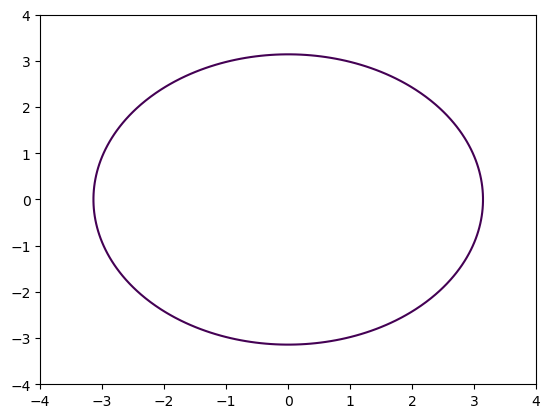

In [33]:
# Assuming x, y, z are your meshgrid data
# Example data for demonstration
x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)
x, y = np.meshgrid(x, y)
z = np.sin(np.sqrt(x**2 + y**2))

# Create a contour plot
contour = plt.contour(x, y, z, levels=[0])  # levels can be adjusted based on the desired contour level

# Initialize an empty list to store line segments
line_segments = []

# Collect all line segments from the contour
for collection in contour.collections:
    for path in collection.get_paths():
        # Extract the vertices of the line segments
        vertices = path.vertices
        for i in range(len(vertices) - 1):
            line_segments.append((vertices[i], vertices[i+1]))

# Optionally, you can close a plot to avoid displaying it in non-interactive environments
plt.show()
plt.close()

# Now line_segments contains all the 2D line segments as tuples of start and end points
#print(line_segments)

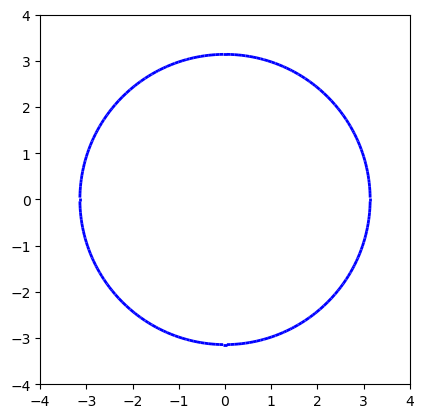

In [34]:
line_collection = LineCollection(line_segments, colors='blue', linewidths=2)

# Create a plot
fig, ax = plt.subplots()

# Add the LineCollection to the plot
ax.add_collection(line_collection)

# Optionally set limits and aspect ratio
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_aspect('equal', 'box')

# Display the plot
plt.show()

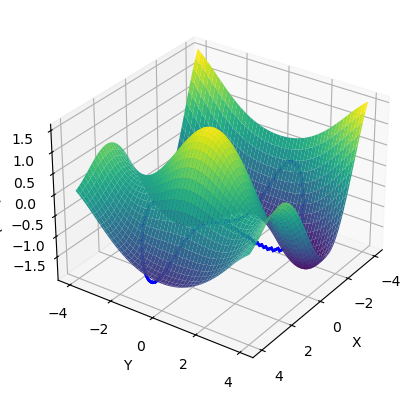

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection

# Example surface data A(x, y)
A = np.cos(np.sqrt(x**2 + y**2))+np.sin(x)

# Initialize an empty list for 3D line segments (each segment as [start, end], each point as [x, y, z])
line_segments_3d = []

for segment in line_segments:
    start, end = segment
    x_start, y_start = start
    x_end, y_end = end
    z_start = A[int(np.argmin(np.abs(x[0] - x_start))), int(np.argmin(np.abs(y[:,0] - y_start)))]
    z_end = A[int(np.argmin(np.abs(x[0] - x_end))), int(np.argmin(np.abs(y[:,0] - y_end)))]
    line_segments_3d.append([[x_start, y_start, z_start], [x_end, y_end, z_end]])

# Setting up the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Add the line segments
for segment in line_segments_3d:
    ax.plot(*zip(*segment), color='blue', lw=2)

# Optionally, plot the surface
ax.plot_surface(x, y, A, alpha=1, cmap='viridis')
ax.view_init(elev=30, azim=35)

# Labels and show
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('A(x, y)')
plt.show()

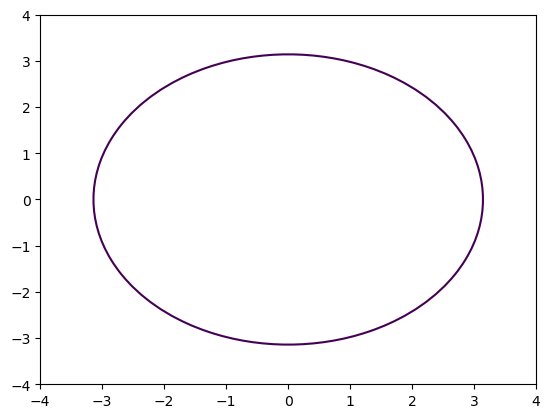

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_77660/360737246.py:21: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in contour.collections:


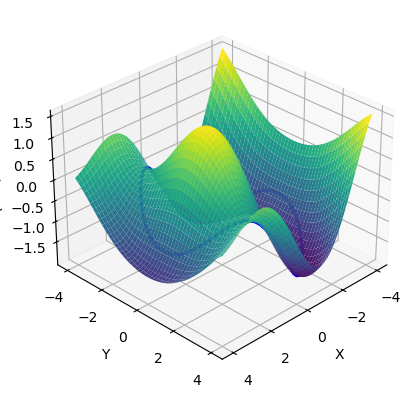

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from matplotlib.collections import LineCollection

# Example data setup
# Using meshgrid for x, y, a (replace this with your actual data)
x = np.linspace(-4, 4, 50)
y = np.linspace(-4, 4, 50)
x, y = np.meshgrid(x, y)
a = np.cos(np.sqrt(x**2 + y**2))+np.sin(x)  # mock surface data

# Generate contour data for line segments
z = np.sin(np.sqrt(x**2 + y**2))
contour = plt.contour(x, y, z, levels=[0])
plt.show()
plt.close()  # Close the plot as we only need data

line_segments = []
for collection in contour.collections:
    for path in collection.get_paths():
        vertices = path.vertices
        for i in range(len(vertices) - 1):
            line_segments.append((vertices[i], vertices[i+1]))

# Flatten the meshgrid for interpolation
points = np.column_stack((x.ravel(), y.ravel()))
values = a.ravel()

# Prepare list for 3D segments with interpolated values
line_segments_3d = []

for segment in line_segments:
    start, end = segment
    # Interpolate the a value at the start and end of the segment
    a_start = griddata(points, values, start, method='linear')[0]
    a_end = griddata(points, values, end, method='linear')[0]
    line_segments_3d.append([[start[0], start[1], a_start], [end[0], end[1], a_end]])

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Add the 3D line segments
for segment in line_segments_3d:
    ax.plot(*zip(*segment), color='blue', lw=2)

# Optionally set the viewing angle
ax.plot_surface(x, y, a, alpha=1, cmap='viridis')
ax.view_init(elev=30, azim=45)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('A(x, y)')

plt.show()

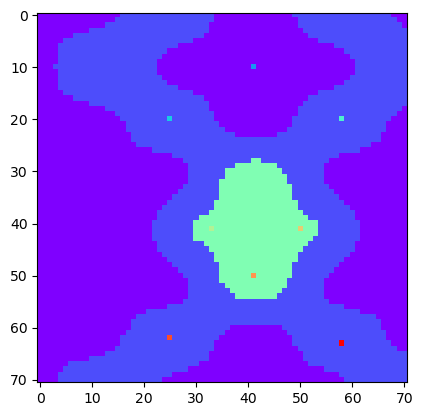

In [196]:
fill = np.zeros_like(z)
for i,mask in enumerate(masks):
    fill[mask]=i+1
plt.imshow(fill,cmap='rainbow')

In [168]:
len(masks)

3

In [138]:
z[6,6]

0.9800851433251829

In [139]:
z[5,4]

0.8494296003290209